# Part 1: Image

## 1.1: Initialize MediaPipe FaceMesh, ViT Facial Expression Model, and Libraries for Image


In [1]:
!git clone https://github.com/AssemblyAI-Examples/mediapipe-python.git # Associated with the [MediaPipe for Dummies](https://www.assemblyai.com/blog/mediapipe-for-dummies/)
!pip install mediapipe
!pip install PyQt5
!pip install ipython==7.32.0


fatal: destination path 'mediapipe-python' already exists and is not an empty directory.


In [2]:
import cv2
import mediapipe as mp
import urllib.request
import numpy as np
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation
import PyQt5
from PIL import Image
from IPython.display import HTML
import importlib
from base64 import b64encode
from google.colab import files
nb_helpers = importlib.import_module("mediapipe-python.nb_helpers")

import zipfile
import os
import glob
import re

from PIL import Image


import torch
import torch.nn.functional as F

import numpy as np
import pandas as pd

In [3]:
# import torch
# import torch.nn.functional as F
# import mediapipe as mp

# Initialize MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh

from transformers import AutoProcessor, AutoModelForImageClassification

# Using a known working model from Hugging Face
extractor = AutoProcessor.from_pretrained("trpakov/vit-face-expression")  # or your own model
model = AutoModelForImageClassification.from_pretrained("trpakov/vit-face-expression")
model.eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/915 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

## 1.2: Uploading and Processing Raw Videos

In [4]:
# Step 1: Upload the zipped folder
print("Please upload 'Raw_Video_Recordings.zip' ")
uploaded = files.upload()  # Select your Raw_Video_Recordings.zip here
print("Files uploaded successfully!")

Please upload 'Raw_Video_Recordings.zip' 


Saving Raw_Video_Recordings.zip to Raw_Video_Recordings.zip
Files uploaded successfully!


In [5]:
# Step 2: Prepare extraction directory
def process_videos(uploaded, decision_times_str, decision_duration):
    extract_path = "/content/videos"
    if os.path.exists(extract_path):
        for f in os.listdir(extract_path):
            os.remove(os.path.join(extract_path, f))

    os.makedirs(extract_path, exist_ok=True)
    zip_name = next(iter(uploaded))

    # Step 3: Extract ZIP
    with zipfile.ZipFile(zip_name, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    # Step 4: Recursively find all video files
    video_extensions = ('*.mp4', '*.avi', '*.mov', '*.mkv')
    video_files = []
    for ext in video_extensions:
        video_files.extend(glob.glob(os.path.join(extract_path, '**', ext), recursive=True))

    # Extract all numbers from filename and convert to a list of integers
    def extract_all_numbers(filename):
        return list(map(int, re.findall(r'\d+', os.path.basename(filename))))

    # Sort video files based on all numbers in their filenames (not just the first one)
    video_files = sorted(video_files, key=extract_all_numbers)

    # Step 6: Ask for decision moments
    if not video_files:
        print("❌ No videos found in the uploaded zip.")
        return []
    else:
        print("\n📁 Videos found (sorted by leading number):")
        for i, video in enumerate(video_files, 1):
            print(f"{i}. {os.path.basename(video)}")

        if len(decision_times_str) != len(video_files):
            print("⚠️ Number of timestamps must match number of videos.")
            return []
        else:
            # Step 7: Prepare output folder
            output_dir = "/content/segmented_videos"
            os.makedirs(output_dir, exist_ok=True)

            for f in os.listdir(output_dir):
                os.remove(os.path.join(output_dir, f))

            # Step 8: Segment each video
            for idx, video_path in enumerate(video_files):
                time_str = decision_times_str[idx].strip()
                try:
                    mins, secs = map(int, time_str.split(":"))
                    end_sec = mins * 60 + secs
                    start_sec = max(0, end_sec - decision_duration)

                    cap = cv2.VideoCapture(video_path)
                    fps = cap.get(cv2.CAP_PROP_FPS)
                    if fps == 0:
                        print(f"⚠️ Could not read FPS for: {video_path}")
                        continue

                    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
                    fourcc = cv2.VideoWriter_fourcc(*'mp4v')

                    start_frame = int(start_sec * fps)
                    end_frame = int(end_sec * fps)
                    end_frame = min(end_frame, total_frames)

                    basename = os.path.basename(video_path)
                    out_path = os.path.join(output_dir, f"{basename}")
                    out = cv2.VideoWriter(out_path, fourcc, fps, (width, height))
                    print(out_path)
                    print(output_dir)
                    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
                    for f in range(start_frame, end_frame):
                        ret, frame = cap.read()
                        if not ret:
                            break
                        out.write(frame)

                    cap.release()
                    out.release()
                    print(f"✅ Segmented: {out_path}")
                except:
                    print(f"⚠️ Skipped invalid time format: {time_str}")

    print("\n✅ All videos processed.")
    print(f" \n number of video files: {len(video_files)} ")
    return out_path, video_path, output_dir

In [6]:
def get_sorted_video_paths(output_dir):
    """
    Gets a sorted list of video file paths from a directory.

    Args:
        output_dir (str): The path to the directory containing video files.

    Returns:
        list: A list of video file paths sorted by the numbers in their filenames.
    """
    def extract_numbers_from_path(path):
        filename = os.path.basename(path)
        return list(map(int, re.findall(r'\d+', filename)))

    full_paths = [os.path.join(output_dir, f) for f in os.listdir(output_dir) if f.endswith(('.mp4', '.avi', '.mov', '.mkv'))]
    sorted_paths = sorted(full_paths, key=extract_numbers_from_path)

    return sorted_paths

# Example usage (assuming output_dir is defined)
# sorted_video_files = get_sorted_video_paths(output_dir)
# if sorted_video_files:
#     print("📄 First numerically sorted path:", sorted_video_files[0])
# else:
#     print("❌ No valid video files found in output_dir.")

## 1.3: Feature Extraction


In [7]:
def load_video_and_extract_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)

    if fps == 0:  # Defensive check
        raise ValueError("Could not read video FPS. Check if the path is correct and video is not corrupted.")

    frame_interval = int(fps)  # 1 frame per second

    frames = []
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % frame_interval == 0:
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(Image.fromarray(rgb_frame))

        frame_count += 1

    cap.release()
    return frames

In [8]:
# Approximate ARKit-like blendshape scores using MediaPipe landmarks.
# Note: These are heuristic approximations and not official ARKit weights.

def dist(p1, p2):
    return np.sqrt((p1.x - p2.x)**2 + (p1.y - p2.y)**2)

def blendshape_scores(lm):
    # Normalize distances based on interocular distance
    ref_scale = dist(lm[33], lm[263])  # roughly eye-to-eye

    def norm(d): return d / ref_scale if ref_scale > 0 else 0

    scores = {
        "BrowDownLeft": norm(dist(lm[105], lm[66])),
        "BrowDownRight": norm(dist(lm[334], lm[296])),
        "BrowInnerUp": norm(dist(lm[66], lm[9])),
        "BrowOuterUpLeft": norm(dist(lm[107], lm[33])),
        "BrowOuterUpRight": norm(dist(lm[336], lm[263])),
        "CheekPuff": norm(dist(lm[50], lm[280])),
        "CheekSquintLeft": norm(dist(lm[50], lm[61])),
        "CheekSquintRight": norm(dist(lm[280], lm[291])),
        "EyeBlinkLeft": norm(dist(lm[159], lm[145])),
        "EyeBlinkRight": norm(dist(lm[386], lm[374])),
        "EyeLookDownLeft": lm[468].y - lm[159].y,
        "EyeLookDownRight": lm[473].y - lm[386].y,
        "EyeLookUpLeft": lm[159].y - lm[468].y,
        "EyeLookUpRight": lm[386].y - lm[473].y,
        "EyeLookInLeft": lm[133].x - lm[468].x,
        "EyeLookInRight": lm[473].x - lm[362].x,
        "EyeLookOutLeft": lm[468].x - lm[33].x,
        "EyeLookOutRight": lm[263].x - lm[473].x,
        "EyeSquintLeft": norm(dist(lm[159], lm[145])) * 0.5,
        "EyeSquintRight": norm(dist(lm[386], lm[374])) * 0.5,
        "EyeWideLeft": norm(dist(lm[159], lm[145])) * 2,
        "EyeWideRight": norm(dist(lm[386], lm[374])) * 2,
        "JawForward": norm(dist(lm[17], lm[0])),
        "JawLeft": lm[152].x - lm[1].x,
        "JawRight": lm[1].x - lm[152].x,
        "JawOpen": norm(dist(lm[152], lm[1])),
        "MouthClose": 1 - norm(dist(lm[13], lm[14])),
        "MouthDimpleLeft": norm(dist(lm[61], lm[50])),
        "MouthDimpleRight": norm(dist(lm[291], lm[280])),
        "MouthFrownLeft": norm(dist(lm[61], lm[33])),
        "MouthFrownRight": norm(dist(lm[291], lm[263])),
        "MouthFunnel": norm(dist(lm[13], lm[14])),
        "MouthLeft": lm[61].x - lm[0].x,
        "MouthRight": lm[291].x - lm[0].x,
        "MouthLowerDownLeft": norm(dist(lm[84], lm[17])),
        "MouthLowerDownRight": norm(dist(lm[314], lm[17])),
        "MouthPressLeft": norm(dist(lm[61], lm[0])),
        "MouthPressRight": norm(dist(lm[291], lm[0])),
        "MouthPucker": 1 - norm(dist(lm[61], lm[291])),
        "MouthRollLower": norm(dist(lm[17], lm[14])),
        "MouthRollUpper": norm(dist(lm[13], lm[0])),
        "MouthShrugLower": norm(dist(lm[17], lm[14])) * 1.2,
        "MouthShrugUpper": norm(dist(lm[13], lm[0])) * 1.2,
        "MouthSmileLeft": norm(dist(lm[61], lm[50])),
        "MouthSmileRight": norm(dist(lm[291], lm[280])),
        "MouthStretchLeft": norm(dist(lm[61], lm[33])),
        "MouthStretchRight": norm(dist(lm[291], lm[263])),
        "MouthUpperUpLeft": norm(dist(lm[13], lm[61])),
        "MouthUpperUpRight": norm(dist(lm[13], lm[291])),
        "NoseSneerLeft": norm(dist(lm[94], lm[61])),
        "NoseSneerRight": norm(dist(lm[331], lm[291])),
        "TongueOut": norm(dist(lm[19], lm[17])),
    }

    return scores

In [9]:

#def process_frames_to_dataframe(frames, i, model, extractor, dist, blendshape_scores):
def process_frames_to_dataframe(frames, i,file_name, model, extractor, dist, blendshape_scores):

    mp_face_mesh = mp.solutions.face_mesh
    useable=True   # is case the video is not use  bale the will be labeled as False later
    # Initialize accumulators
    emotion_accumulator = None
    blendshape_accumulator = {}
    num_valid_frames = 0

    for idx, image in enumerate(frames):
        w, h = image.size
        left = int(w * 0.45)
        right = int(w * 0.75)
        top = int(h * 0.5)
        bottom = int(h * 1)
        cropped = image.crop((left, top, right, bottom))
        image_np = np.array(cropped)

        with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True) as face_mesh:
            results = face_mesh.process(cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR))
            if results.multi_face_landmarks:
                face_landmarks = results.multi_face_landmarks[0]

                # Crop for emotion model
                h, w, _ = image_np.shape
                x_coords = [lm.x for lm in face_landmarks.landmark]
                y_coords = [lm.y for lm in face_landmarks.landmark]
                x_min, x_max = int(min(x_coords)*w), int(max(x_coords)*w)
                y_min, y_max = int(min(y_coords)*h), int(max(y_coords)*h)
                cropped_face_np = image_np[y_min:y_max, x_min:x_max]
                cropped_face = Image.fromarray(cropped_face_np).resize((224, 224))

                # Emotion model prediction
                inputs = extractor(images=cropped_face, return_tensors="pt")
                with torch.no_grad():
                    outputs = model(**inputs)
                    logits = outputs.logits
                    probs = F.softmax(logits, dim=1)[0].tolist()

                # Accumulate emotion probabilities
                if emotion_accumulator is None:
                    emotion_accumulator = np.array(probs)
                    print(f"Iteration number: {i}")
                    print(idx,np.array(probs))
                    plt.imshow(image_np)
                    plt.show()
                else:
                    emotion_accumulator += np.array(probs)
                    print(f"Iteration number: {i}")
                    print(idx,np.array(probs))
                    plt.imshow(image_np)
                    plt.show()

                # Accumulate blendshape scores
                lm = face_landmarks.landmark
                ref_scale = dist(lm[33], lm[263])
                bscores = blendshape_scores(lm)

                for name, score in bscores.items():
                    blendshape_accumulator[name] = blendshape_accumulator.get(name, 0) + score

                num_valid_frames += 1

    # Average and return as dataframe
    if num_valid_frames > 0:
        avg_emotions = emotion_accumulator / num_valid_frames
        avg_blendshapes = {name: score / num_valid_frames for name, score in blendshape_accumulator.items()}

        emotion_labels = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
        #row_data = {'Iteration': i}

        file_name=os.path.basename(file_name)
        participant_num = int(re.match(r'\d+', file_name).group())   # take only leading digits
        row_data= {"video_File": participant_num} #         row_data["video_File"] = participant_num

        row_data["Iteration"] = i


        # Add emotions
        for label, prob in zip(emotion_labels, avg_emotions):
            row_data[f"emotion_{label}"] = prob

        # Add blendshapes
        for name, score in avg_blendshapes.items():
            row_data[f"blend_{name}"] = score

        return pd.DataFrame([row_data]), useable

    else:
        print(f"⚠️ No valid frames detected for iteration: {i} .")
        useable=False
        return pd.DataFrame() , useable  # return empty DataFrame

In [10]:
def process_and_label_videos(output_dir, model, extractor, dist, blendshape_scores):
    """
    Processes segmented videos in a directory, extracts features, and labels them.

    Args:
        output_dir (str): The path to the directory containing segmented video files.
        model: The emotion classification model.
        extractor: The image feature extractor.
        dist: The distance calculation function.
        blendshape_scores: The blendshape scoring function.

    Returns:
        pd.DataFrame: A DataFrame containing extracted features and labels.
    """
    Decisions = [
        "AI", "AI", "Human", "Human", "AI", "AI",
        "AI", "Human", "Human", "Human", "AI", "AI",
        "AI", "AI", "AI", "Human", "AI", "AI", "Human", "AI",
        "AI", "AI", "AI", "Human", "Human", "Human", "AI", "AI", "AI", "Human",
        "AI", "AI", "AI", "AI", "AI", "AI", "AI", "Human", "AI", "AI",
        "AI", "AI", "AI", "AI", "AI", "Human", "AI", "AI", "AI", "Human",
        "AI", "AI", "Human", "AI", "AI", "AI", "AI", "Human", "Human", "AI",
        "Human", "Human", "Human", "Human", "AI", "AI", "AI", "AI", "AI",
        "Human", "Human", "Human", "Human", "AI", "Human", "AI", "Human", "Human"
    ]
    segmented_video_files = get_sorted_video_paths(output_dir)
    dfs = []
    processed_decisions = []

    if len(Decisions) != len(segmented_video_files):
        print("⚠️ Warning: The number of decisions does not match the number of segmented video files.")
        # You might want to handle this mismatch appropriately, e.g., by returning an empty DataFrame
        return pd.DataFrame()


    for i_participant in range(len(segmented_video_files)):
        #print(segmented_video_files[i_participant])
        try:
            frames = load_video_and_extract_frames(segmented_video_files[i_participant])
            file_name = segmented_video_files[i_participant]
            DataFrame, useable = process_frames_to_dataframe(frames, i_participant, file_name, model, extractor, dist, blendshape_scores)
            if useable:
                dfs.append(DataFrame)
                processed_decisions.append(Decisions[i_participant])
            else:
                print(f"Skipping decision for {file_name} due to processing issues.")


        except Exception as e:
            print(f"Error processing segmented video {segmented_video_files[i_participant]}: {e}")
            # Handle the error, e.g., skip this video and its decision

    if dfs:
        stacked_df_labeled = pd.concat(dfs, ignore_index=True)
        # Ensure the number of decisions matches the number of processed videos before inserting
        if len(processed_decisions) == len(stacked_df_labeled):
             stacked_df_labeled.insert(1, 'Decision', processed_decisions)
        else:
            print("⚠️ Mismatch between number of successfully processed videos and decisions. Decision column not added.")
        return stacked_df_labeled
    else:
        print("❌ No valid frames processed from segmented videos.")
        return pd.DataFrame()

# Example usage (assuming output_dir, model, extractor, dist, and blendshape_scores are defined)
# stacked_df_labeled = process_and_label_videos(output_dir, model, extractor, dist, blendshape_scores)
# if not stacked_df_labeled.empty:
#     display(stacked_df_labeled)

In [ ]:
out_path, video_path, output_dir = process_videos(uploaded, ["0:7"] * 78, 3) # Replace 7, 78 ,and 3 if end time windows, window duration and number of participants change
stacked_df_labeled_4_to_7= process_and_label_videos(output_dir, model, extractor, dist, blendshape_scores)

out_path, video_path, output_dir = process_videos(uploaded, ["0:10"] * 78, 3) # Replace 7, 78 ,and 3 if end time windows, window duration and number of participants change
stacked_df_labeled_7_to_10= process_and_label_videos(output_dir, model, extractor, dist, blendshape_scores)



# Part 2: GSR

## 2.1: Initialize Libraries for GSR


In [12]:
import pandas as pd
import time
!pip install neurokit2
import neurokit2 as nk
import numpy as np
from google.colab import files

import zipfile
import os
import re
import glob

import matplotlib.pyplot as plt
import shutil


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 13.0 MB/s eta 0:00:00


## 2.2: Uploading and Processing Raw GSR Data

In [13]:
# import os
# import glob

# Find all files that match the pattern 'csv_zip (*).zip'
files_to_delete = glob.glob("csv_zip (*.zip)")

for file in files_to_delete:
    try:
        os.remove(file)
        print(f"Deleted: {file}")
    except Exception as e:
        print(f"Error deleting {file}: {e}")

#Upload the CSV zip and experiment data file
print("Please upload 'csv_zip.zip' and ' exprmnt_data.csv'")
uploaded = files.upload()
print("Files uploaded successfully!")

Please upload 'csv_zip.zip' and ' exprmnt_data.csv'


Saving csv_zip.zip to csv_zip.zip
Saving exprmnt_data.csv to exprmnt_data.csv
Files uploaded successfully!


In [14]:
#import pdb

def compute_elapsed_time(gsr_csv_path, total_duration_seconds, decision_time_str, initial_lag_share=0.7, lead_time=3, win_lngth=3):
    # Load the GSR data from the CSV file and normalize the GSR data
    df = pd.read_csv(gsr_csv_path)
    temp_GSR = df['Galvanic Skin Response-ch1']
    GSR_normalized = (temp_GSR- temp_GSR.min()) / (temp_GSR.max() - temp_GSR.min())
    df['Galvanic Skin Response-ch1_normalized'] = GSR_normalized


    # Convert decision time (MM:SS) to seconds
    minutes, seconds = map(int, decision_time_str.split(':'))
    decision_time_seconds_in_video = minutes * 60 + seconds

    # Step 1: Calculate the minimum and maximum raw timestamps
    min_timestamp_raw = df['sequence'].min()
    max_timestamp_raw = df['sequence'].max()

    # Step 2: Calculate the total duration in the raw timestamp units (convert to seconds assuming 16Hz sampling rate)
    raw_duration_units = (max_timestamp_raw - min_timestamp_raw) / 16

    # Step 3: Calculate the difference between the expected and actual duration
    duration_difference = total_duration_seconds - raw_duration_units

    video_GSR_lag = initial_lag_share * duration_difference  # difference due to video-GSR recording lag
    print(f"Difference between expected and raw duration: {duration_difference:.2f} seconds")

    # Step 4: Calculate the windows in the GSR data corresponding to prediction window before decision-making
    decision_time_seconds_in_GSR = decision_time_seconds_in_video - video_GSR_lag
    win_end = decision_time_seconds_in_GSR - lead_time
    win_start = win_end - win_lngth    #
    # Step 5: Convert win_start and win_end to data sequence indices
    initial_sequence = df['sequence'].min()
    sequence_start = int(win_start * 16) + initial_sequence
    sequence_end = int(win_end * 16) + initial_sequence
    decision_sequence = int(decision_time_seconds_in_GSR * 16) + initial_sequence
    post_decision_sequence = int((decision_time_seconds_in_GSR + lead_time) * 16) + initial_sequence


    if not {sequence_start, sequence_end, decision_sequence, post_decision_sequence}.issubset(df['sequence'].unique()):
        print(f"required sequences are not in the dataframe    ")                                       ##########
        return None, None, None, pd.DataFrame(), pd.DataFrame(), None, "not applicable"
    # Step 6: Extract rows based on sequence range
    segmented_df = df[(df['sequence'] >= sequence_start) & (df['sequence'] <= sequence_end)].copy()
    decision_window_df = df[(df['sequence'] > sequence_end) & (df['sequence'] <= decision_sequence)].copy()
    post_decision_window_df = df[(df['sequence'] > decision_sequence) & (df['sequence'] <= post_decision_sequence)].copy()


    combined_df = pd.concat([segmented_df, decision_window_df, post_decision_window_df])

    ############################################# feature extraction ###############################
    # List of dataframes for each time window
    windows_list = [segmented_df, decision_window_df, post_decision_window_df]

    # Placeholder for net phasic values
    net_phasic_values = []
    max_phasic_values = []

    # Define sampling rate
    sampling_rate = 32
    # Calculate net phasic for each window
    for window_i in windows_list:
        signal = window_i['Galvanic Skin Response-ch1_normalized'].values
        # print("signal:",signal)
        # input()
        if len(signal) < 16: # Check if the signal is too short for filtering
            net_phasic_values.append(None)
            max_phasic_values.append(None)
        else:
            try:
                processed = nk.eda_process(signal, sampling_rate=sampling_rate)
                if processed is None or len(processed) == 0:
                    net_phasic_values.append(None)
                    max_phasic_values.append(None)
                else:
                    processed_df = processed[0]
                    if 'EDA_Phasic' not in processed_df.columns or processed_df['EDA_Phasic'].empty:
                         net_phasic_values.append(None)
                         max_phasic_values.append(None)
                    else:
                        phasic = processed_df["EDA_Phasic"].values

                        net_phasic_trapz = np.trapz(abs(phasic), dx=1/sampling_rate)
                        max_phasic=np.max(abs(phasic))

                        net_phasic_values.append(net_phasic_trapz)
                        max_phasic_values.append(max_phasic)

            except Exception as e:
                print(f"Error processing EDA signal: {e}")
                net_phasic_values.append(None)
                max_phasic_values.append(None)


    # Create a dataframe from the values
    net_phasic_df = pd.DataFrame([net_phasic_values, max_phasic_values], index=['net_phasic', 'max_phasic'], columns=[
        'predecision',
        'decision',
        'postdecision'
    ])


    if any(value is None for value in net_phasic_values) or any(value is None for value in max_phasic_values):
        return initial_sequence, win_end, decision_time_seconds_in_GSR, segmented_df, combined_df, None, "skipped"
    else:
        return initial_sequence, win_end, decision_time_seconds_in_GSR, segmented_df, combined_df, net_phasic_df, "applicable"

## 2.3: Feature Extraction

GSR file order to be analysised:
                          ['/content/gsr_data/GSR_1.csv', '/content/gsr_data/GSR_2.csv', '/content/gsr_data/GSR_3.csv', '/content/gsr_data/GSR_4.csv', '/content/gsr_data/GSR_5.csv', '/content/gsr_data/GSR_6.csv', '/content/gsr_data/GSR_8.csv', '/content/gsr_data/GSR_9.csv', '/content/gsr_data/GSR_10.csv', '/content/gsr_data/GSR_11.csv', '/content/gsr_data/GSR_12.csv', '/content/gsr_data/GSR_13.csv', '/content/gsr_data/GSR_14.csv', '/content/gsr_data/GSR_15.csv', '/content/gsr_data/GSR_16.csv', '/content/gsr_data/GSR_17.csv', '/content/gsr_data/GSR_18.csv', '/content/gsr_data/GSR_19.csv', '/content/gsr_data/GSR_20.csv', '/content/gsr_data/GSR_21.csv', '/content/gsr_data/GSR_23.csv', '/content/gsr_data/GSR_24.csv', '/content/gsr_data/GSR_25.csv', '/content/gsr_data/GSR_26.csv', '/content/gsr_data/GSR_27.csv', '/content/gsr_data/GSR_28.csv', '/content/gsr_data/GSR_29.csv', '/content/gsr_data/GSR_30.csv', '/content/gsr_data/GSR_31.csv', '/content/gsr_data/G

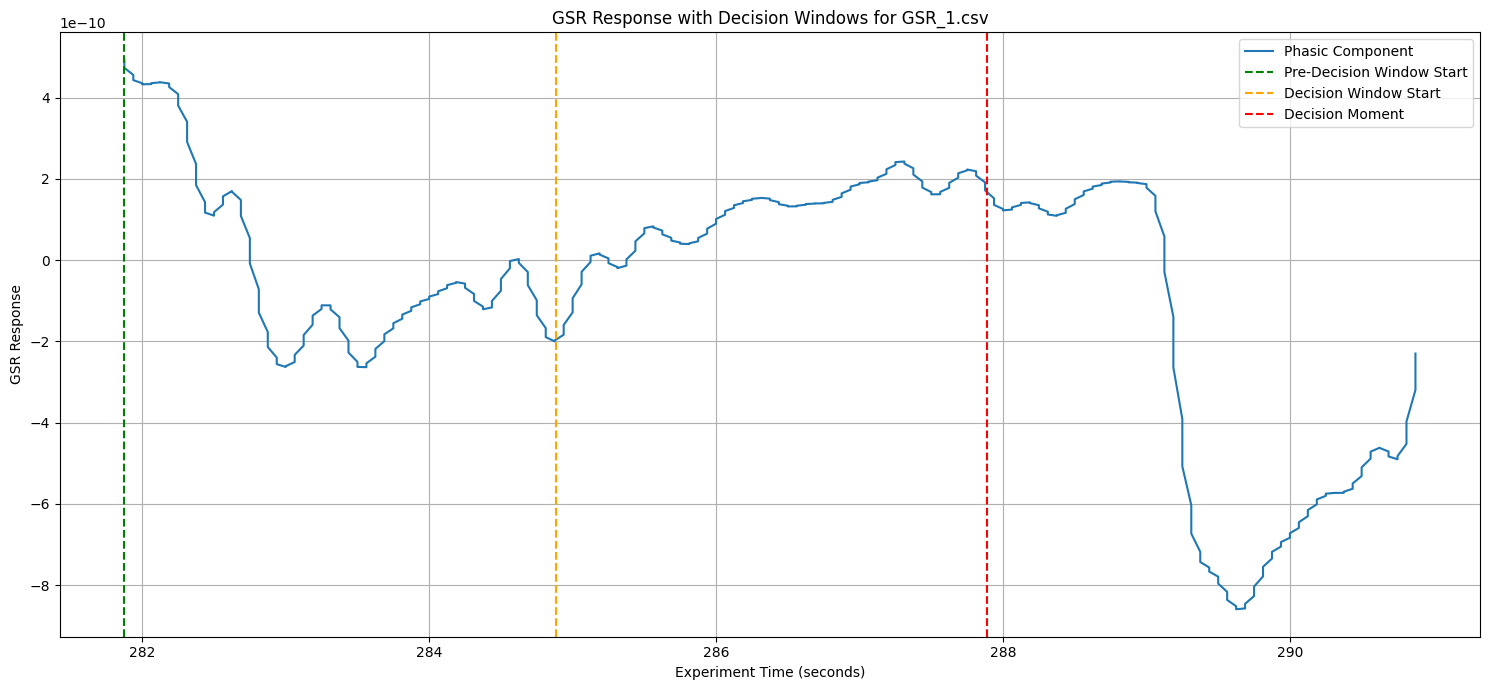


Processing file 2/78: /content/gsr_data/GSR_2.csv
Difference between expected and raw duration: 10.00 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.048954  0.015795      0.014703
max_phasic     0.030991  0.010563      0.008143


/usr/local/lib/python3.12/dist-packages/neurokit2/eda/eda_peaks.py:127: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])


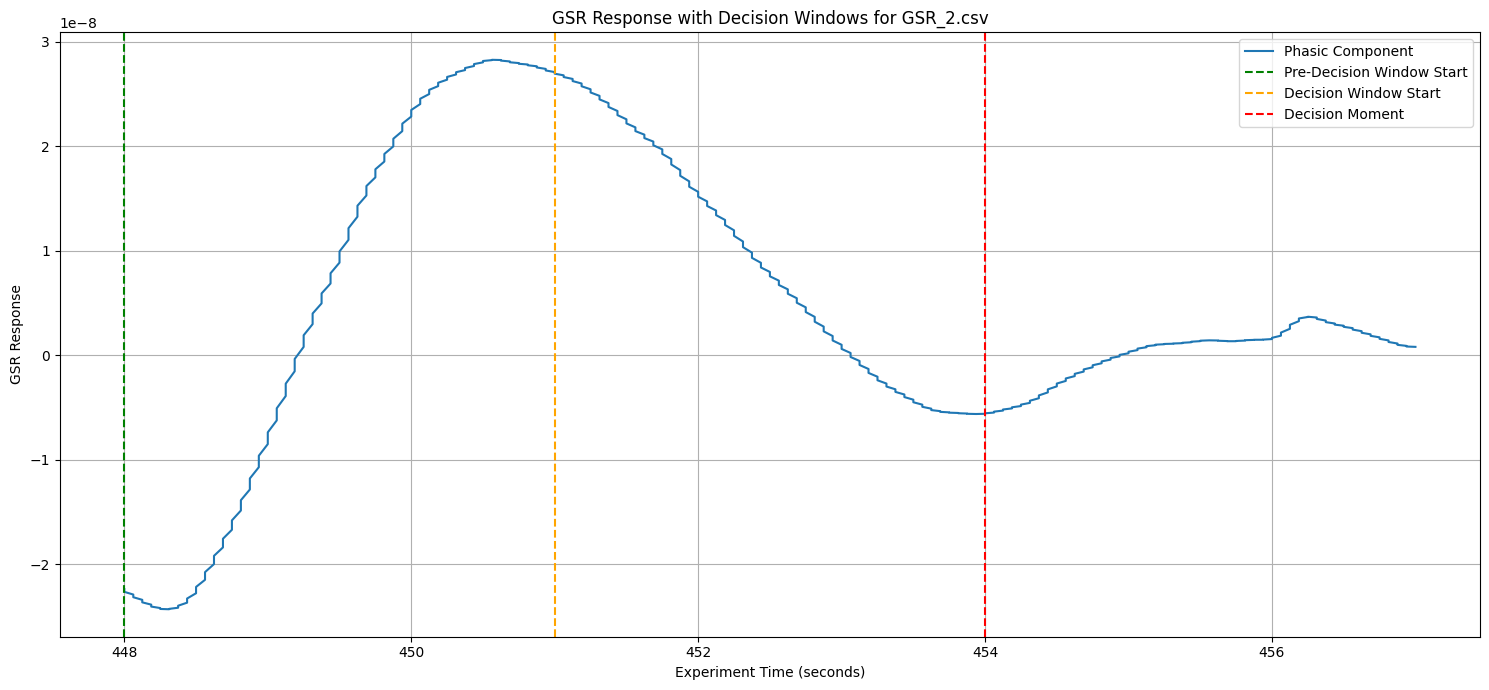


Processing file 3/78: /content/gsr_data/GSR_3.csv
Difference between expected and raw duration: 8.31 seconds
required sequences are not in the dataframe    
AUC:
 None
                                                                   Not applicable data found for the specified time window.

Processing file 4/78: /content/gsr_data/GSR_4.csv
Difference between expected and raw duration: 91042.69 seconds
required sequences are not in the dataframe    
AUC:
 None
                                                                   Not applicable data found for the specified time window.

Processing file 5/78: /content/gsr_data/GSR_5.csv
Difference between expected and raw duration: 86442.00 seconds
required sequences are not in the dataframe    
AUC:
 None
                                                                   Not applicable data found for the specified time window.

Processing file 6/78: /content/gsr_data/GSR_6.csv
Difference between expected and raw duration: 42.38 seconds
re

/usr/local/lib/python3.12/dist-packages/neurokit2/eda/eda_peaks.py:127: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])


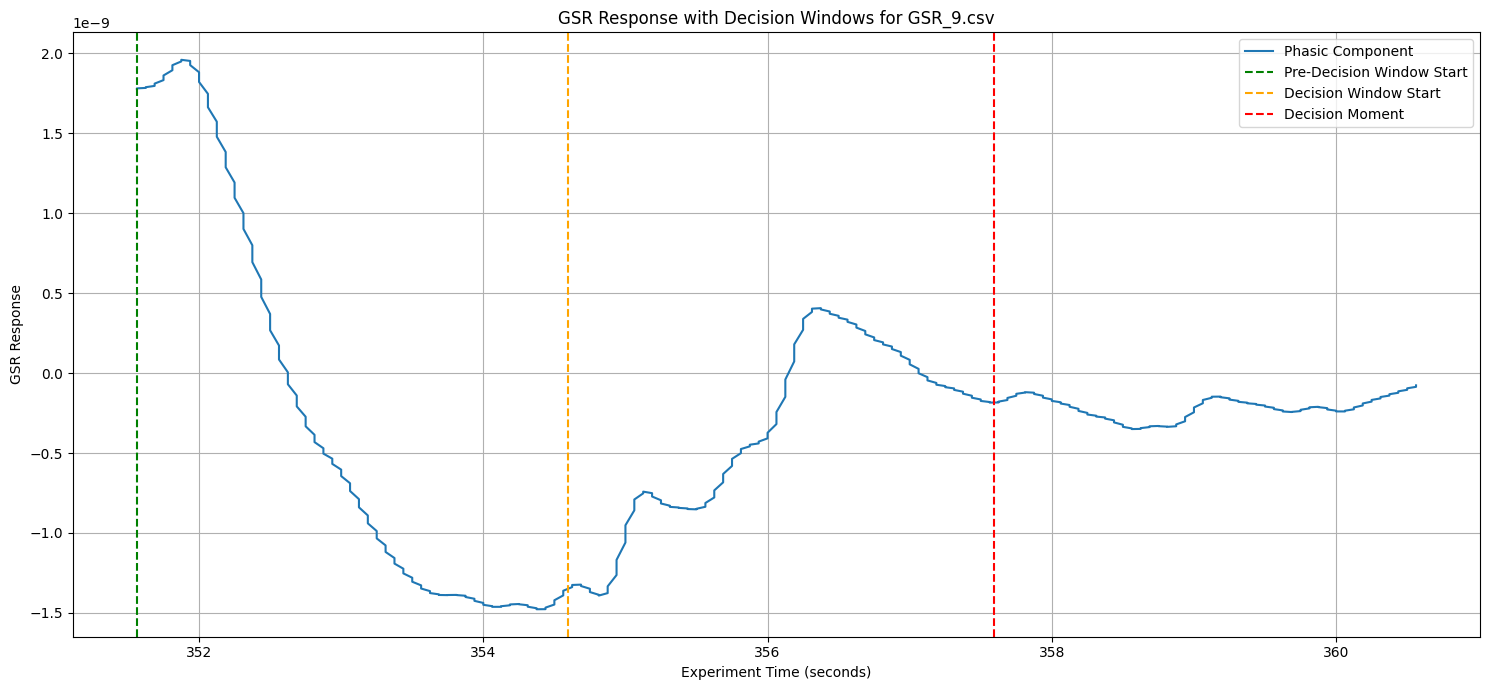


Processing file 9/78: /content/gsr_data/GSR_10.csv
Difference between expected and raw duration: 4.00 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.004189  0.006355      0.010424
max_phasic     0.005711  0.004212      0.005266


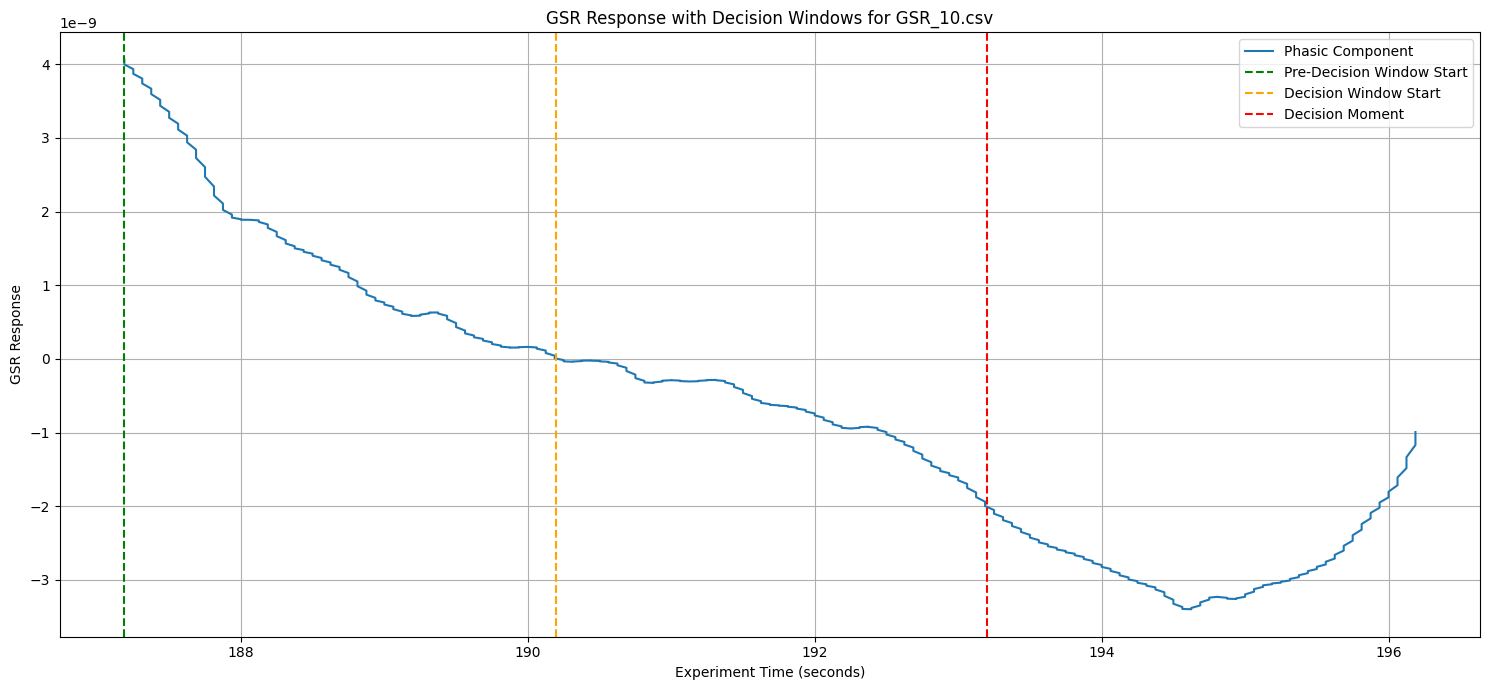


Processing file 10/78: /content/gsr_data/GSR_11.csv
Difference between expected and raw duration: 3.06 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.009876  0.004927      0.003168
max_phasic     0.005720  0.002490      0.002790


/usr/local/lib/python3.12/dist-packages/neurokit2/eda/eda_peaks.py:127: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])


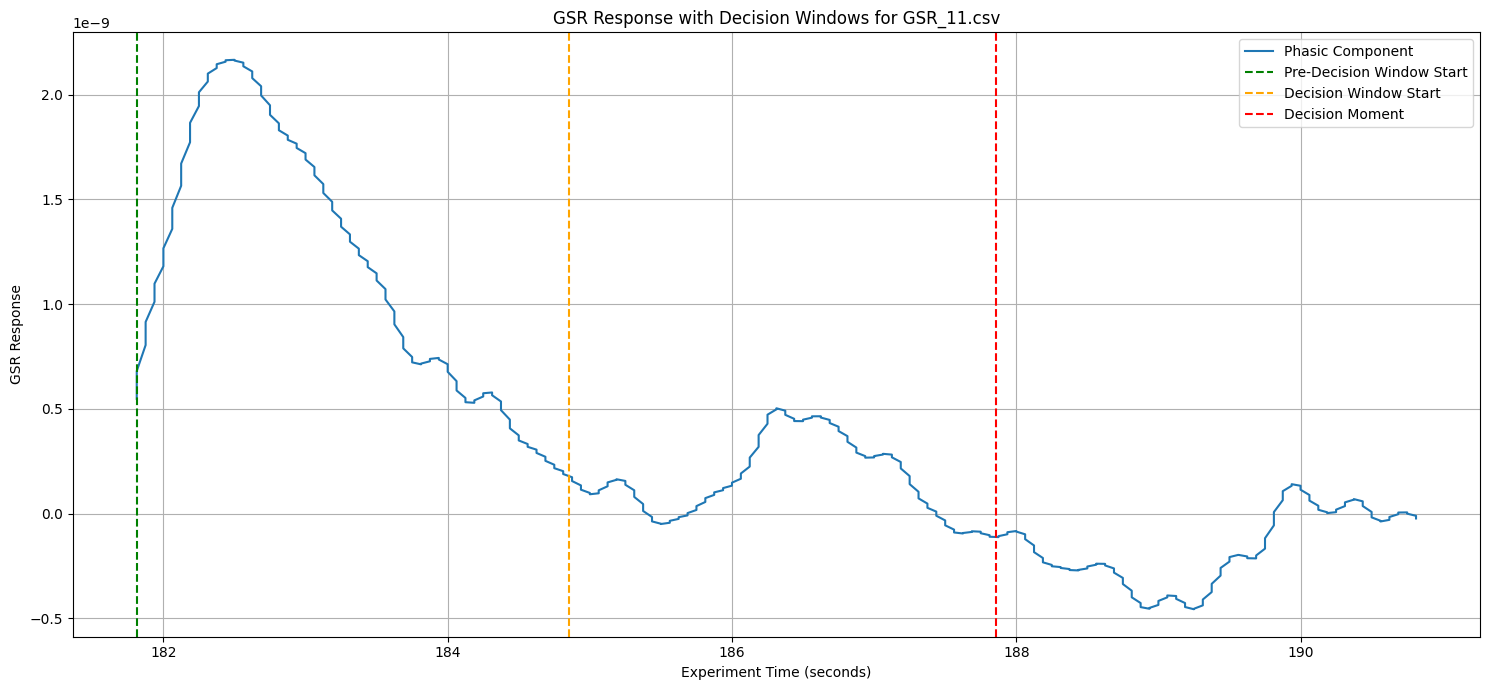


Processing file 11/78: /content/gsr_data/GSR_12.csv
Difference between expected and raw duration: 3.38 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.006043  0.003034      0.006793
max_phasic     0.004215  0.003478      0.004740


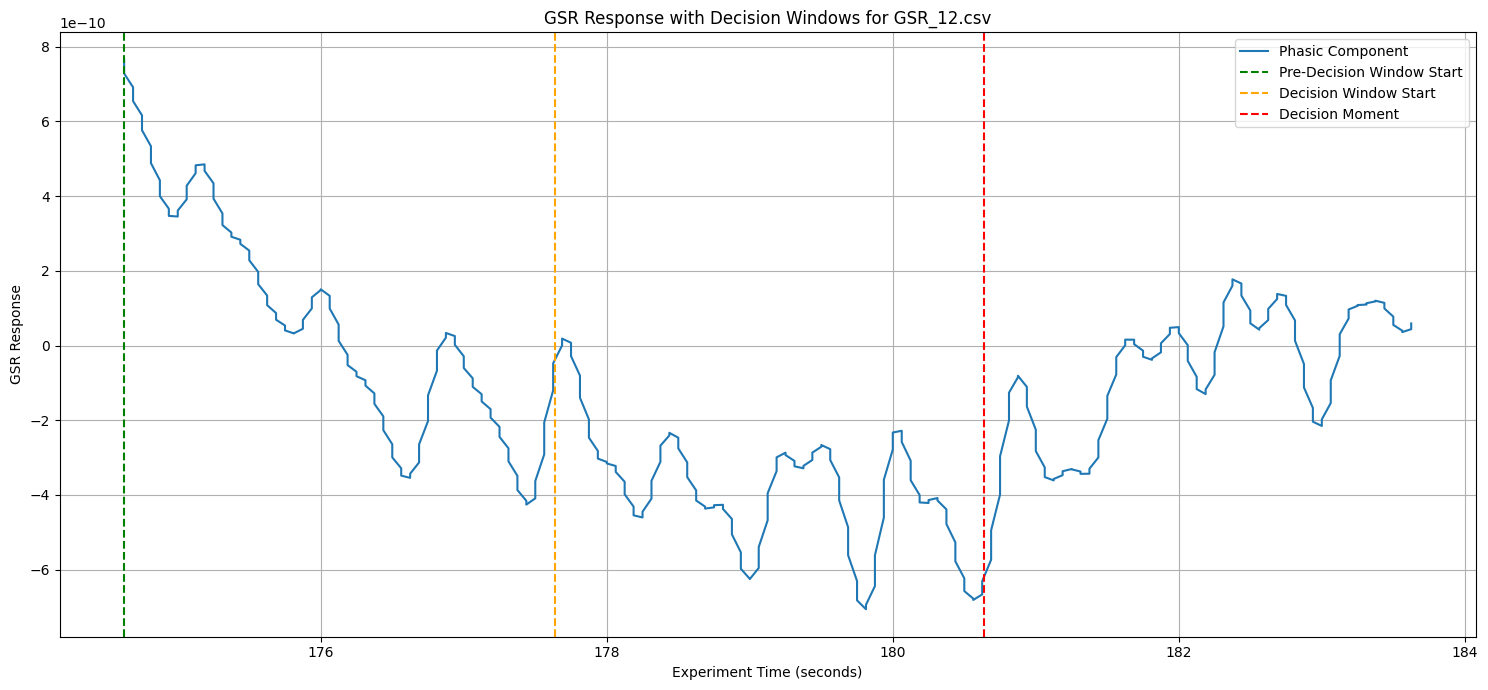


Processing file 12/78: /content/gsr_data/GSR_13.csv
Difference between expected and raw duration: 2.81 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.002323  0.005736      0.004168
max_phasic     0.002285  0.003369      0.002960


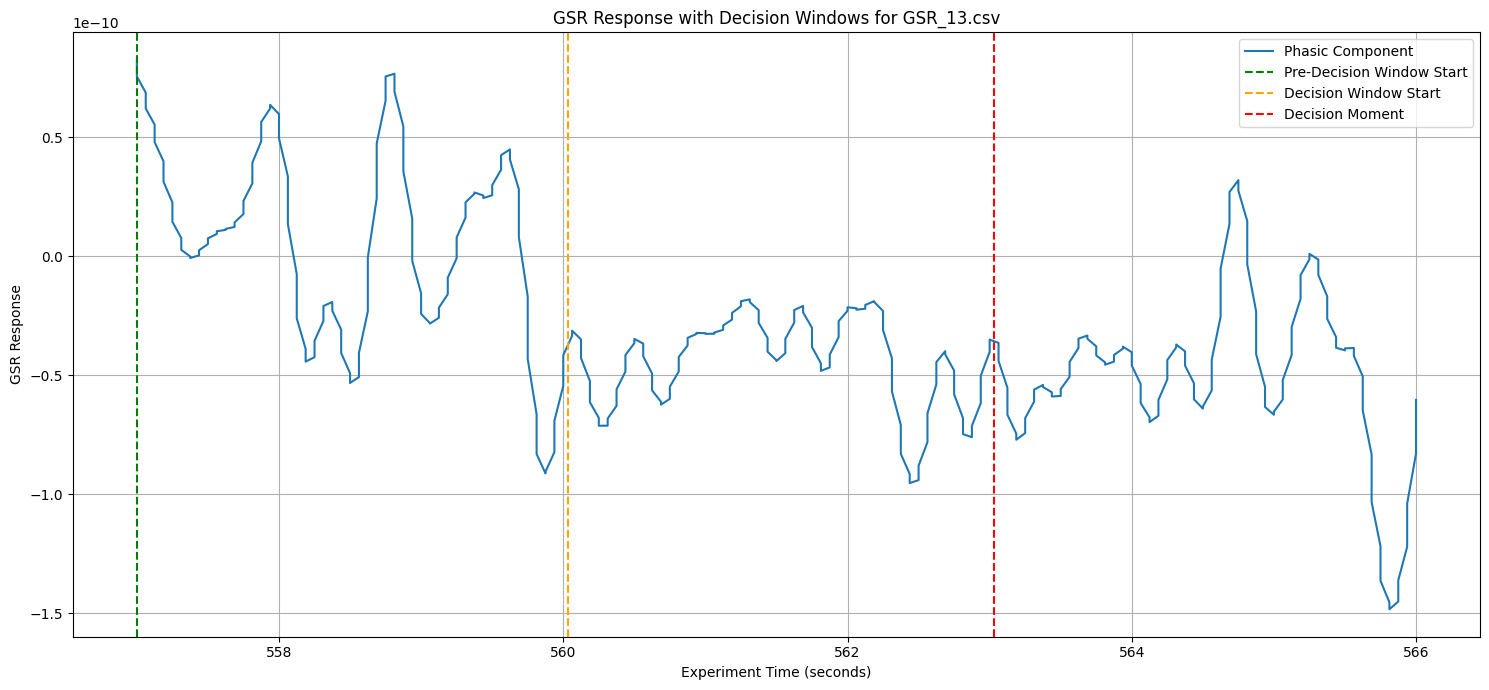


Processing file 13/78: /content/gsr_data/GSR_14.csv
Difference between expected and raw duration: 3.19 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.000455  0.000381      0.000622
max_phasic     0.000356  0.000450      0.000615


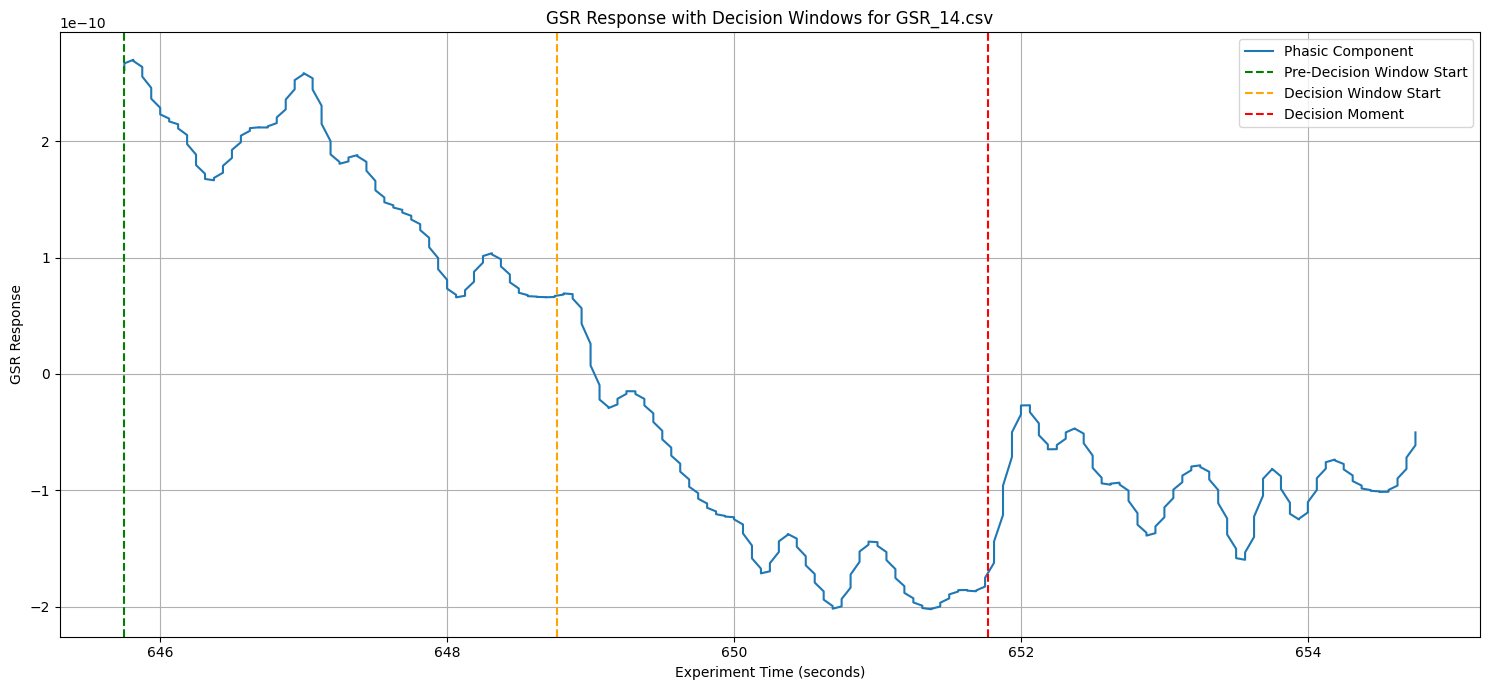


Processing file 14/78: /content/gsr_data/GSR_15.csv
Difference between expected and raw duration: 3.31 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.004616  0.004870      0.003991
max_phasic     0.003044  0.002846      0.003303


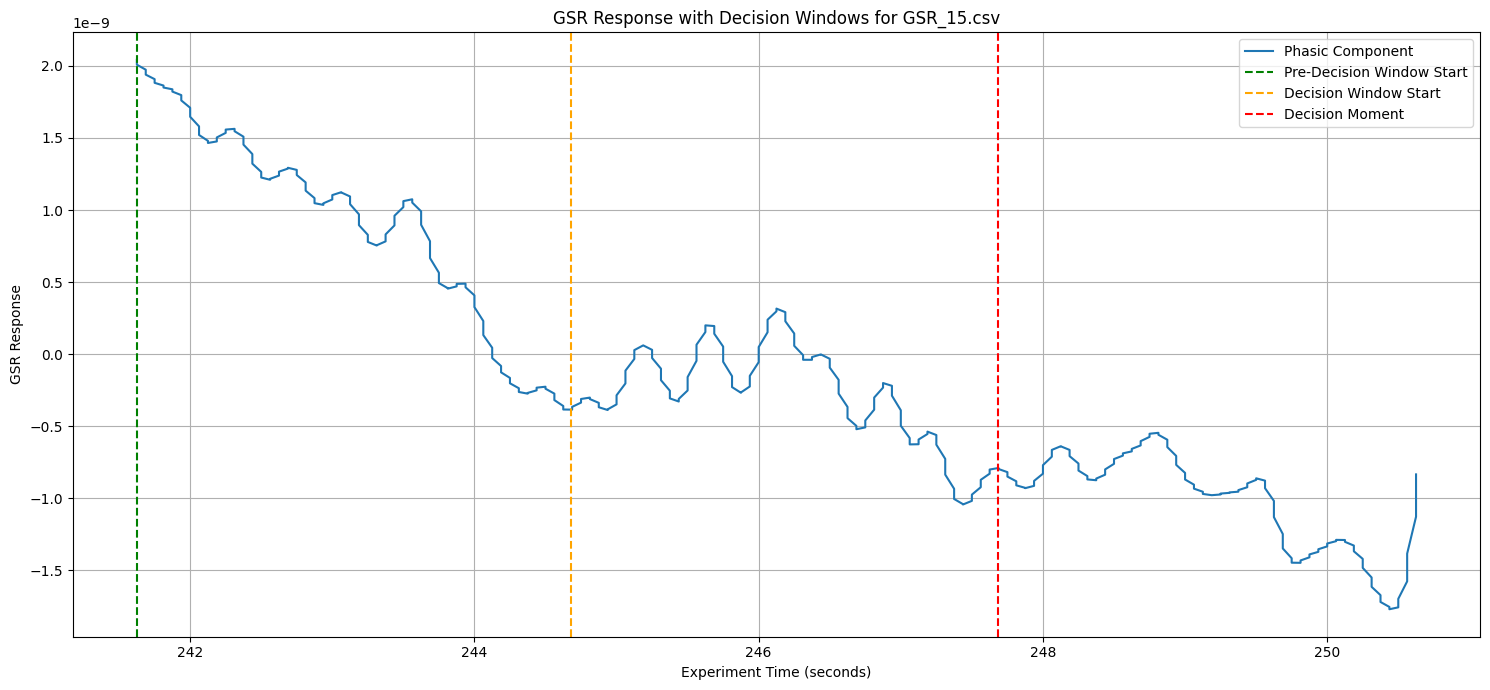


Processing file 15/78: /content/gsr_data/GSR_16.csv
Difference between expected and raw duration: 3.75 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.005672  0.008312      0.039567
max_phasic     0.004120  0.004906      0.026898


/usr/local/lib/python3.12/dist-packages/neurokit2/eda/eda_peaks.py:127: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])


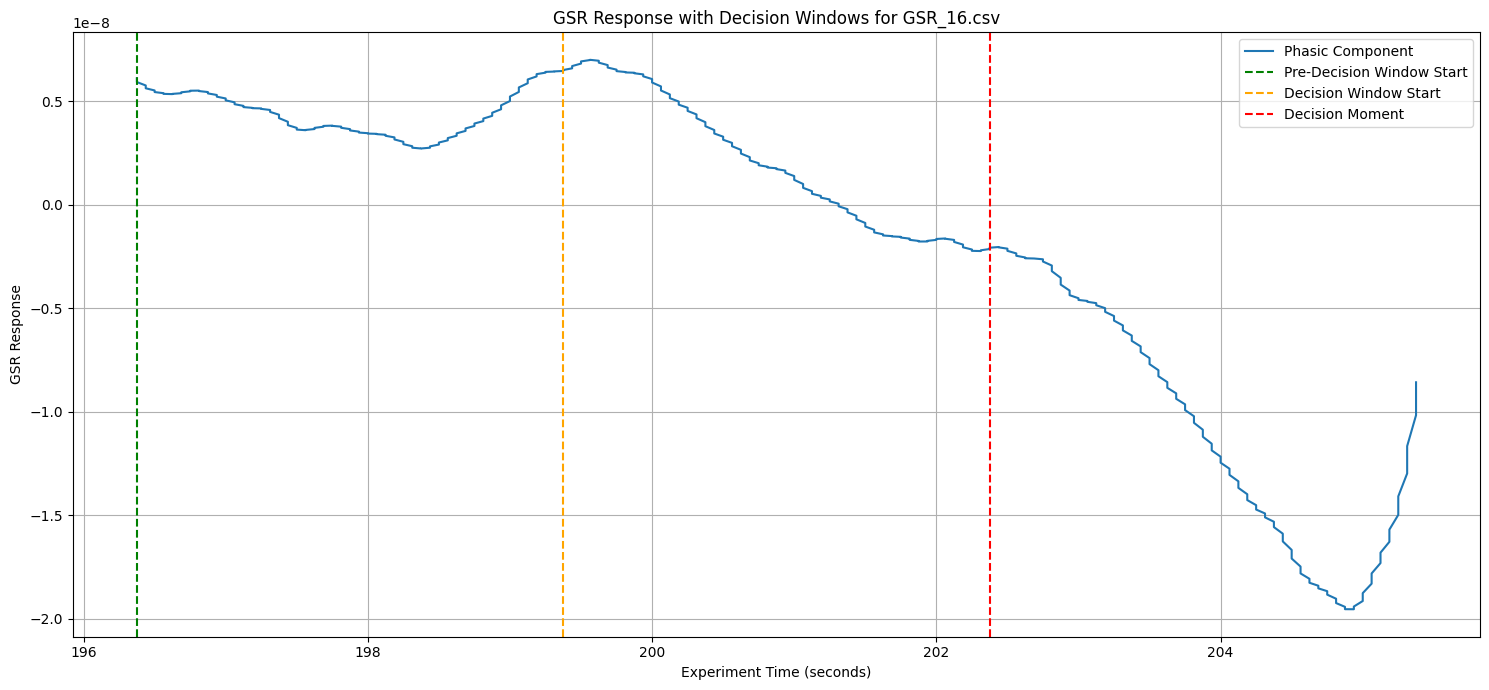


Processing file 16/78: /content/gsr_data/GSR_17.csv
Difference between expected and raw duration: 3.50 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.010391  0.020348      0.017083
max_phasic     0.006731  0.013598      0.009462


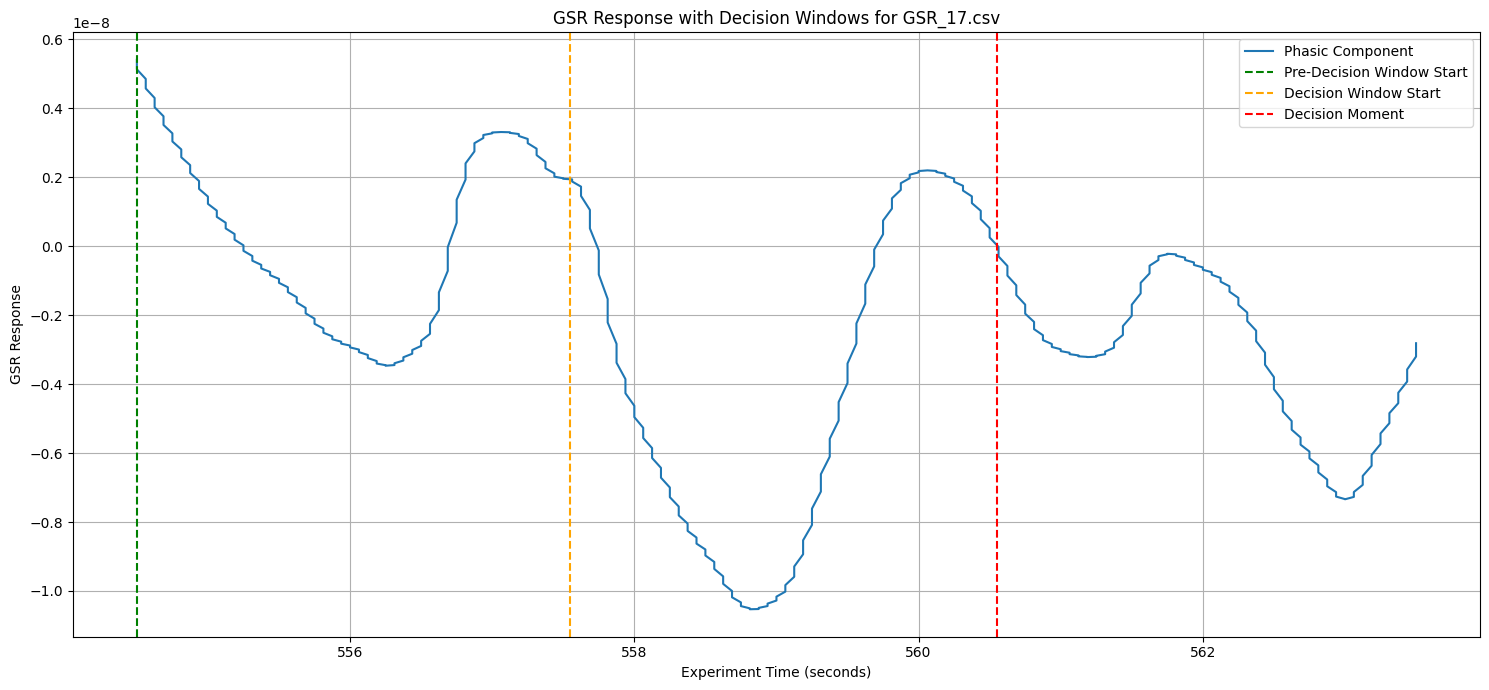


Processing file 17/78: /content/gsr_data/GSR_18.csv
Difference between expected and raw duration: 3.31 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.045324  0.020685      0.020119
max_phasic     0.023640  0.012405      0.013934


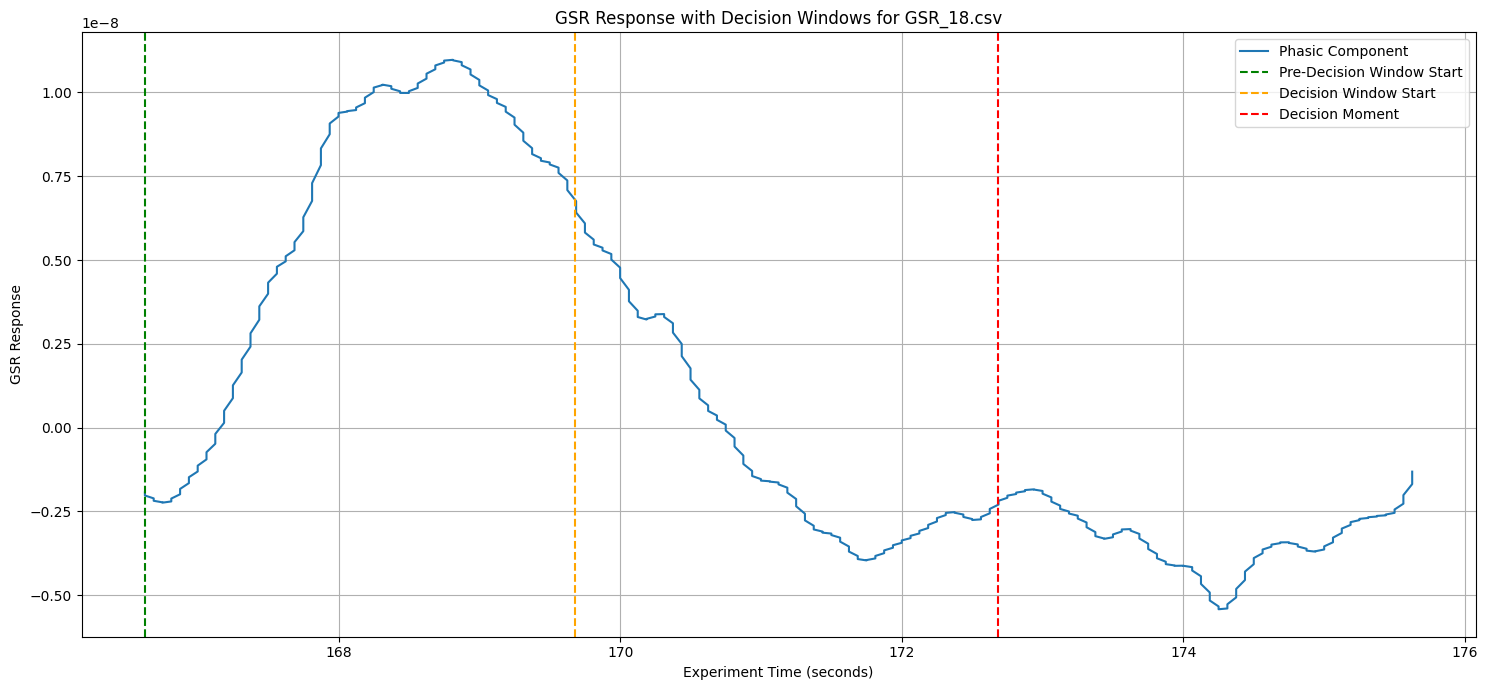


Processing file 18/78: /content/gsr_data/GSR_19.csv
Difference between expected and raw duration: 2.44 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.021258  0.040868      0.017800
max_phasic     0.012805  0.021592      0.010998


/usr/local/lib/python3.12/dist-packages/neurokit2/eda/eda_peaks.py:127: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])


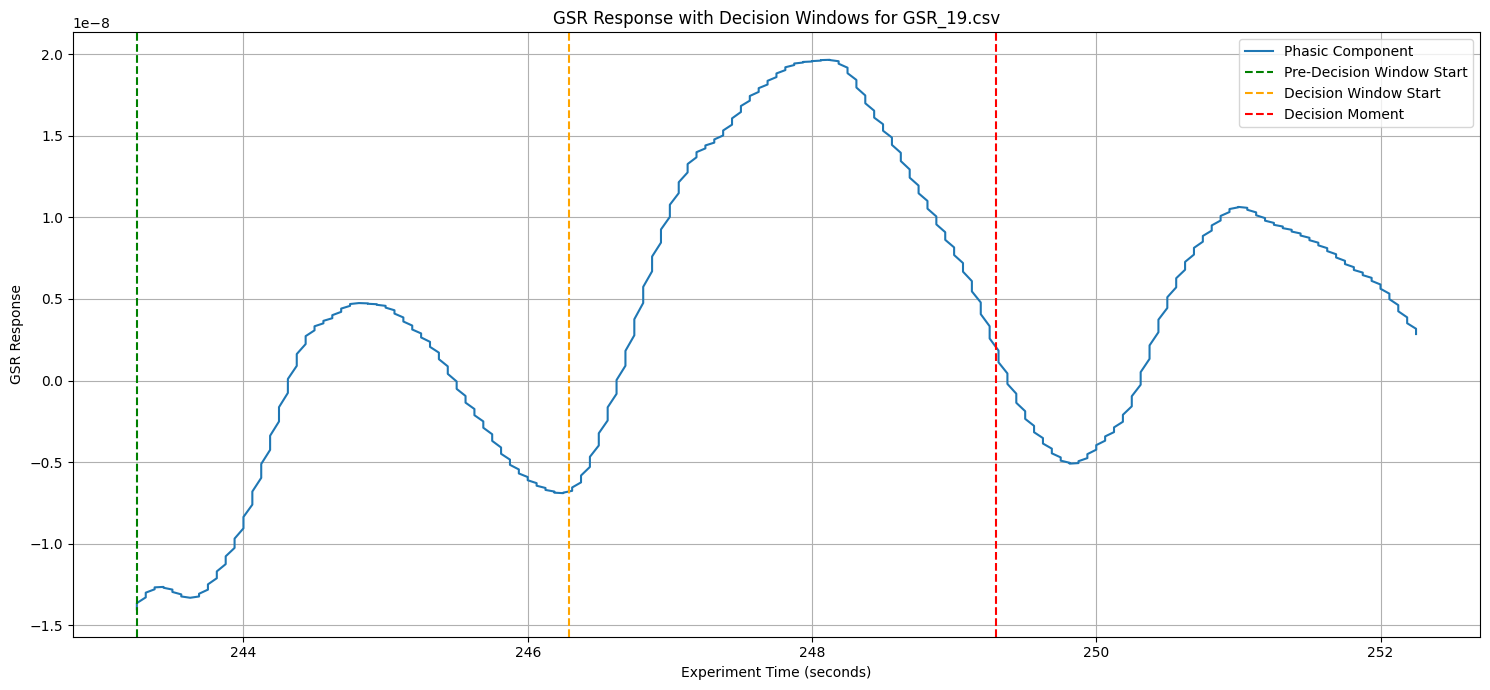


Processing file 19/78: /content/gsr_data/GSR_20.csv
Difference between expected and raw duration: 2.94 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.005667  0.008057      0.004444
max_phasic     0.003973  0.005729      0.003983


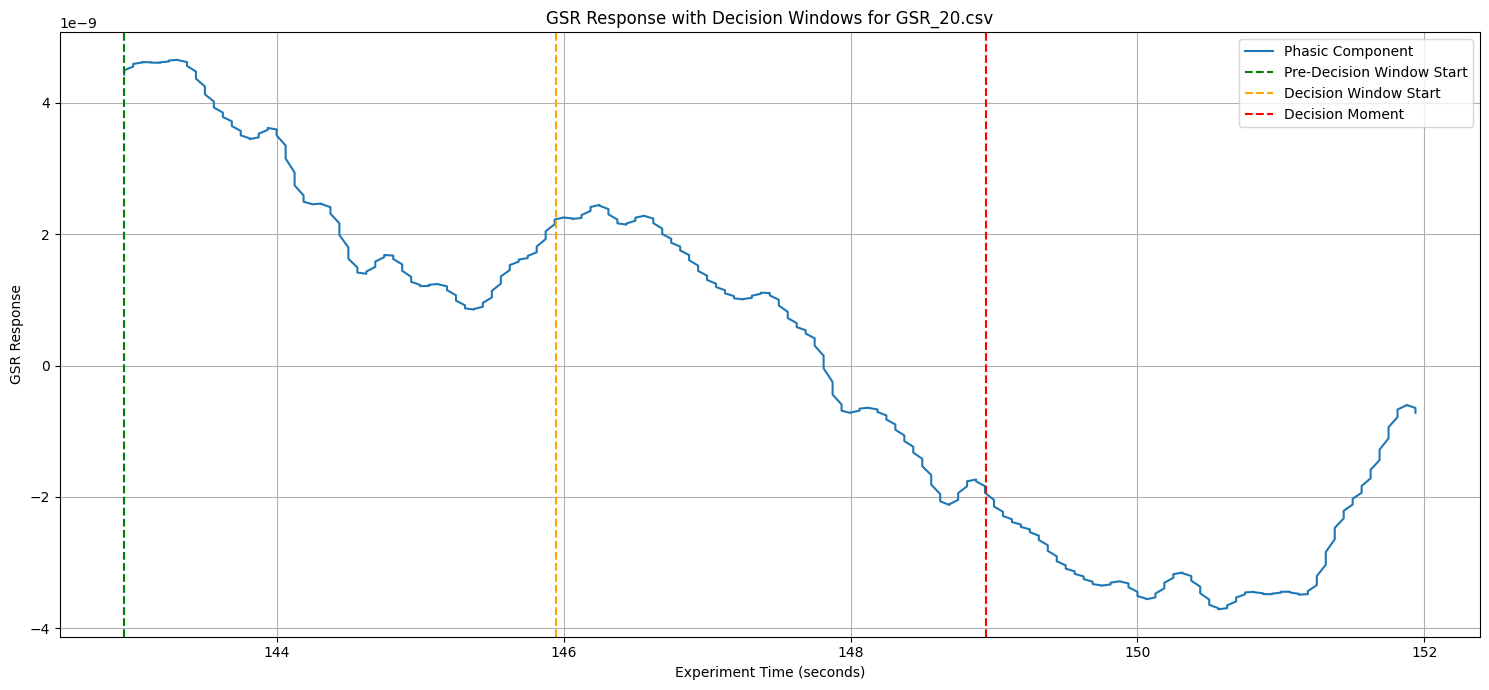


Processing file 20/78: /content/gsr_data/GSR_21.csv
Difference between expected and raw duration: 3.12 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.001446  0.001203      0.001571
max_phasic     0.001329  0.001251      0.001275


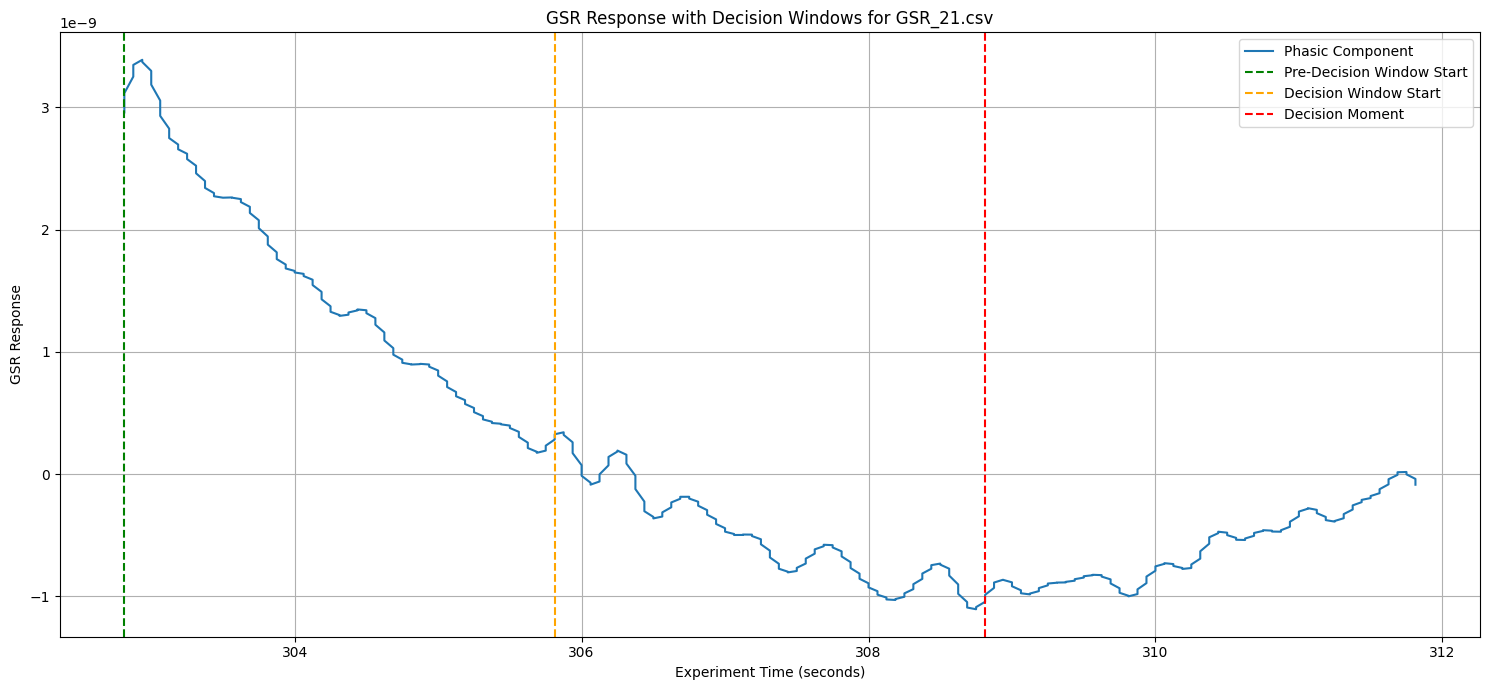


Processing file 21/78: /content/gsr_data/GSR_23.csv
Difference between expected and raw duration: 3.62 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.002300  0.002636      0.001418
max_phasic     0.001769  0.001748      0.001136


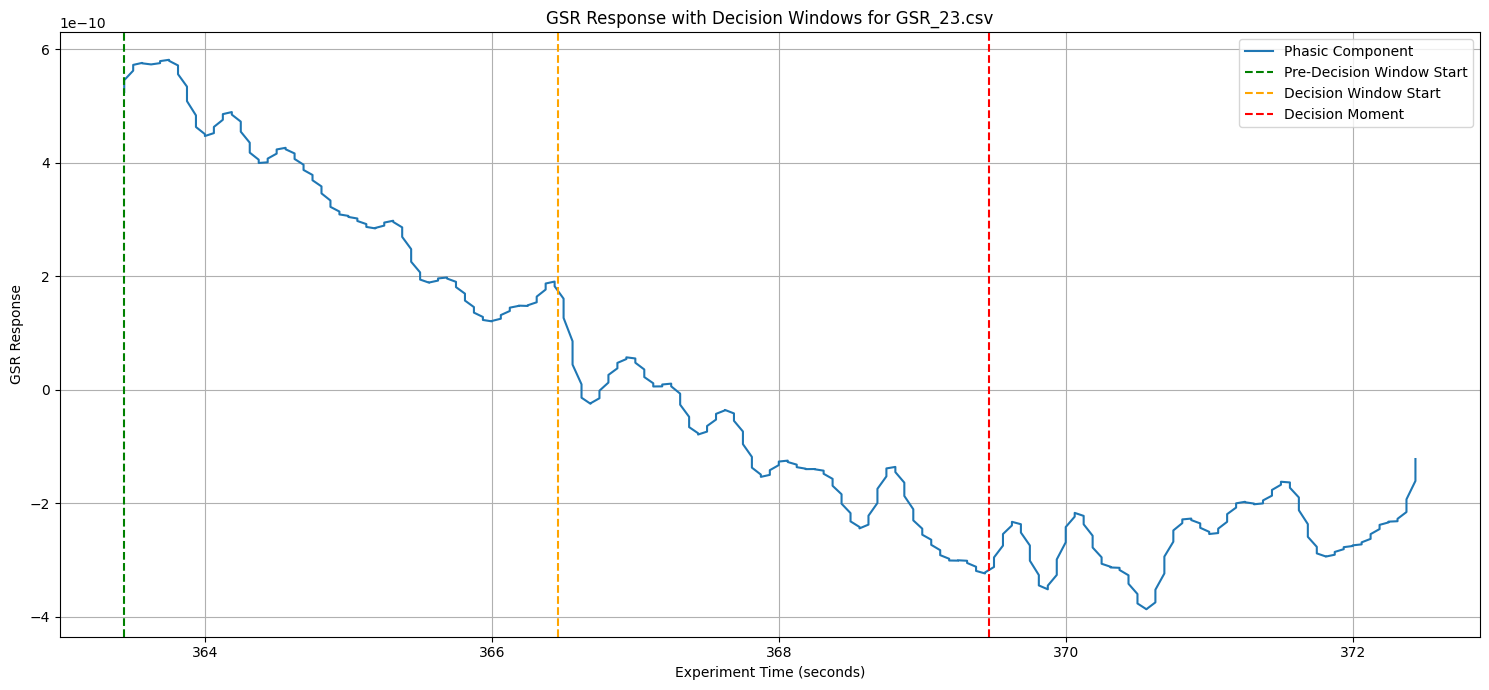


Processing file 22/78: /content/gsr_data/GSR_24.csv
Difference between expected and raw duration: 3.38 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.000336  0.000202      0.000451
max_phasic     0.000283  0.000259      0.000361


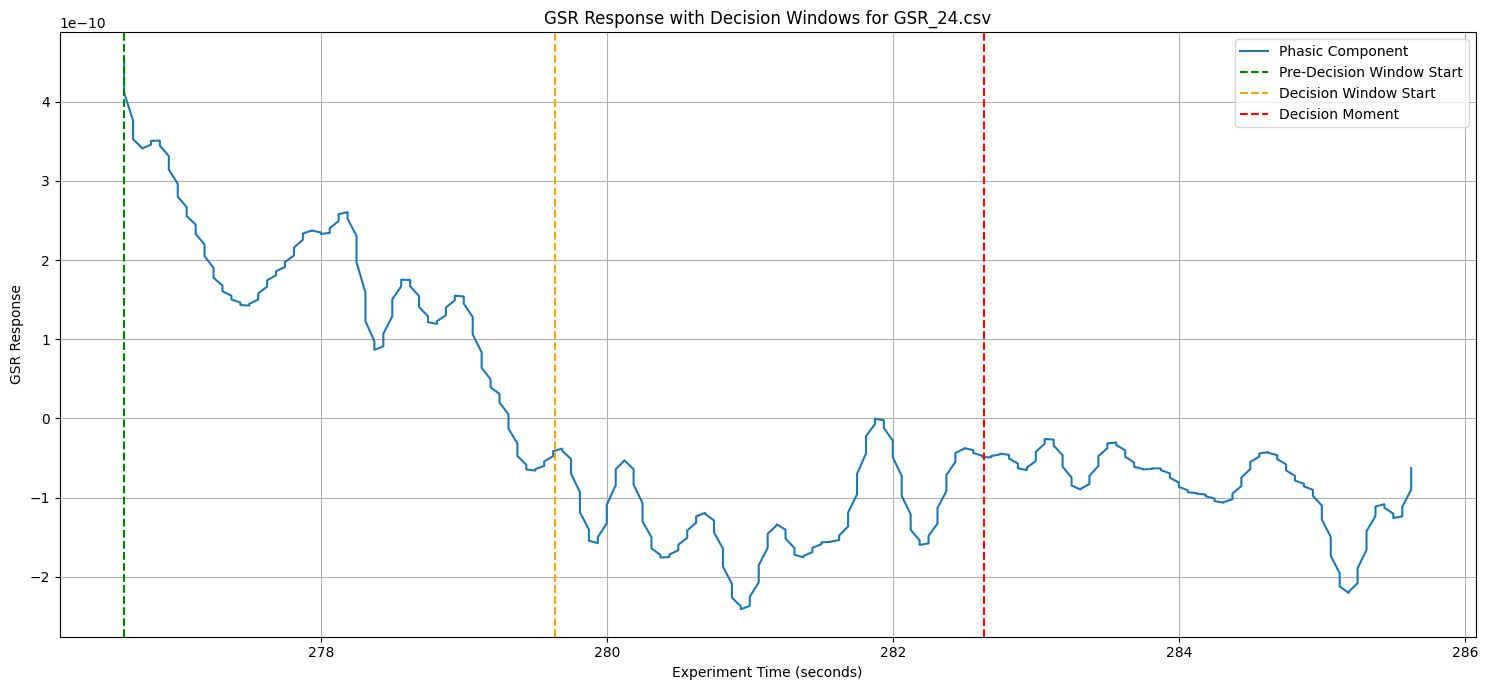


Processing file 23/78: /content/gsr_data/GSR_25.csv
Difference between expected and raw duration: 87146.12 seconds
required sequences are not in the dataframe    
AUC:
 None
                                                                   Not applicable data found for the specified time window.

Processing file 24/78: /content/gsr_data/GSR_26.csv
Difference between expected and raw duration: 3.00 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.003405  0.002533      0.016973
max_phasic     0.002063  0.001676      0.008799


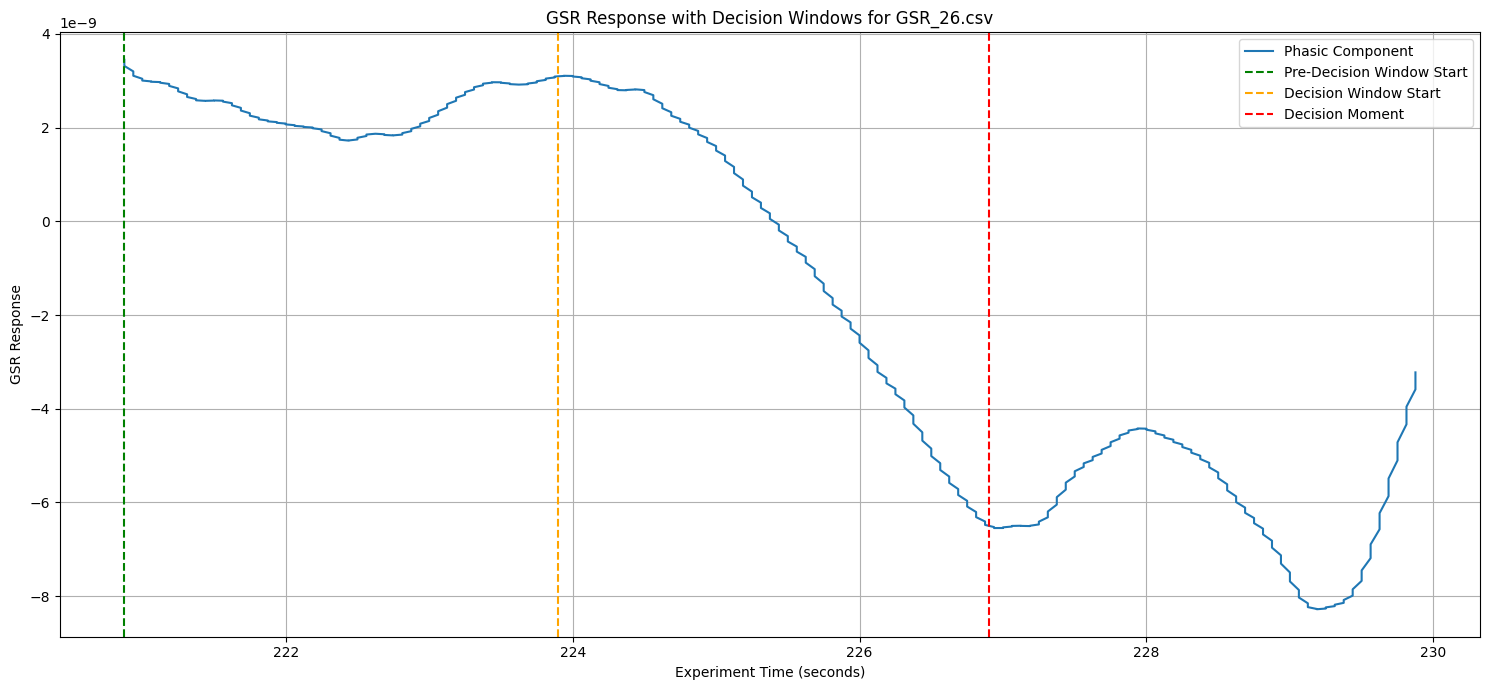


Processing file 25/78: /content/gsr_data/GSR_27.csv
Difference between expected and raw duration: 96976.12 seconds
required sequences are not in the dataframe    
AUC:
 None
                                                                   Not applicable data found for the specified time window.

Processing file 26/78: /content/gsr_data/GSR_28.csv
Difference between expected and raw duration: 2.75 seconds
Error processing EDA signal: zero-size array to reduction operation maximum which has no identity
AUC:
 None
                                                                   Data segment too short for processing. Skipping file.

Processing file 27/78: /content/gsr_data/GSR_29.csv
Difference between expected and raw duration: 2.56 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.010466  0.008343      0.103254
max_phasic     0.008786  0.008687      0.065857


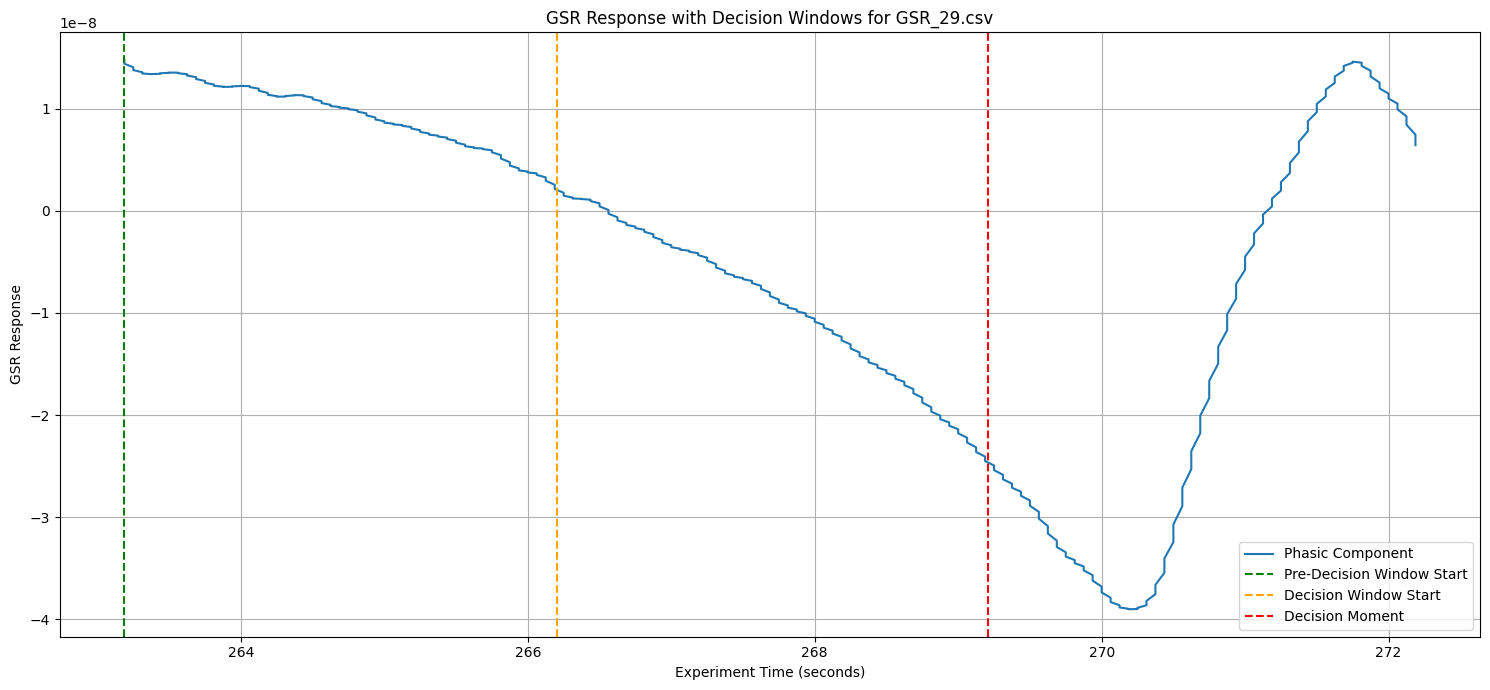


Processing file 28/78: /content/gsr_data/GSR_30.csv
Difference between expected and raw duration: 2.69 seconds


/usr/local/lib/python3.12/dist-packages/neurokit2/eda/eda_peaks.py:127: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])


AUC:
             predecision  decision  postdecision
net_phasic     0.021305  0.032964      0.037195
max_phasic     0.012013  0.018521      0.022324


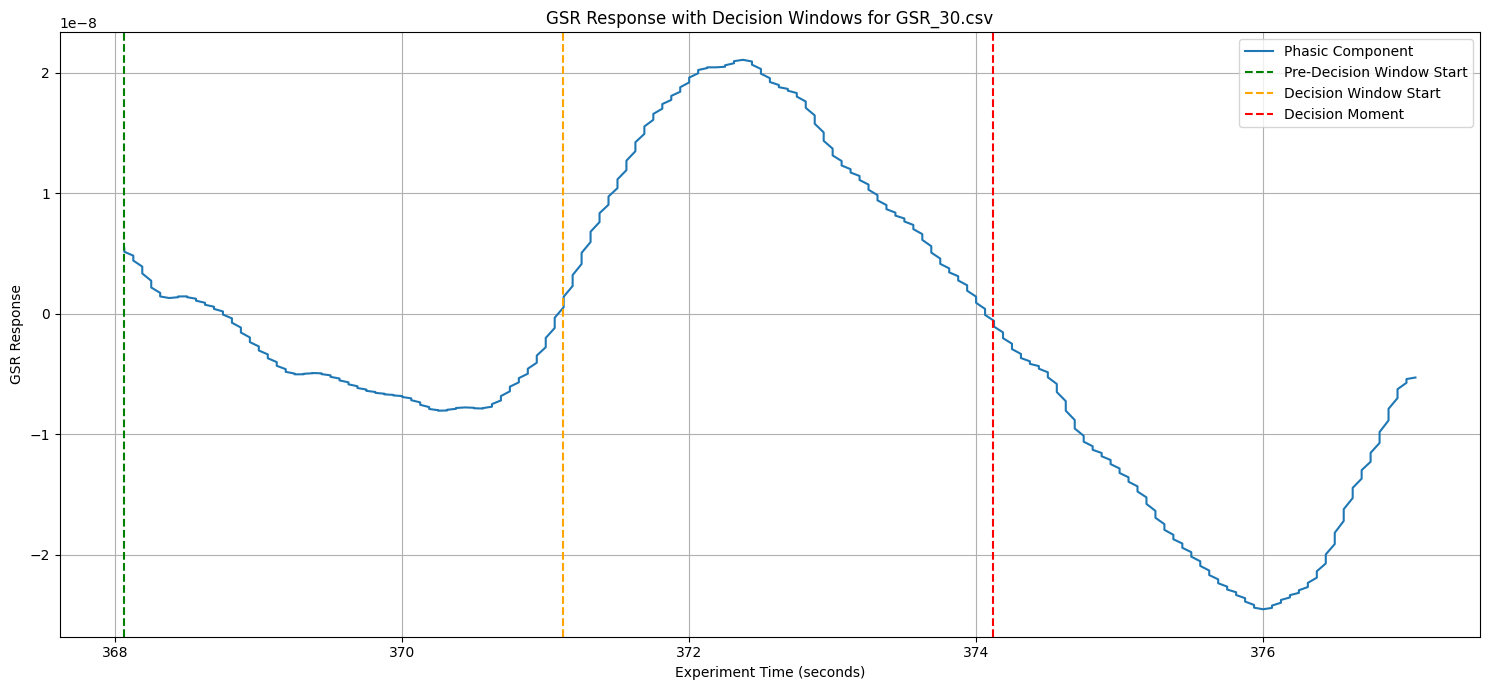


Processing file 29/78: /content/gsr_data/GSR_31.csv
Difference between expected and raw duration: 2.00 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.000762  0.000685      0.005949
max_phasic     0.000586  0.000665      0.003730


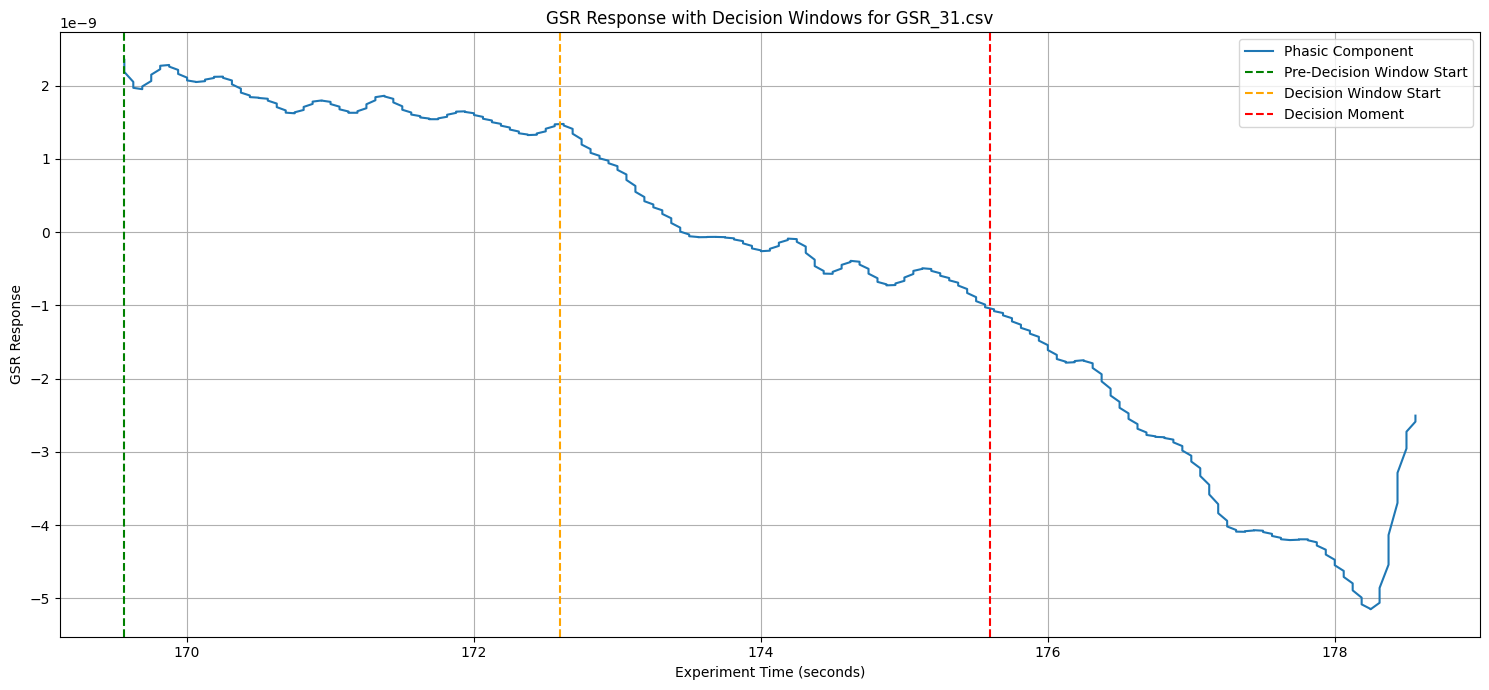


Processing file 30/78: /content/gsr_data/GSR_32.csv
Difference between expected and raw duration: 3.00 seconds
Error processing EDA signal: zero-size array to reduction operation maximum which has no identity
AUC:
 None
                                                                   Data segment too short for processing. Skipping file.

Processing file 31/78: /content/gsr_data/GSR_33.csv
Difference between expected and raw duration: 2.00 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.003267  0.006476      0.003914
max_phasic     0.003365  0.003517      0.002556


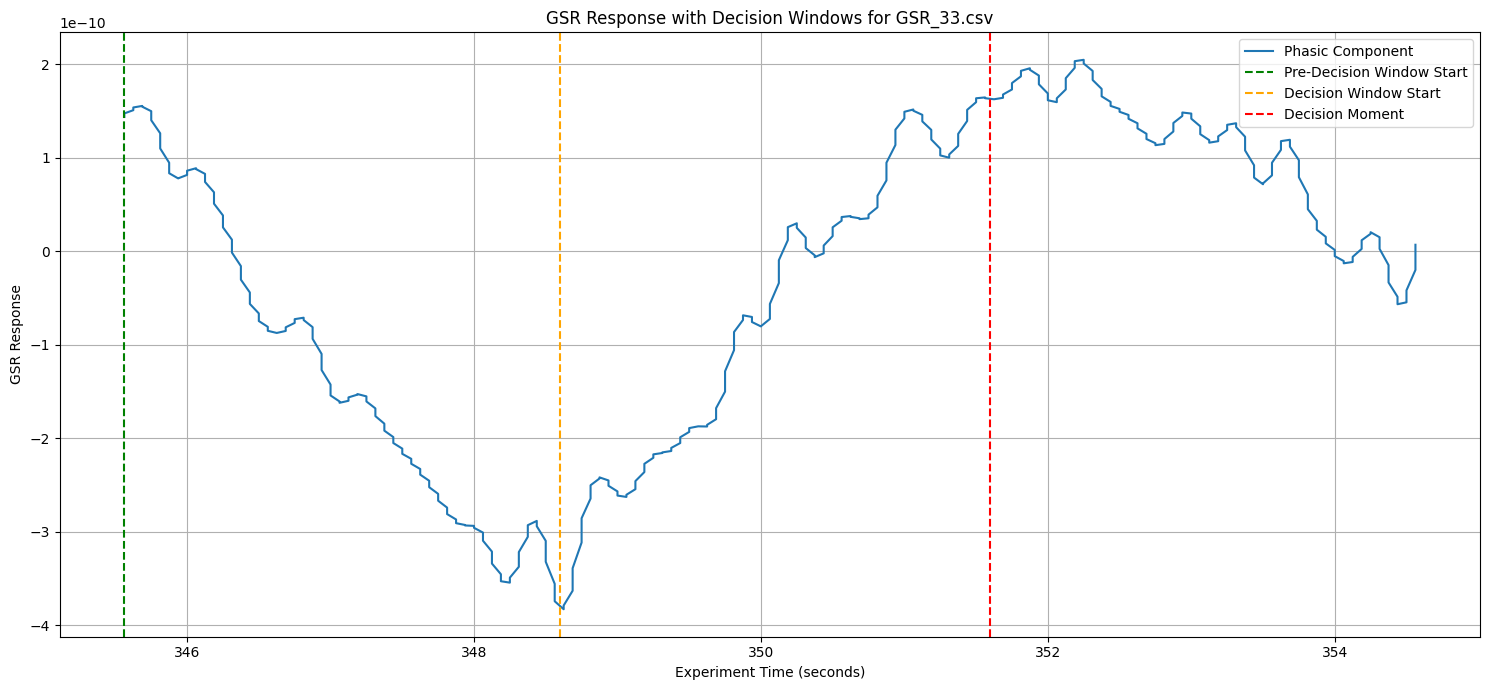


Processing file 32/78: /content/gsr_data/GSR_34.csv
Difference between expected and raw duration: 2.38 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.006481  0.011854      0.008777
max_phasic     0.007483  0.006578      0.006802


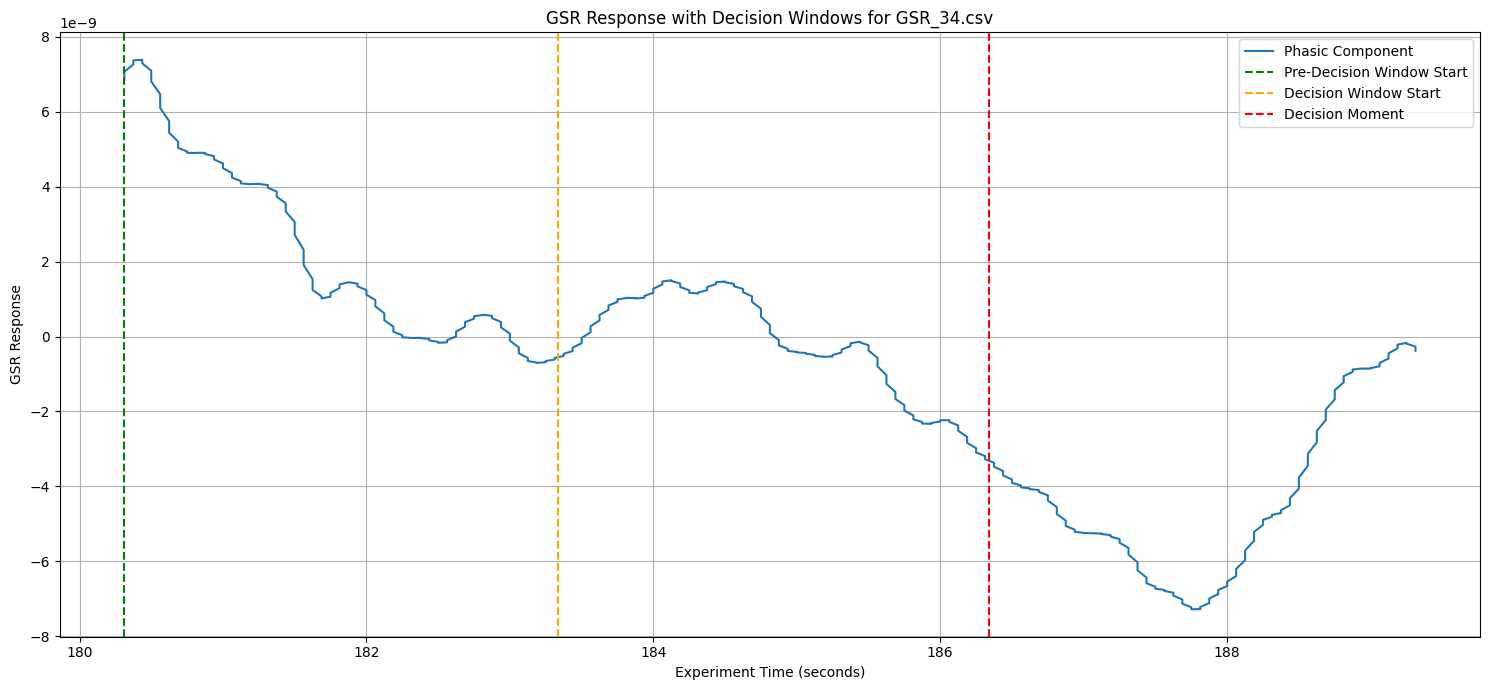


Processing file 33/78: /content/gsr_data/GSR_35.csv
Difference between expected and raw duration: 2.81 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.001177  0.000551      0.001238
max_phasic     0.001167  0.000545      0.000856


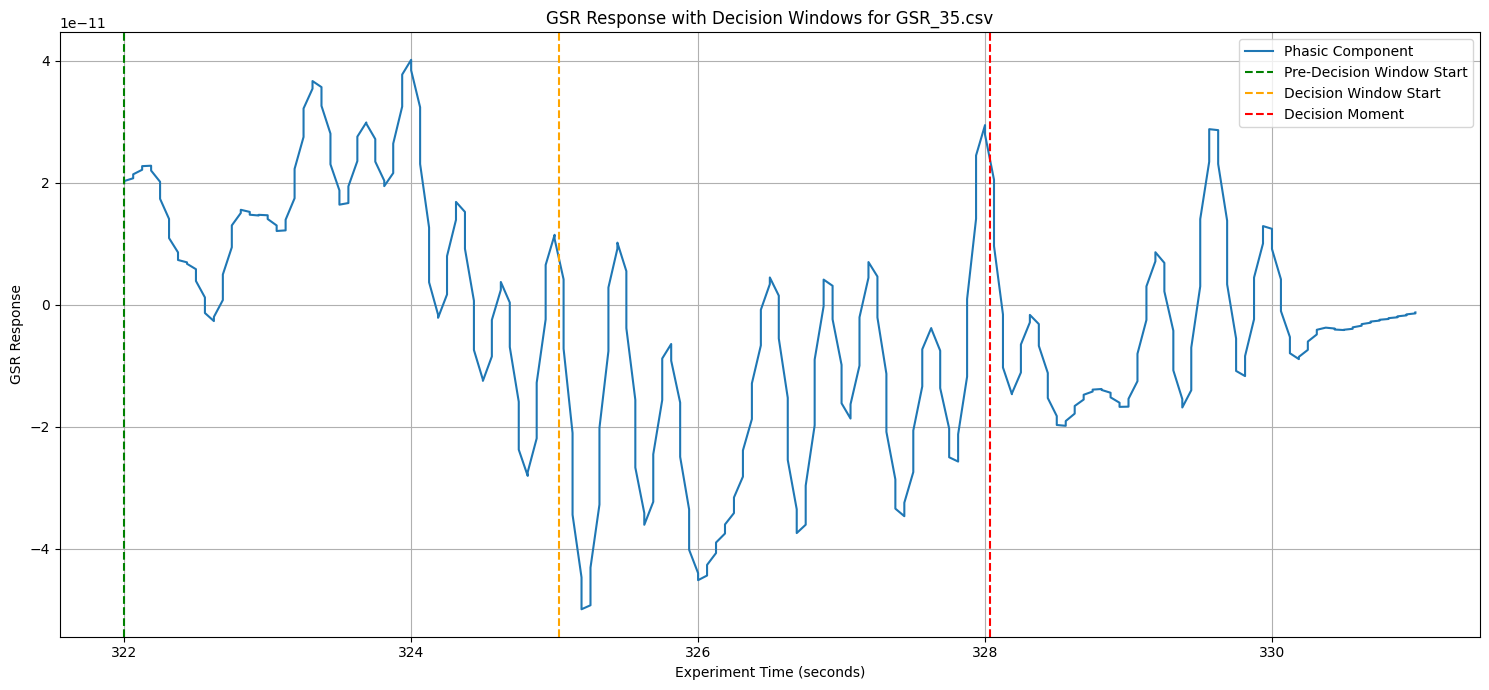


Processing file 34/78: /content/gsr_data/GSR_36.csv
Difference between expected and raw duration: 4.12 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.010059  0.024185      0.016531
max_phasic     0.006440  0.012938      0.009021


/usr/local/lib/python3.12/dist-packages/neurokit2/eda/eda_peaks.py:127: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])
/usr/local/lib/python3.12/dist-packages/neurokit2/eda/eda_peaks.py:127: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])


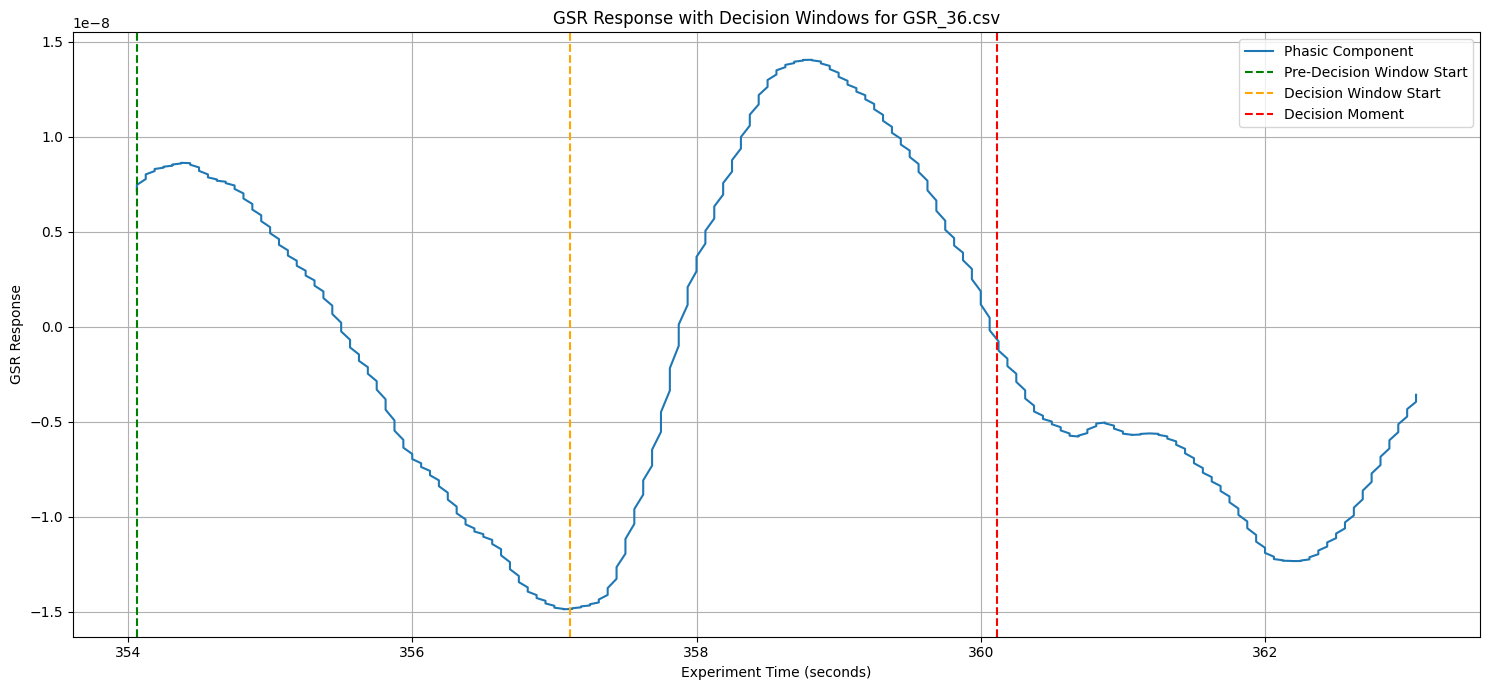


Processing file 35/78: /content/gsr_data/GSR_37.csv
Difference between expected and raw duration: 2.44 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.002894  0.002714      0.007918
max_phasic     0.002048  0.001876      0.003261


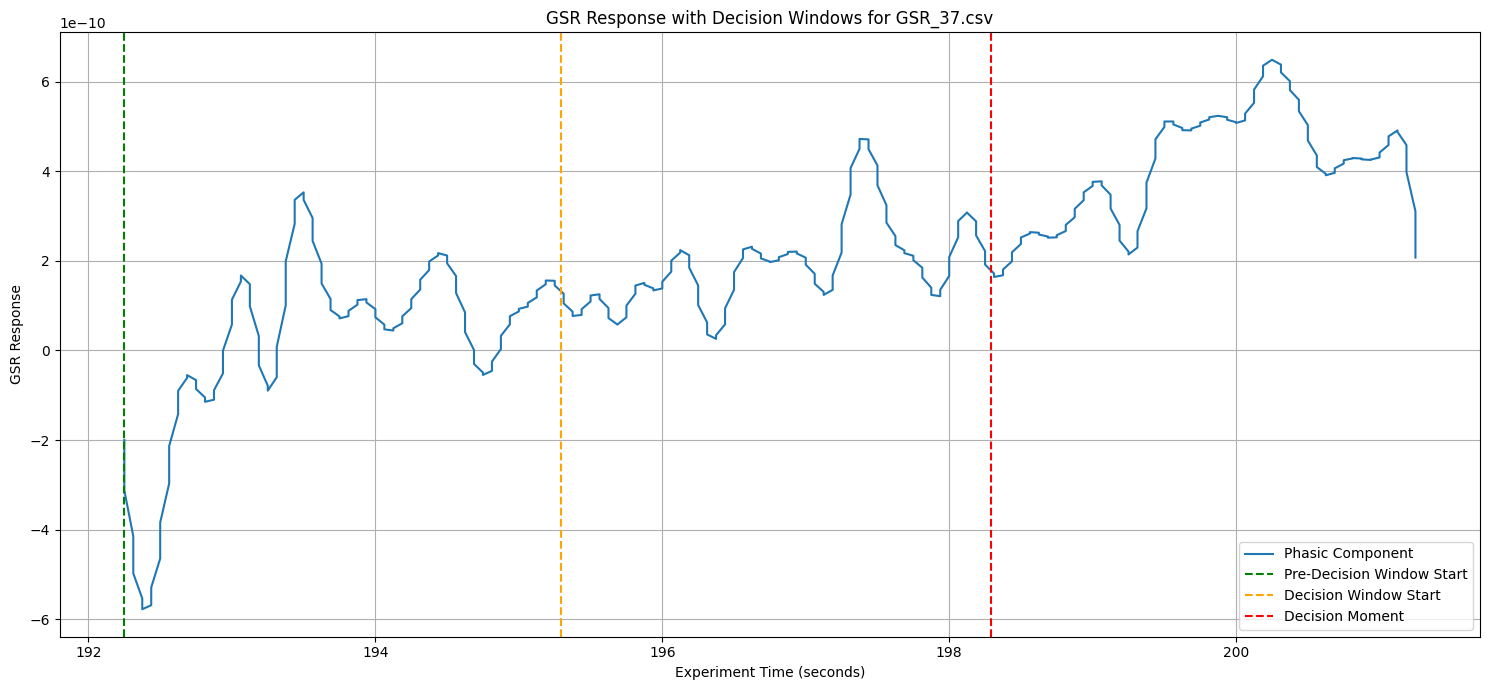


Processing file 36/78: /content/gsr_data/GSR_38.csv
Difference between expected and raw duration: 16.44 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.009994  0.014105      0.007400
max_phasic     0.005359  0.007522      0.006652


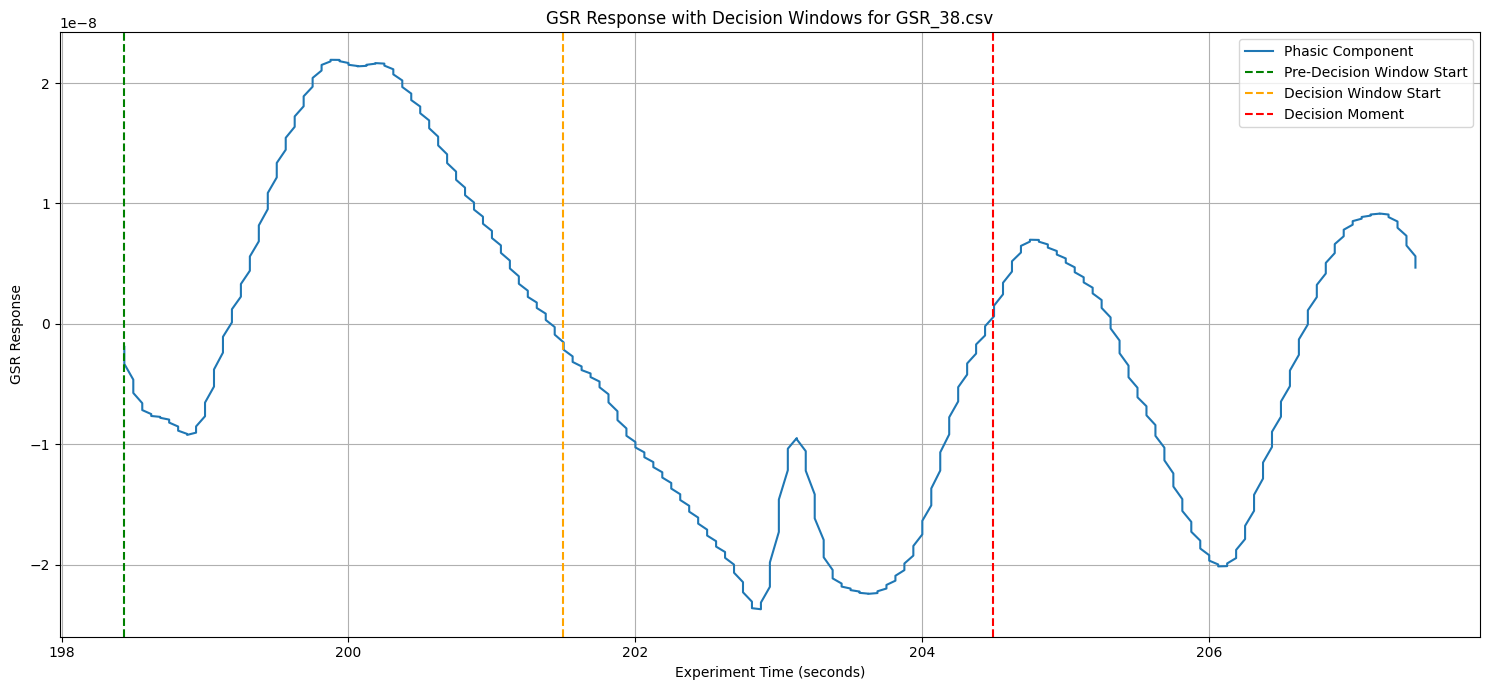


Processing file 37/78: /content/gsr_data/GSR_39.csv
Difference between expected and raw duration: 3.44 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.002438  0.001719       0.03019
max_phasic     0.001826  0.001680       0.01763


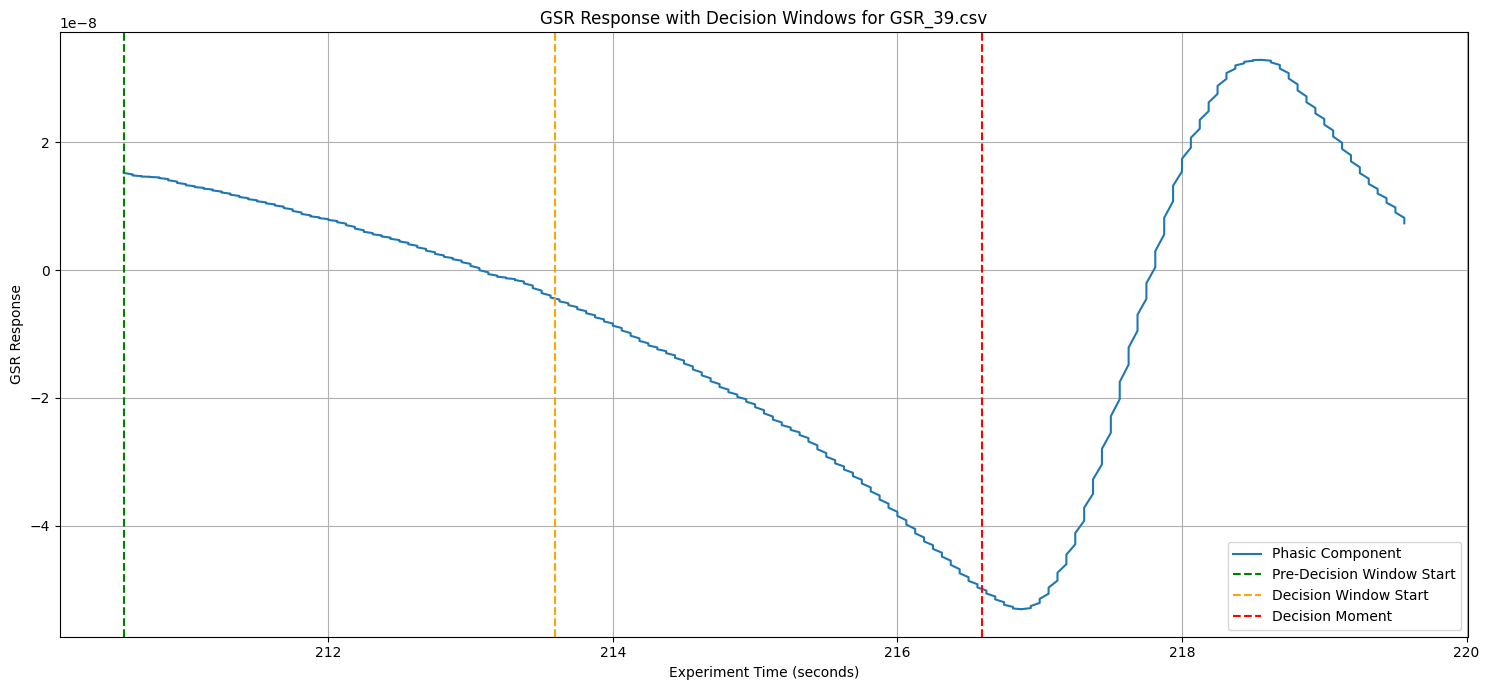


Processing file 38/78: /content/gsr_data/GSR_40.csv
Difference between expected and raw duration: 4.25 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.006395  0.005130      0.005015
max_phasic     0.004958  0.005049      0.004278


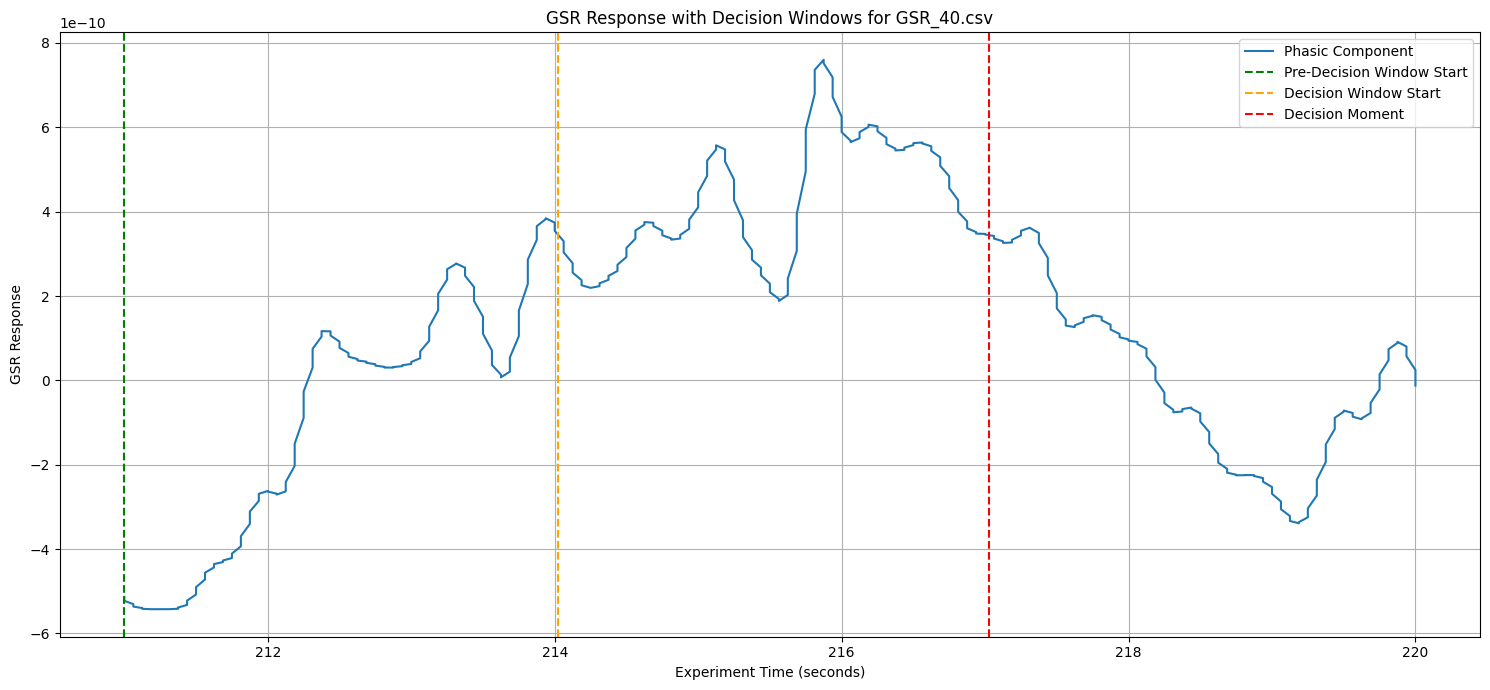


Processing file 39/78: /content/gsr_data/GSR_41.csv
Difference between expected and raw duration: 7.88 seconds
Error processing EDA signal: zero-size array to reduction operation maximum which has no identity


/usr/local/lib/python3.12/dist-packages/neurokit2/eda/eda_peaks.py:127: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])


AUC:
 None
                                                                   Data segment too short for processing. Skipping file.

Processing file 40/78: /content/gsr_data/GSR_42.csv
Difference between expected and raw duration: 4.06 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.004996  0.002709      0.009797
max_phasic     0.003733  0.002878      0.006400


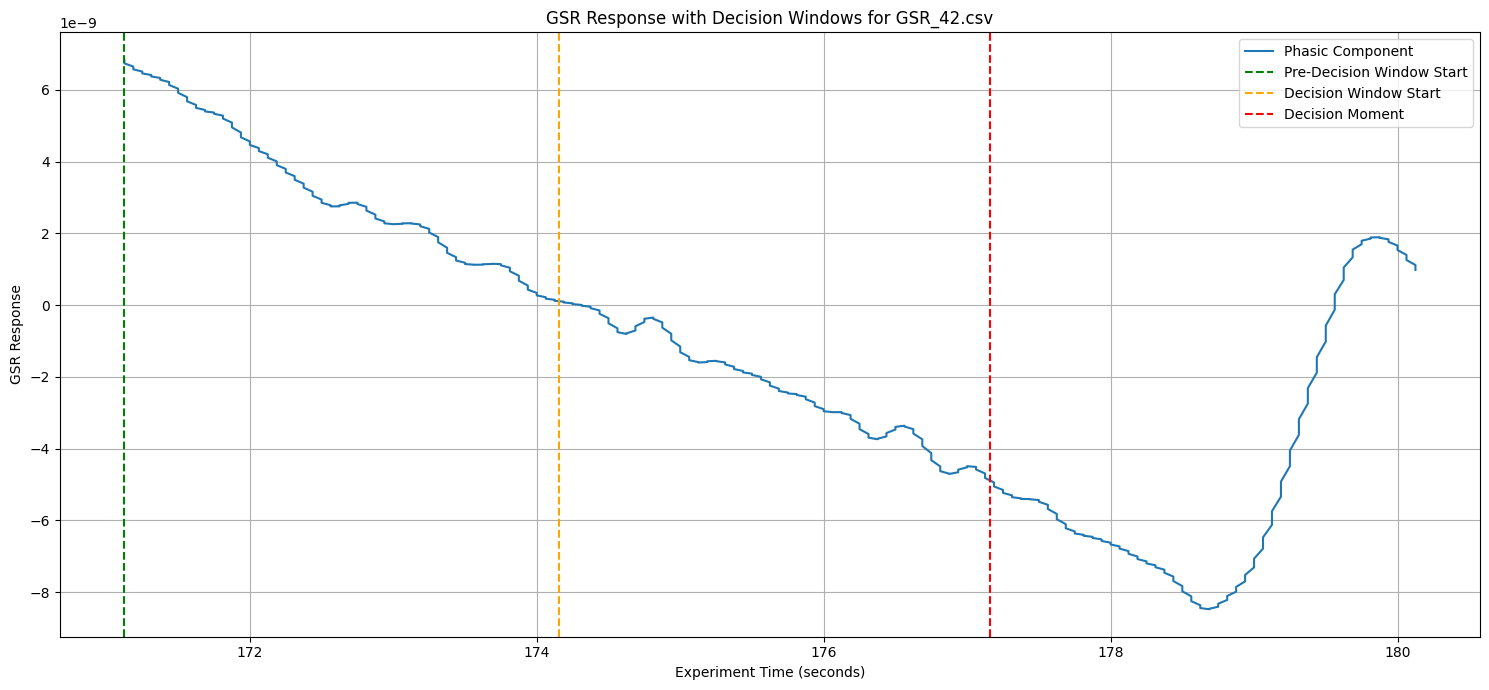


Processing file 41/78: /content/gsr_data/GSR_43.csv
Difference between expected and raw duration: 4.94 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.007126  0.004583      0.002702
max_phasic     0.004632  0.004910      0.003367


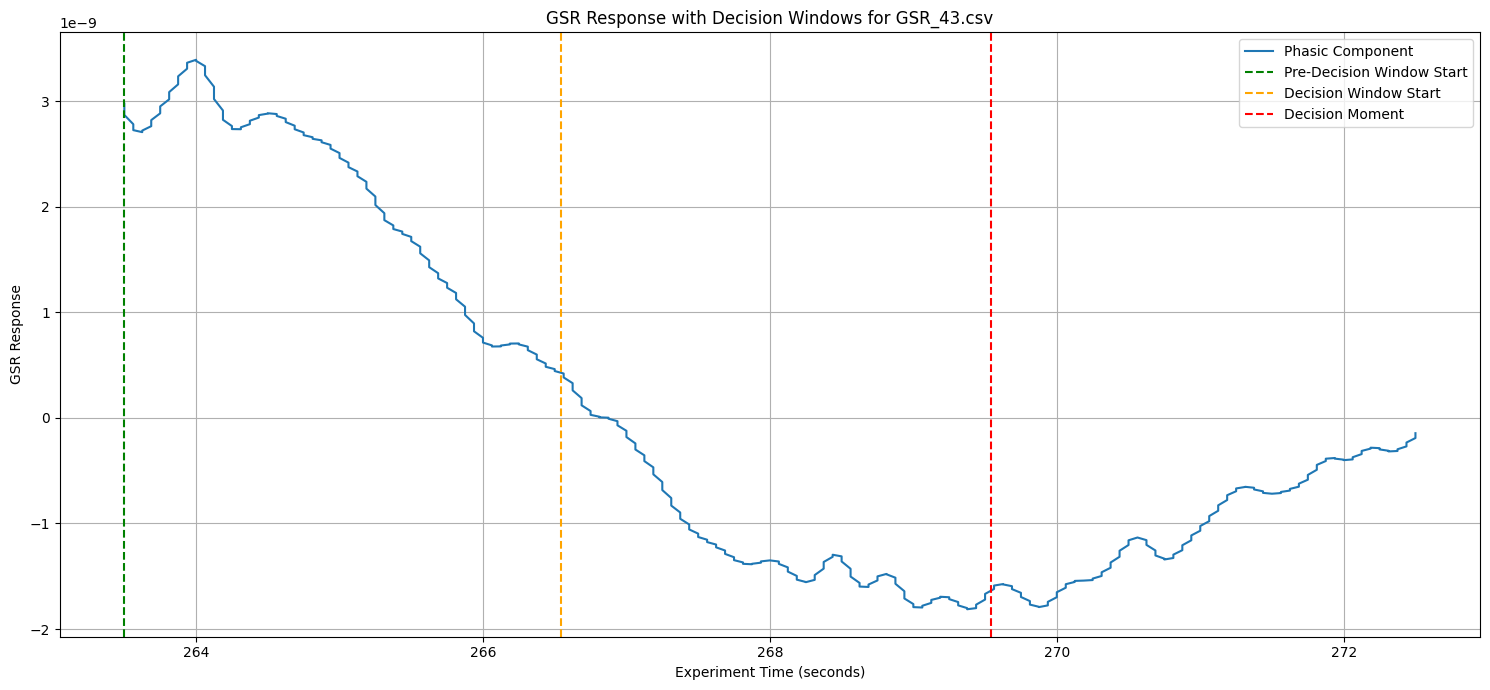


Processing file 42/78: /content/gsr_data/GSR_44.csv
Difference between expected and raw duration: 3.69 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.018732  0.029646      0.011664
max_phasic     0.017825  0.014065      0.009336


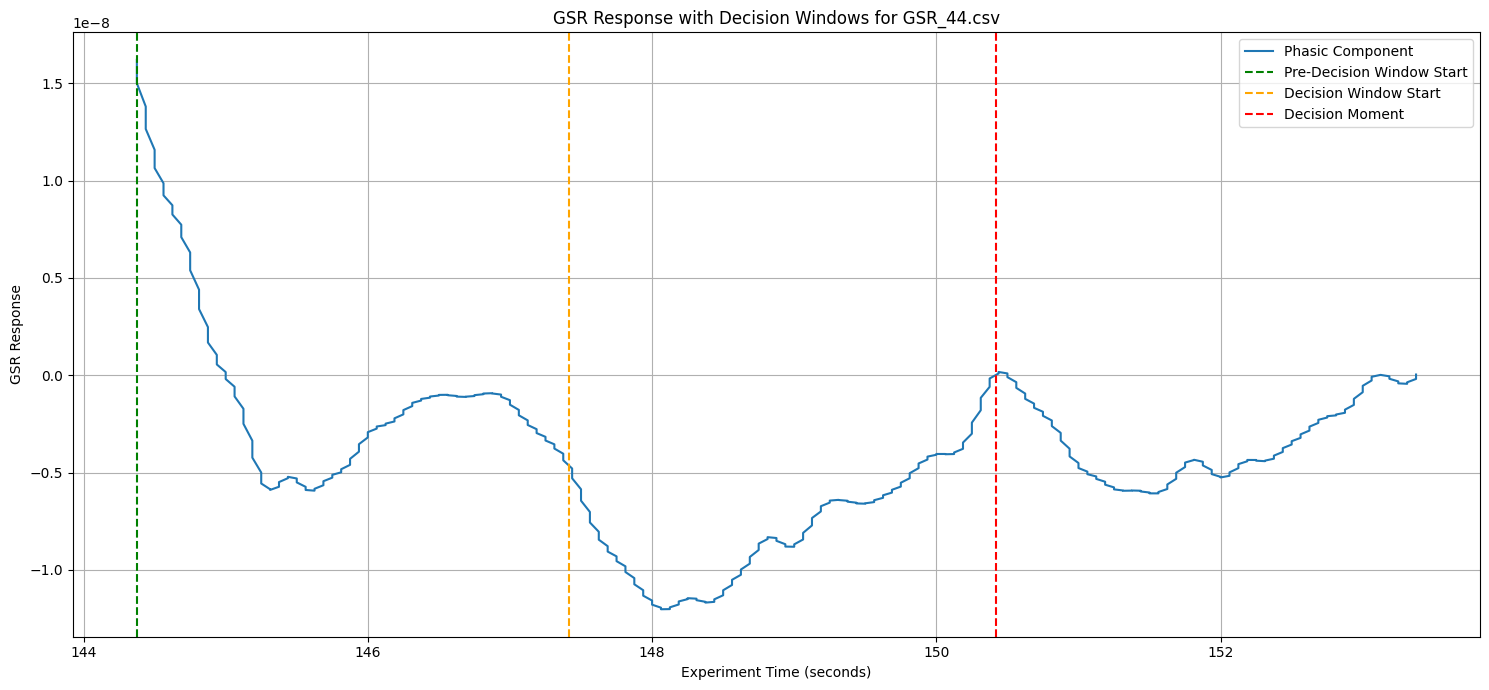


Processing file 43/78: /content/gsr_data/GSR_45.csv
Difference between expected and raw duration: 2.94 seconds
Error processing EDA signal: zero-size array to reduction operation maximum which has no identity
AUC:
 None
                                                                   Data segment too short for processing. Skipping file.

Processing file 44/78: /content/gsr_data/GSR_46.csv
Difference between expected and raw duration: 4.19 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.003883  0.002609      0.003136
max_phasic     0.002463  0.002186      0.002384


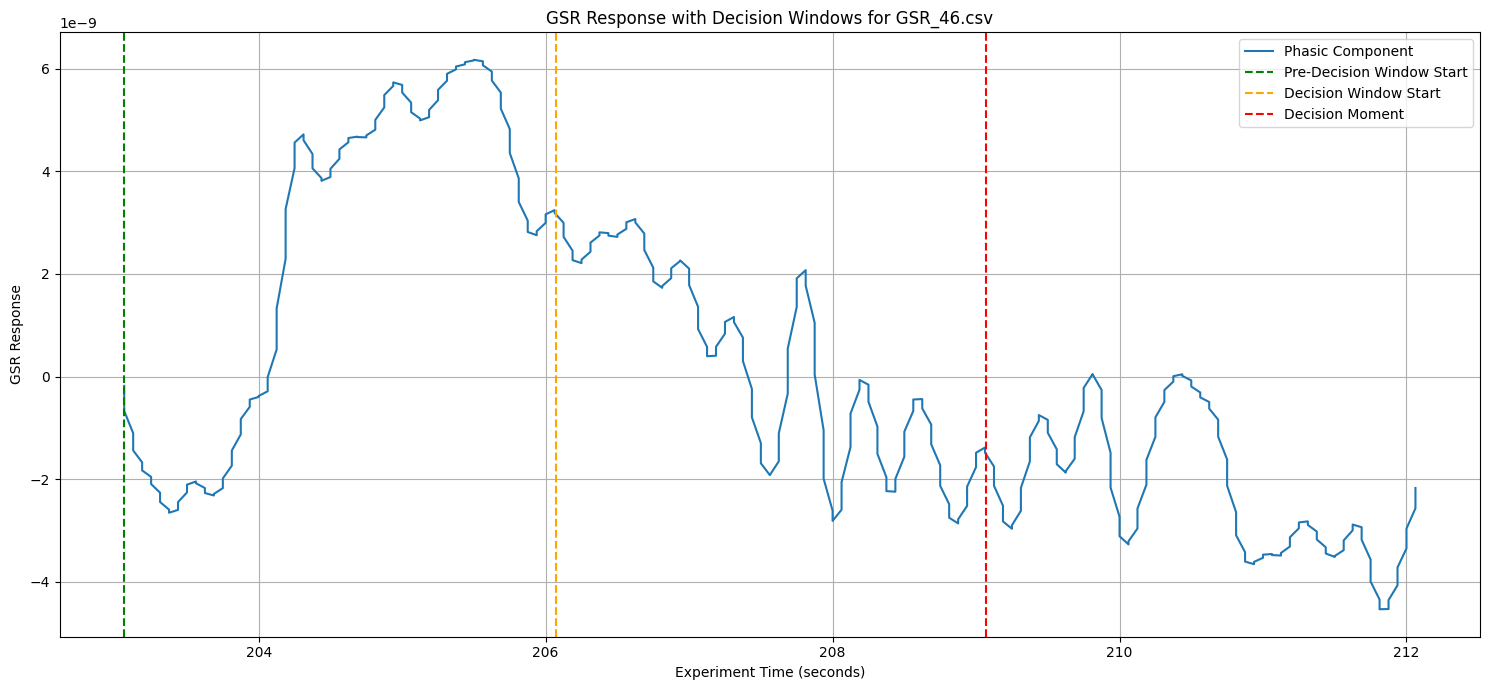


Processing file 45/78: /content/gsr_data/GSR_47.csv
Difference between expected and raw duration: 4.38 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.000760  0.003590      0.009721
max_phasic     0.001136  0.001985      0.006603


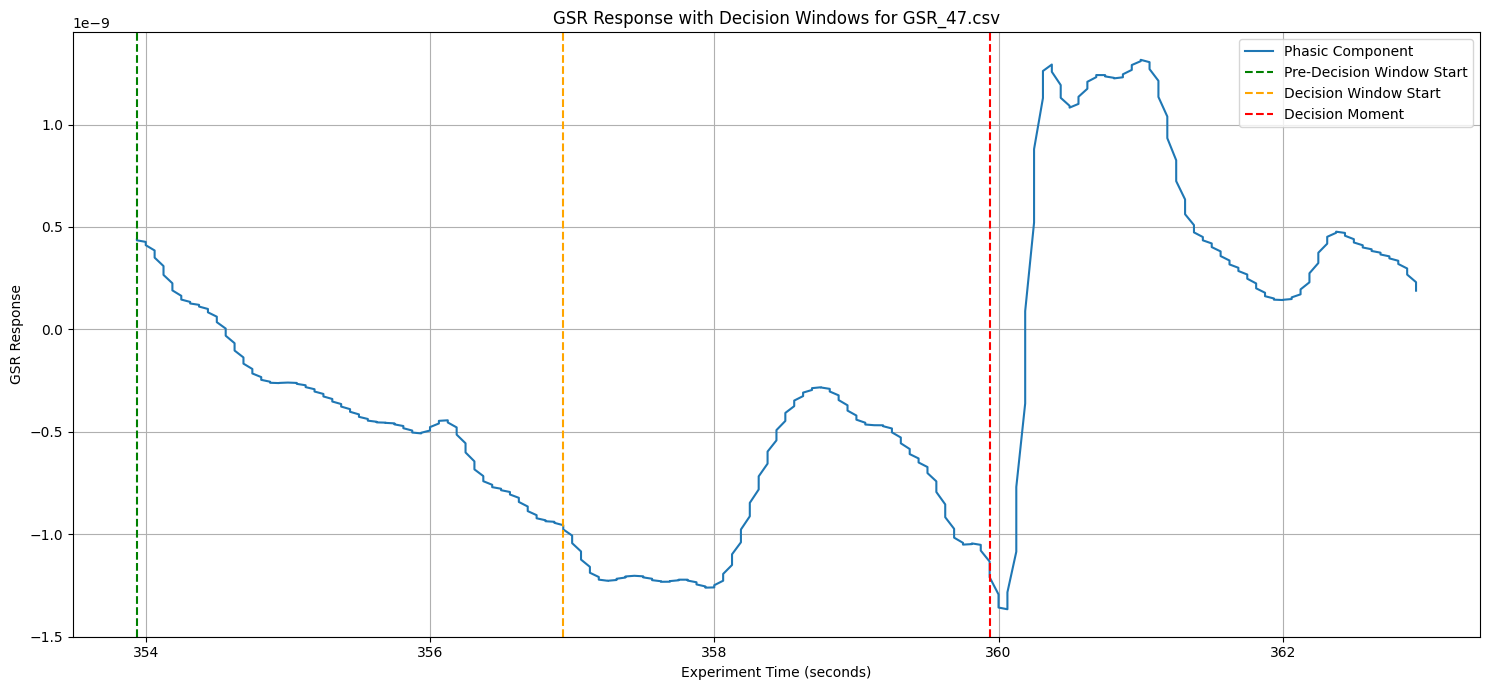


Processing file 46/78: /content/gsr_data/GSR_48.csv
Difference between expected and raw duration: 3.81 seconds
required sequences are not in the dataframe    
AUC:
 None
                                                                   Not applicable data found for the specified time window.

Processing file 47/78: /content/gsr_data/GSR_49.csv
Difference between expected and raw duration: 3.88 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.005542  0.000738      0.001060
max_phasic     0.003469  0.000640      0.000696


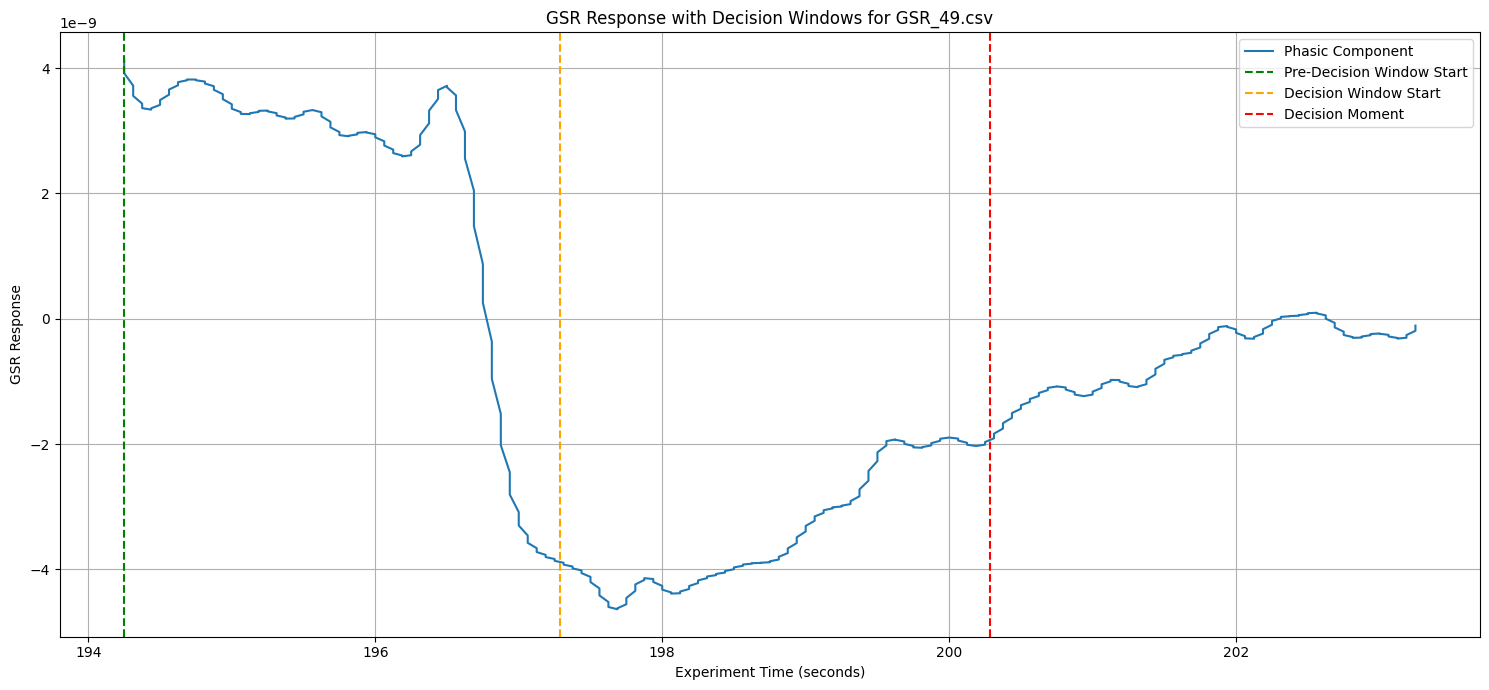


Processing file 48/78: /content/gsr_data/GSR_50.csv
Difference between expected and raw duration: 92456.06 seconds
required sequences are not in the dataframe    
AUC:
 None
                                                                   Not applicable data found for the specified time window.

Processing file 49/78: /content/gsr_data/GSR_51.csv
Difference between expected and raw duration: 3.06 seconds


/usr/local/lib/python3.12/dist-packages/neurokit2/eda/eda_peaks.py:127: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])


AUC:
             predecision  decision  postdecision
net_phasic     0.021352  0.019333      0.049573
max_phasic     0.018297  0.017954      0.030777


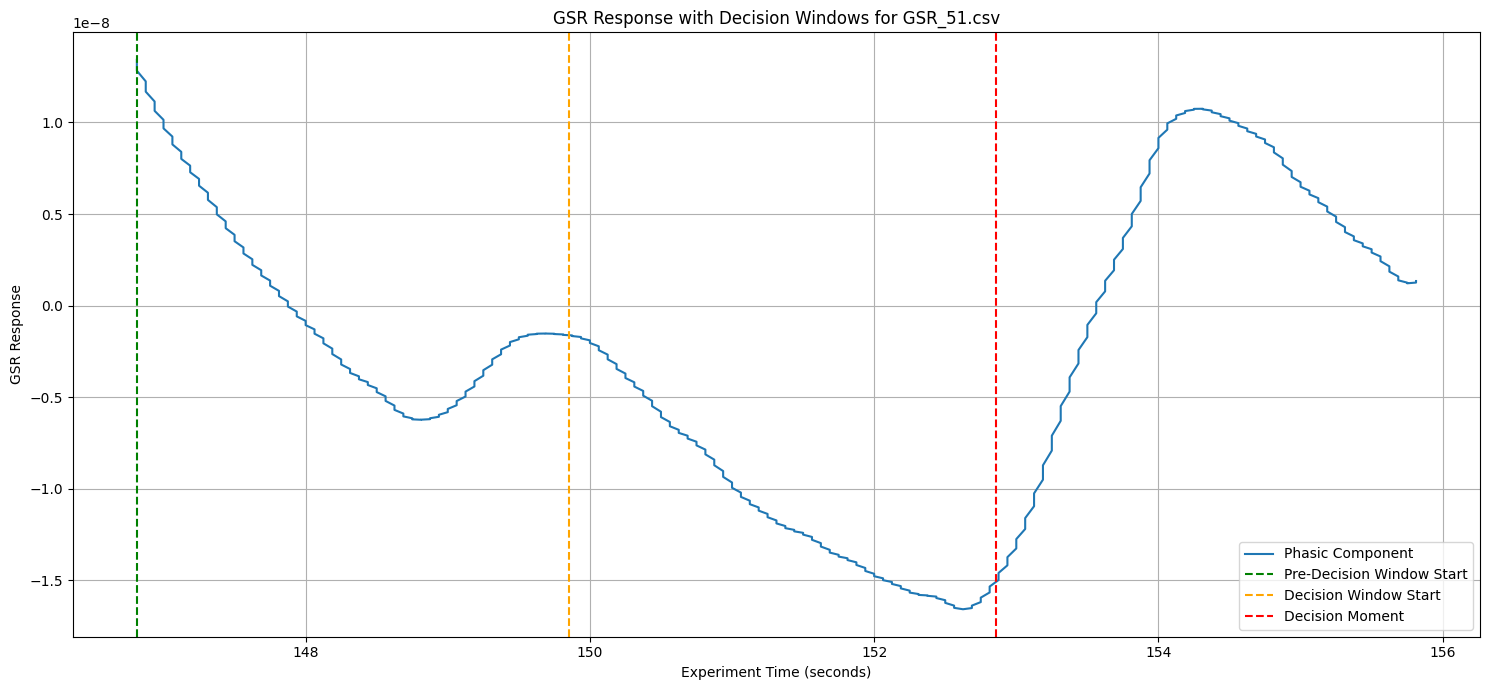


Processing file 50/78: /content/gsr_data/GSR_52.csv
Difference between expected and raw duration: 4.56 seconds
AUC:
              predecision      decision  postdecision
net_phasic  1.039203e-09  5.088084e-09  3.686493e-09
max_phasic  1.845748e-09  3.189719e-09  2.778515e-09


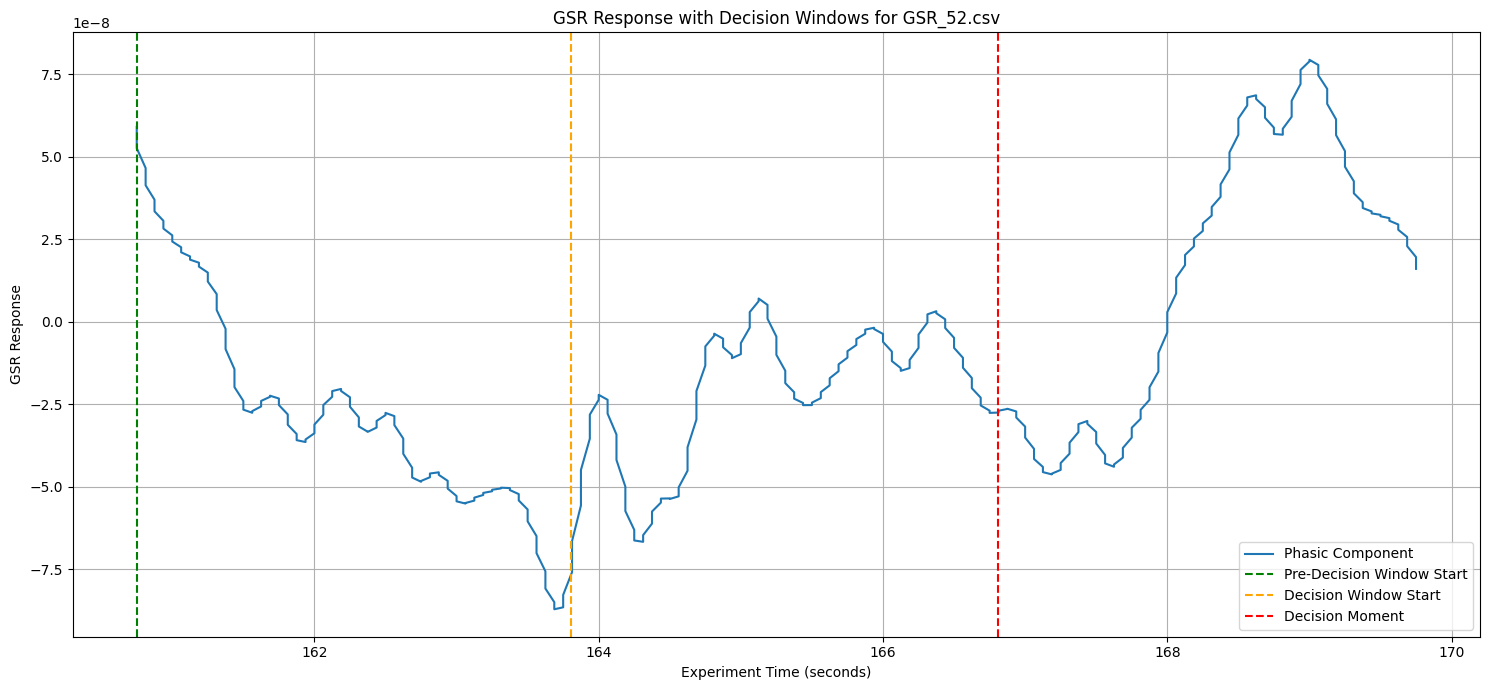


Processing file 51/78: /content/gsr_data/GSR_53.csv
Difference between expected and raw duration: 97710.25 seconds
required sequences are not in the dataframe    
AUC:
 None
                                                                   Not applicable data found for the specified time window.

Processing file 52/78: /content/gsr_data/GSR_54.csv
Difference between expected and raw duration: 4.31 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.001649  0.000552      0.001509
max_phasic     0.001285  0.000346      0.000849


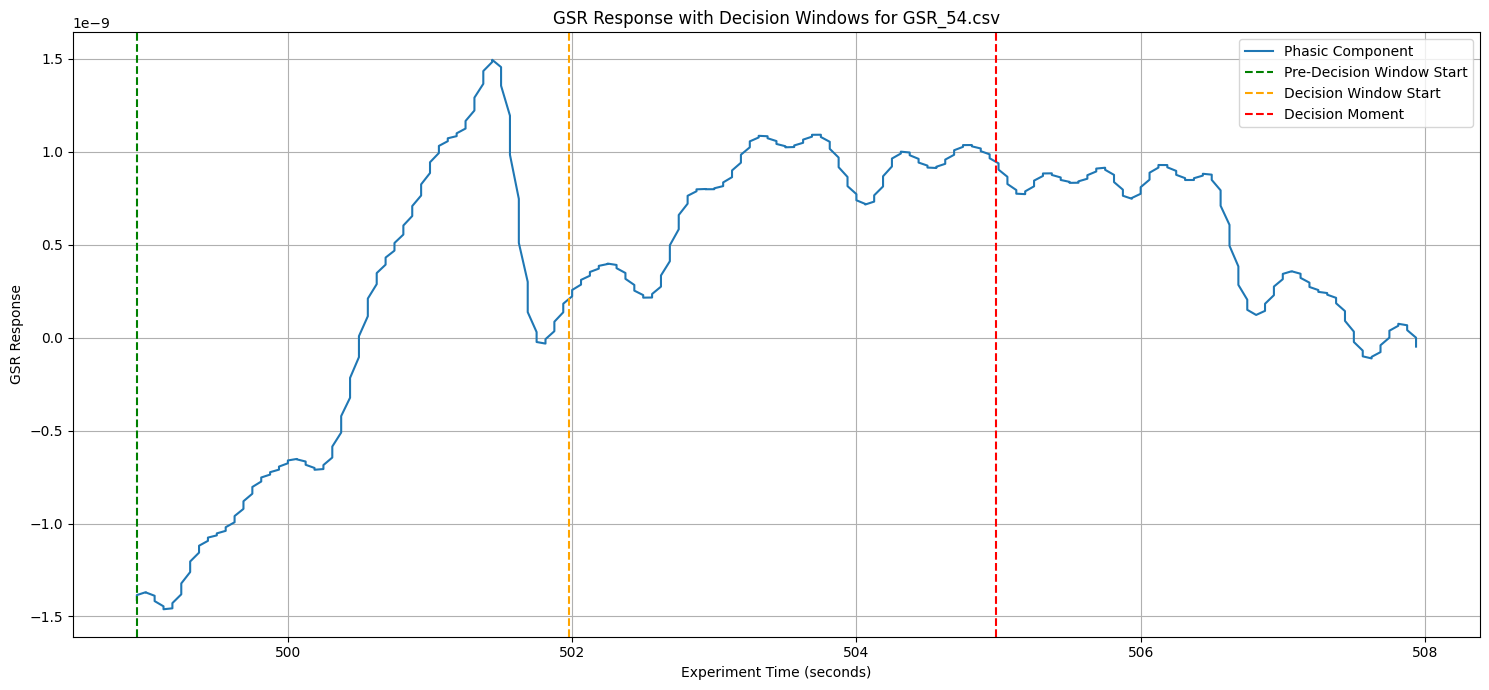


Processing file 53/78: /content/gsr_data/GSR_55.csv
Difference between expected and raw duration: 3.06 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.022492  0.009020      0.006867
max_phasic     0.014540  0.006894      0.006206


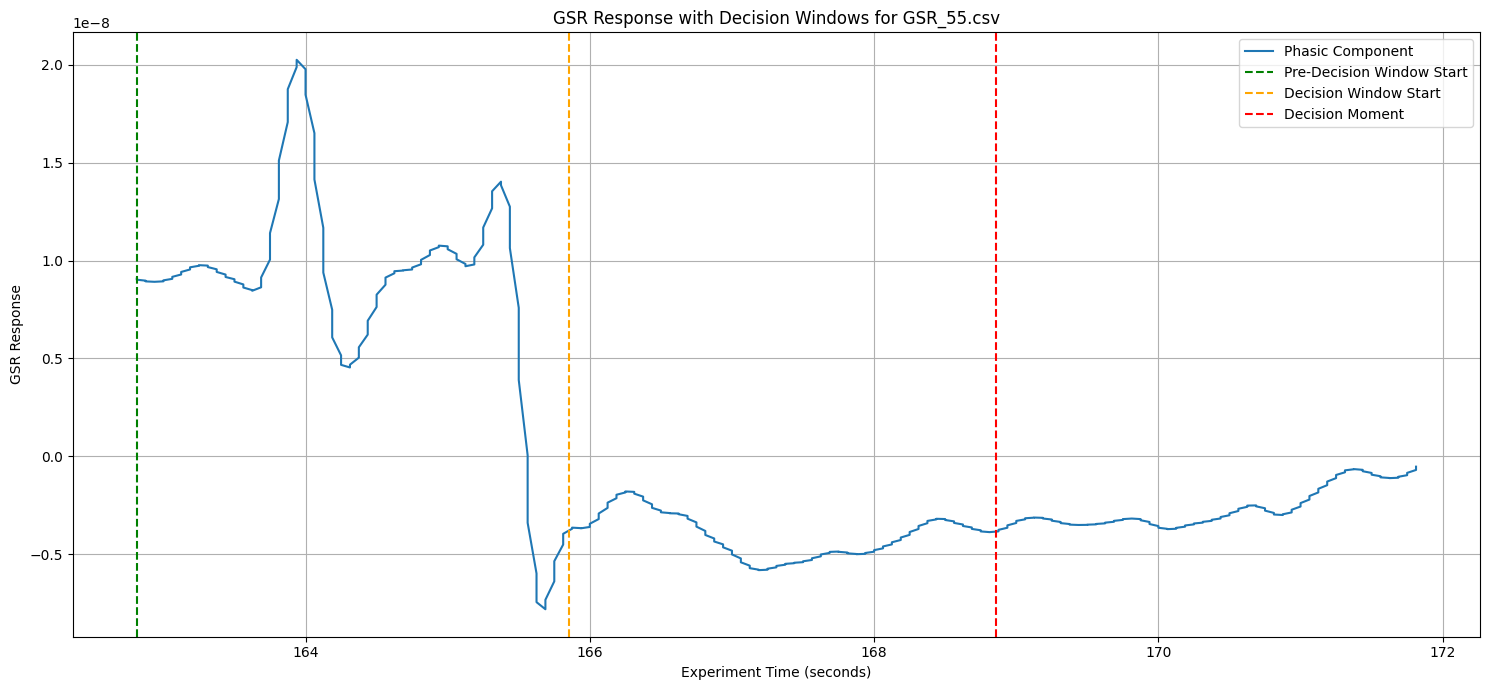


Processing file 54/78: /content/gsr_data/GSR_56.csv
Difference between expected and raw duration: 3.56 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.036941  0.014019      0.009037
max_phasic     0.019023  0.011602      0.005925


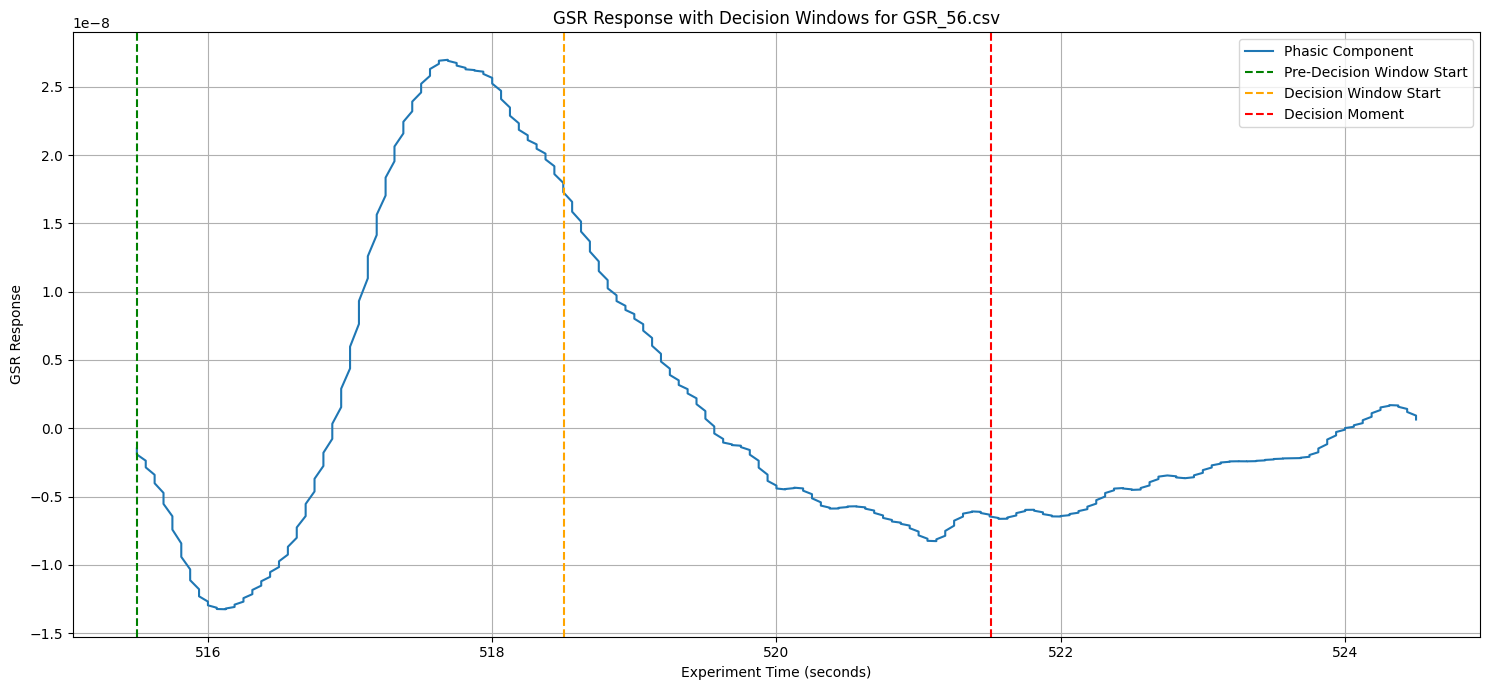


Processing file 55/78: /content/gsr_data/GSR_57.csv
Difference between expected and raw duration: 5.31 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.004546  0.004794      0.016417
max_phasic     0.004767  0.005010      0.008873


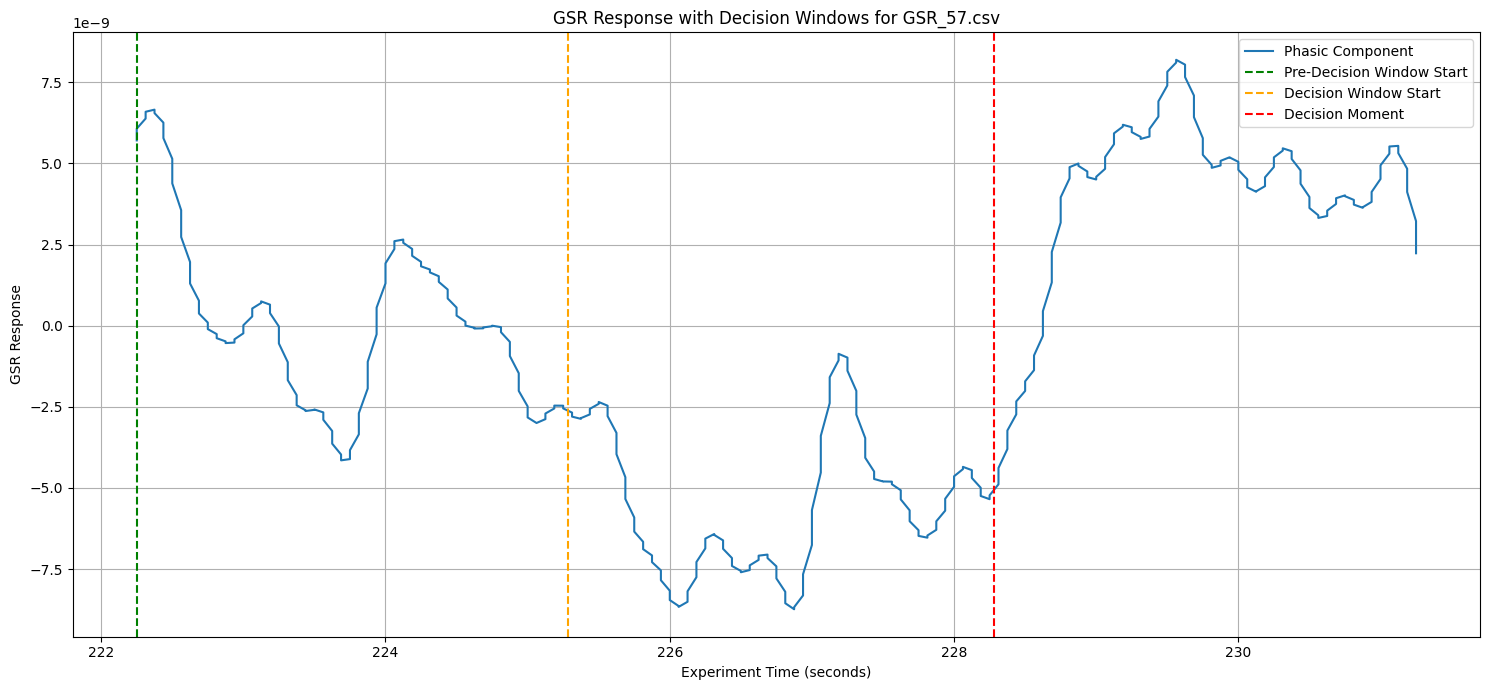


Processing file 56/78: /content/gsr_data/GSR_58.csv
Difference between expected and raw duration: 6.62 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.001693  0.002798      0.001626
max_phasic     0.001971  0.001484      0.001390


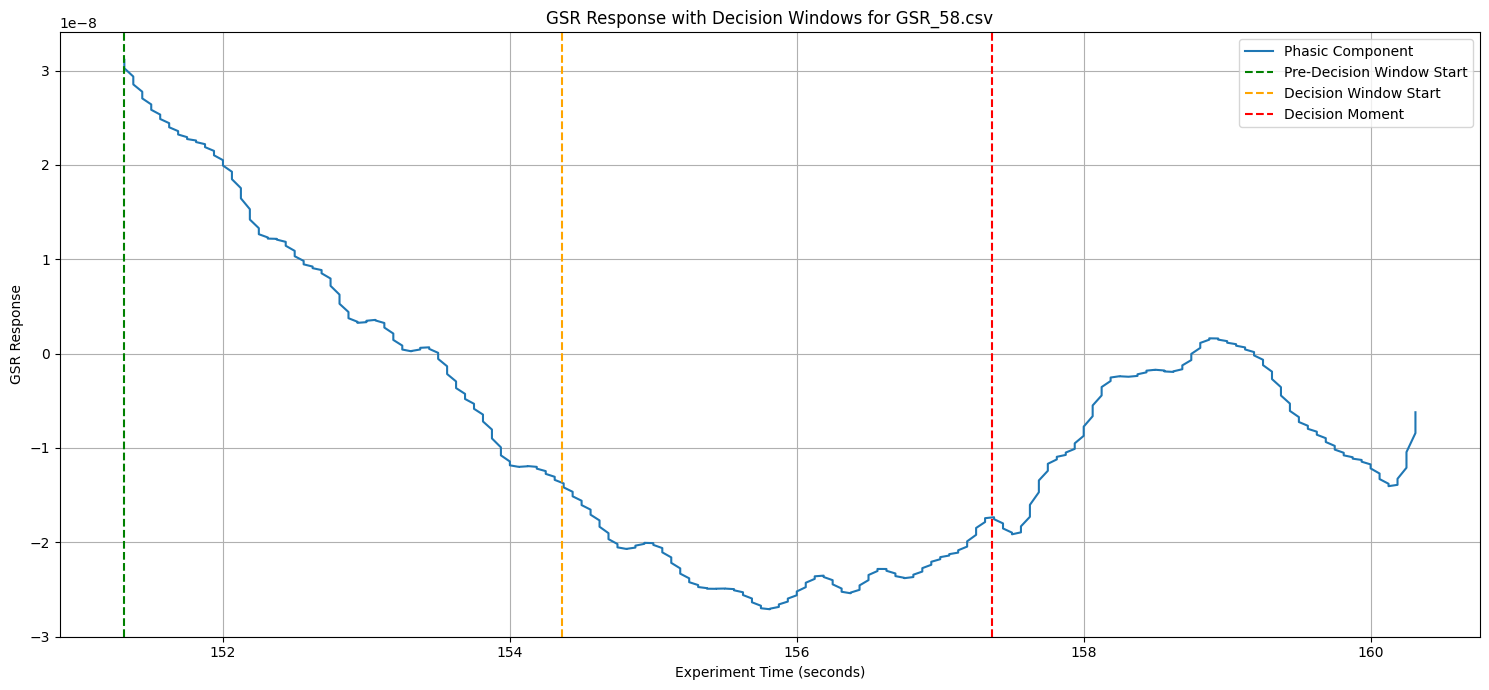


Processing file 57/78: /content/gsr_data/GSR_59.csv
Difference between expected and raw duration: 4.44 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.055572  0.038492      0.029240
max_phasic     0.030446  0.036414      0.015425


/usr/local/lib/python3.12/dist-packages/neurokit2/eda/eda_peaks.py:127: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])
/usr/local/lib/python3.12/dist-packages/neurokit2/eda/eda_peaks.py:127: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])


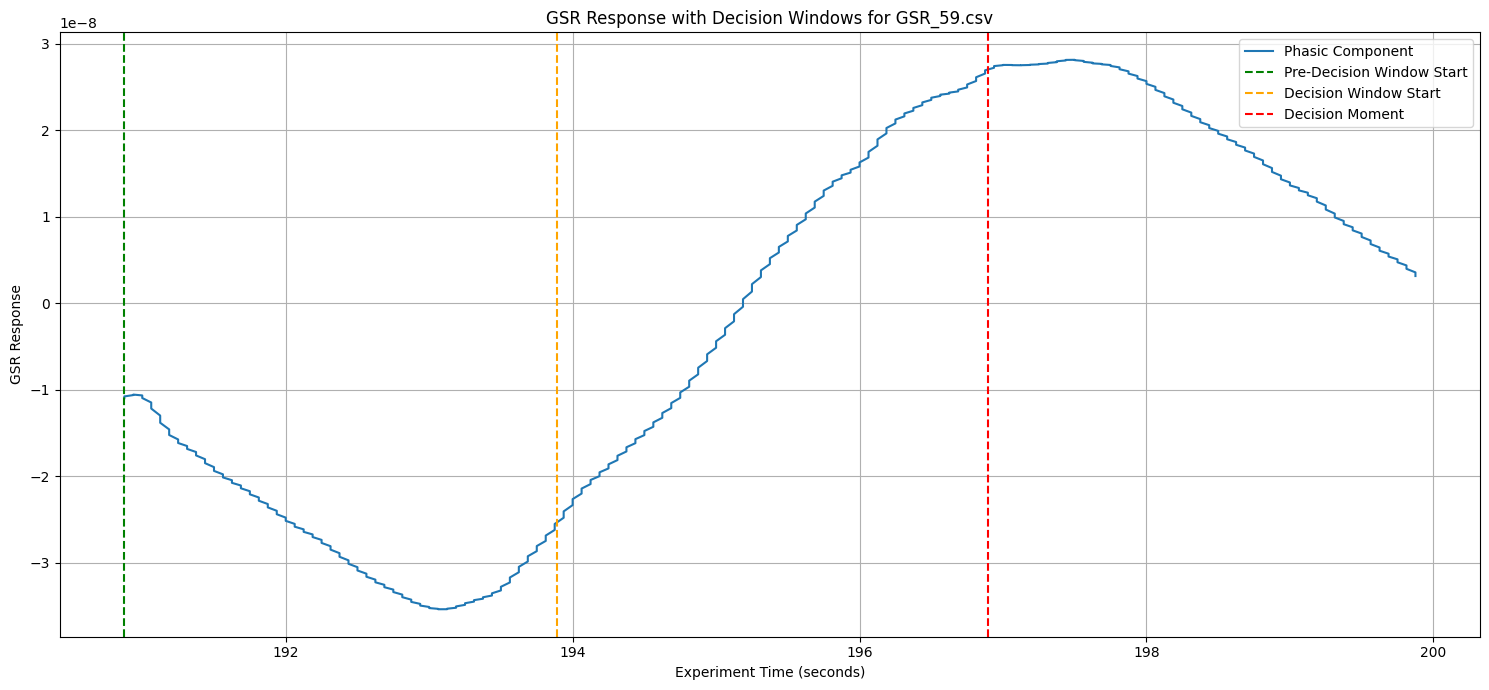


Processing file 58/78: /content/gsr_data/GSR_60.csv
Difference between expected and raw duration: 4.44 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.008833  0.001138      0.001692
max_phasic     0.005557  0.002301      0.002121


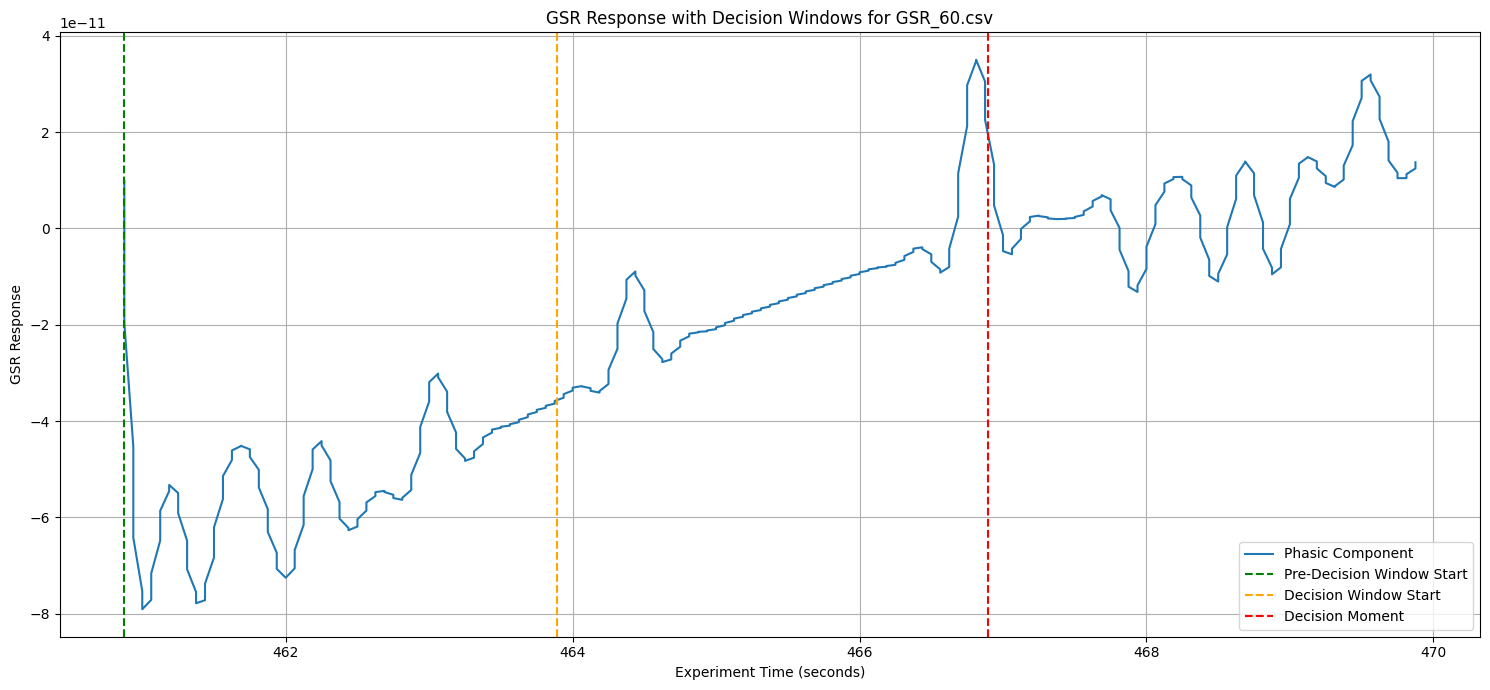


Processing file 59/78: /content/gsr_data/GSR_61.csv
Difference between expected and raw duration: 4.69 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.005812  0.003886      0.052524
max_phasic     0.004013  0.003415      0.031425


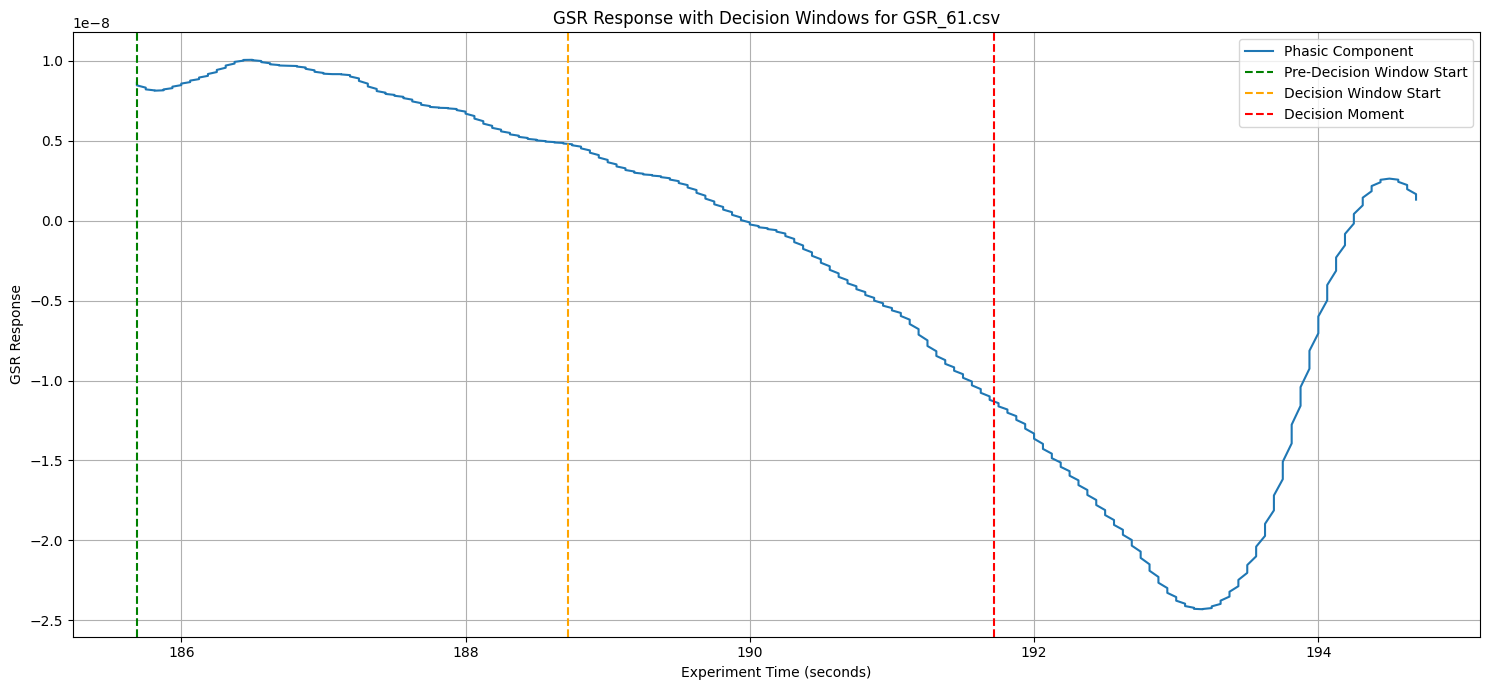


Processing file 60/78: /content/gsr_data/GSR_62.csv
Difference between expected and raw duration: 5.19 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.002790  0.004315      0.003155
max_phasic     0.002884  0.003238      0.002243


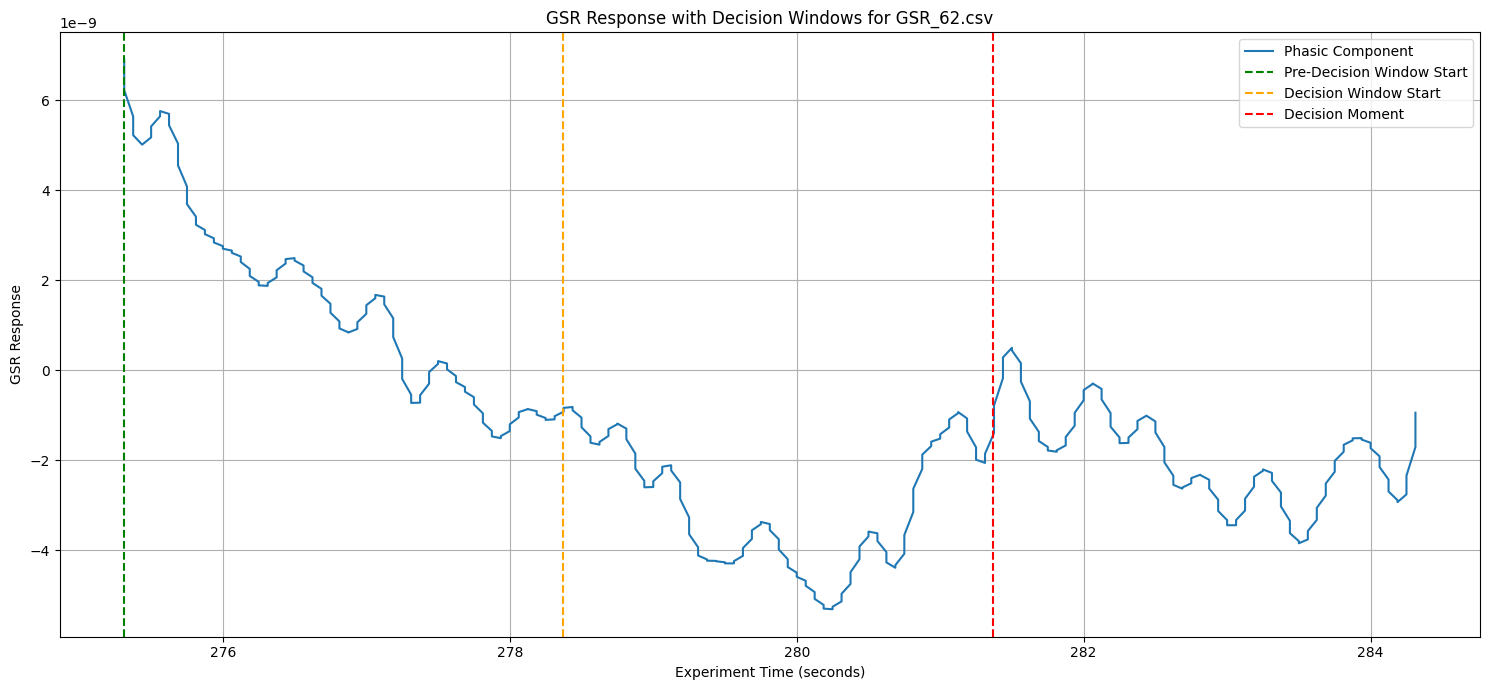


Processing file 61/78: /content/gsr_data/GSR_63.csv
Difference between expected and raw duration: 3.81 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.006816  0.009581      0.019094
max_phasic     0.004977  0.005807      0.010014


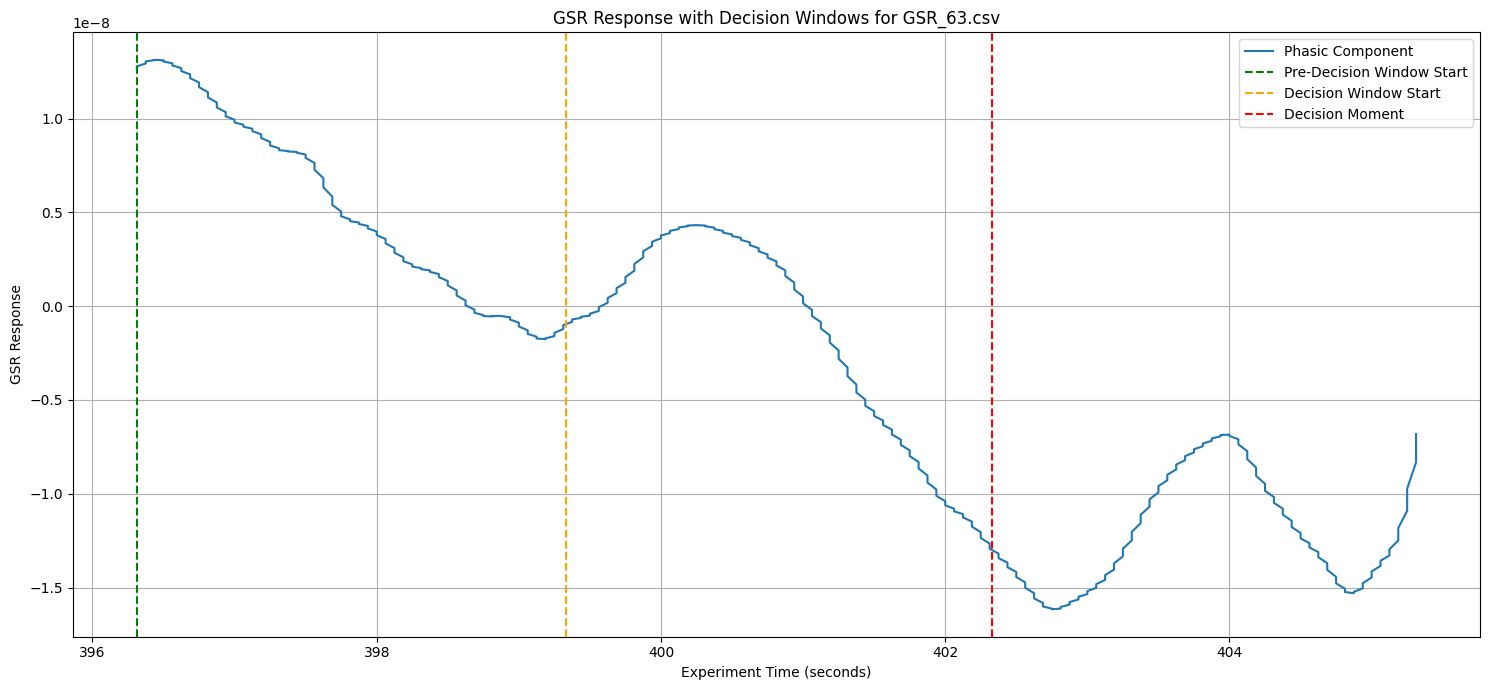


Processing file 62/78: /content/gsr_data/GSR_64.csv
Difference between expected and raw duration: 3.75 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.001358  0.003467      0.013565
max_phasic     0.000765  0.001824      0.006550


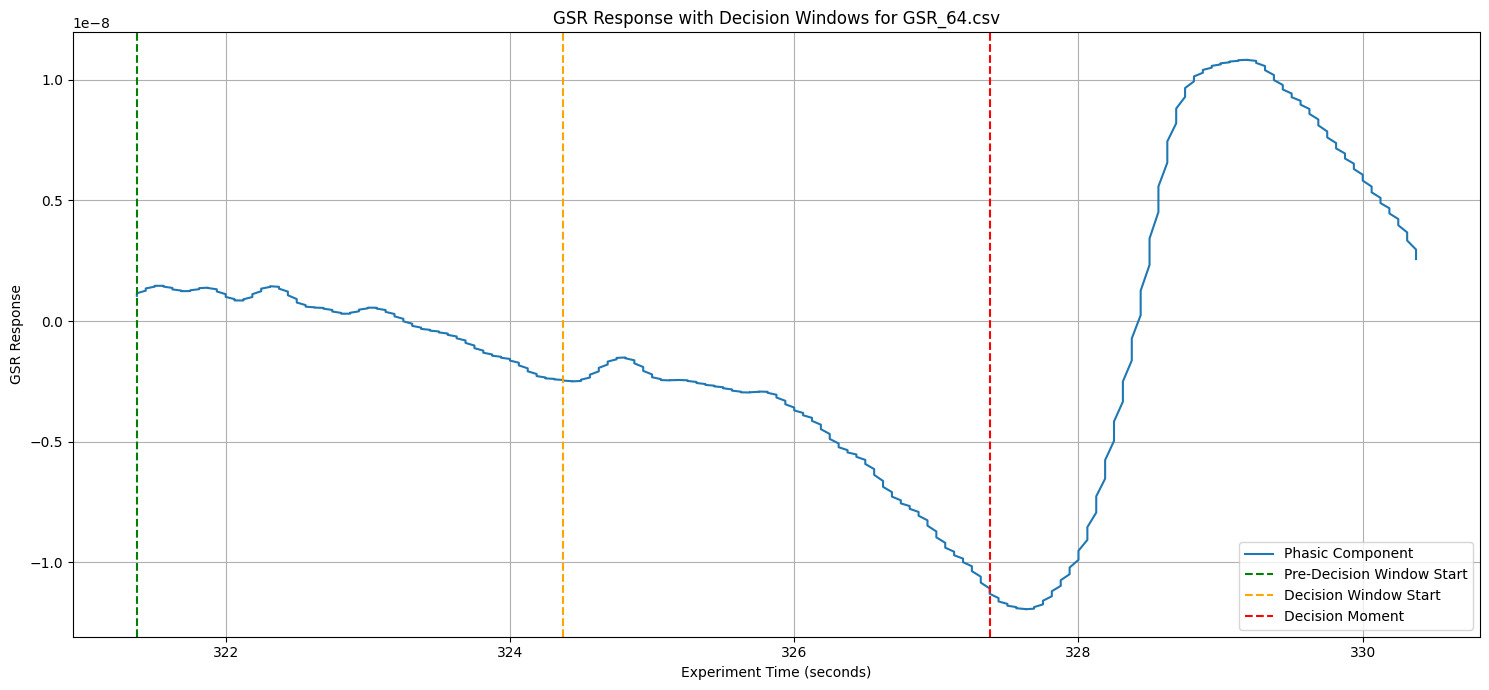


Processing file 63/78: /content/gsr_data/GSR_65.csv
Difference between expected and raw duration: 7.50 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.004678  0.006373      0.024510
max_phasic     0.002732  0.006479      0.012757


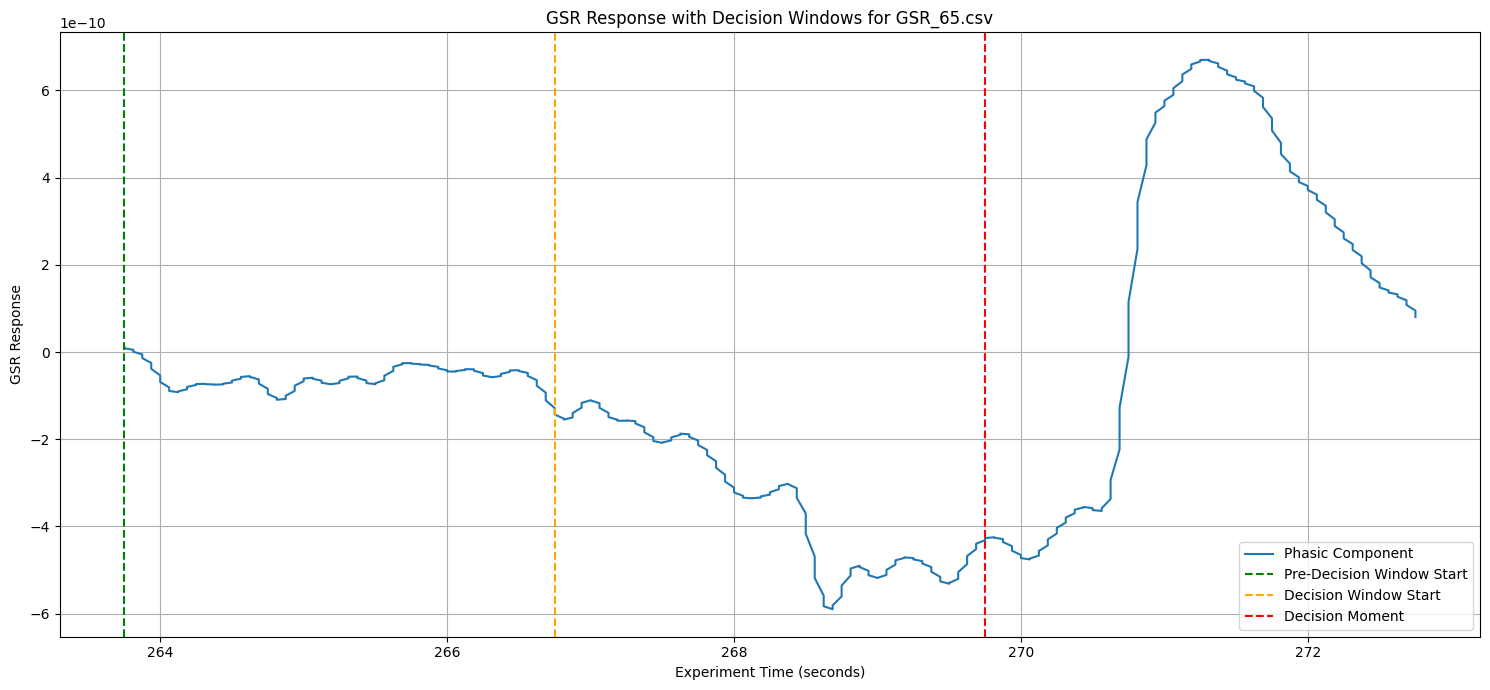


Processing file 64/78: /content/gsr_data/GSR_66.csv
Difference between expected and raw duration: 3.81 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.017924  0.004338      0.005235
max_phasic     0.012091  0.002828      0.003946


/usr/local/lib/python3.12/dist-packages/neurokit2/eda/eda_peaks.py:127: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])
/usr/local/lib/python3.12/dist-packages/neurokit2/eda/eda_peaks.py:127: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])


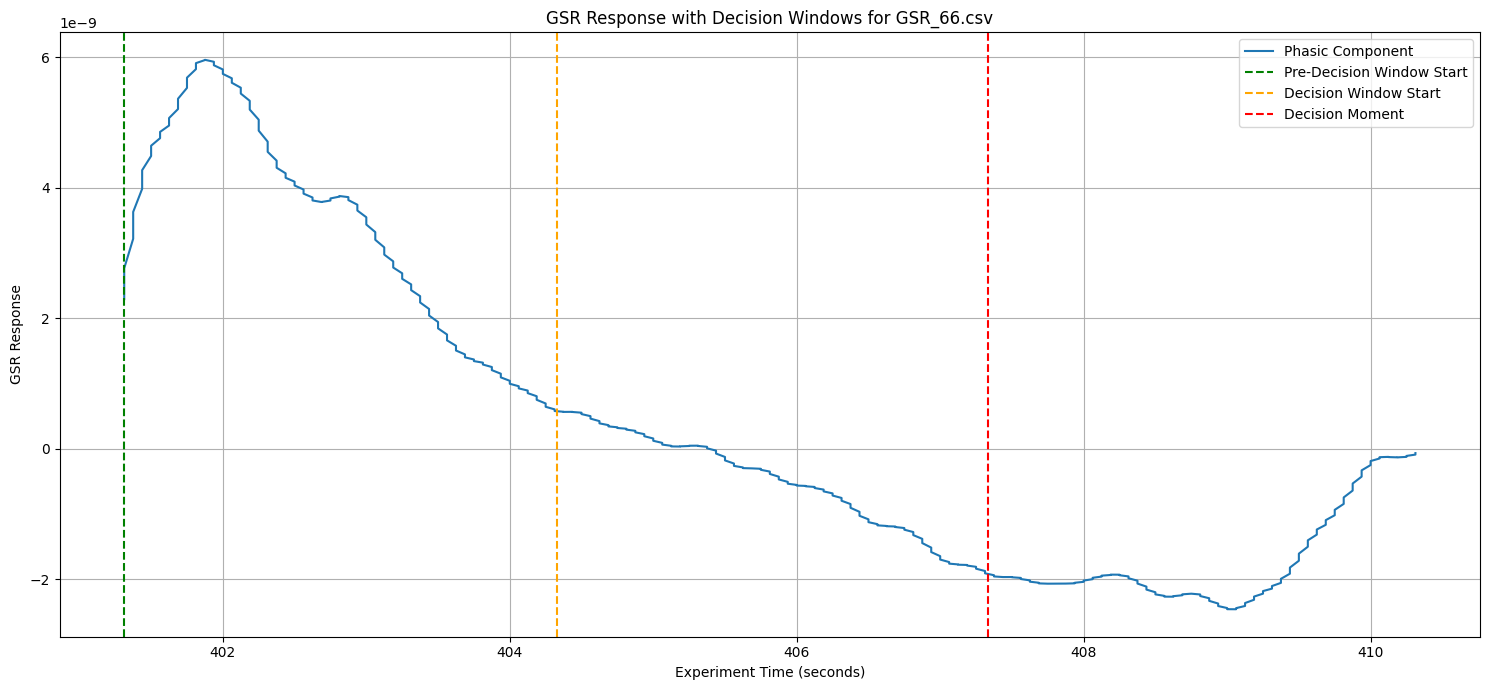


Processing file 65/78: /content/gsr_data/GSR_67.csv
Difference between expected and raw duration: 3.69 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.001950  0.001717      0.001873
max_phasic     0.001564  0.001355      0.001645


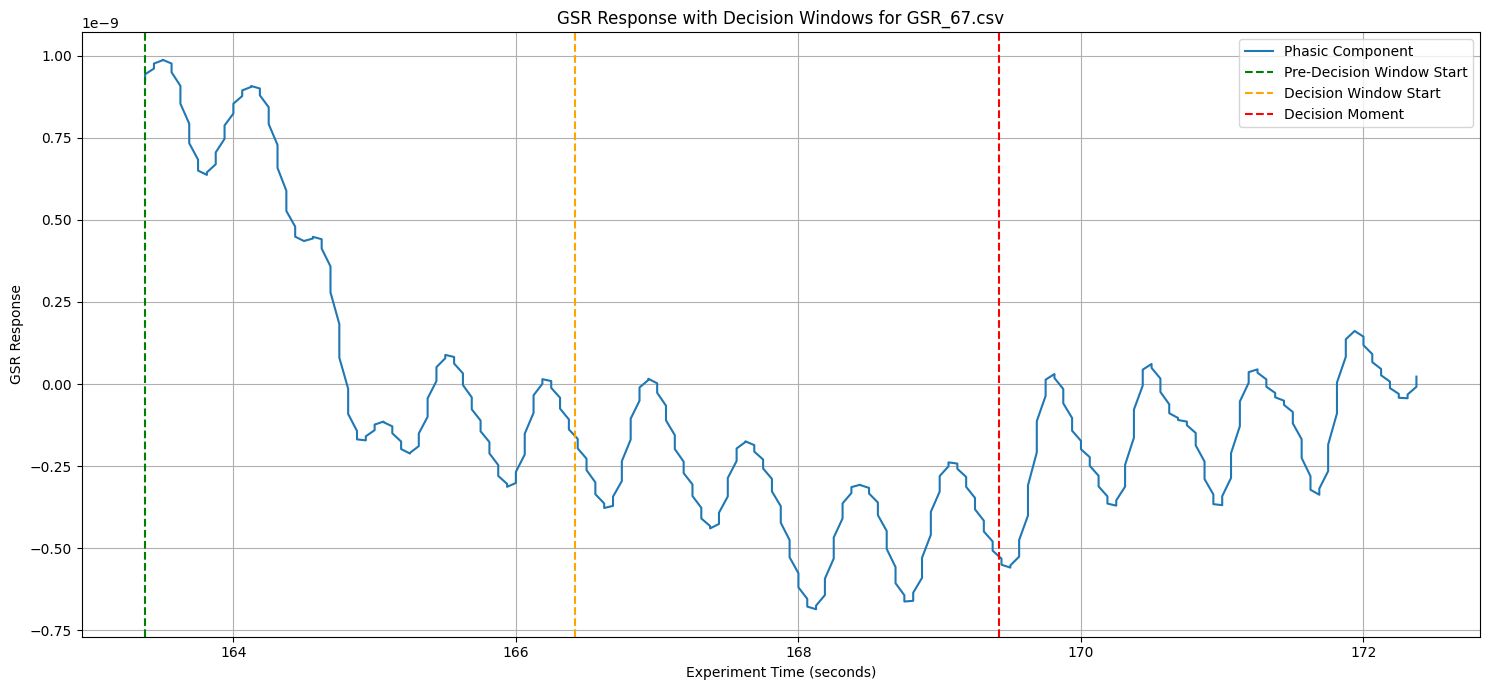


Processing file 66/78: /content/gsr_data/GSR_68.csv
Difference between expected and raw duration: 3.88 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.003945  0.003957      0.005174
max_phasic     0.004444  0.002492      0.002873


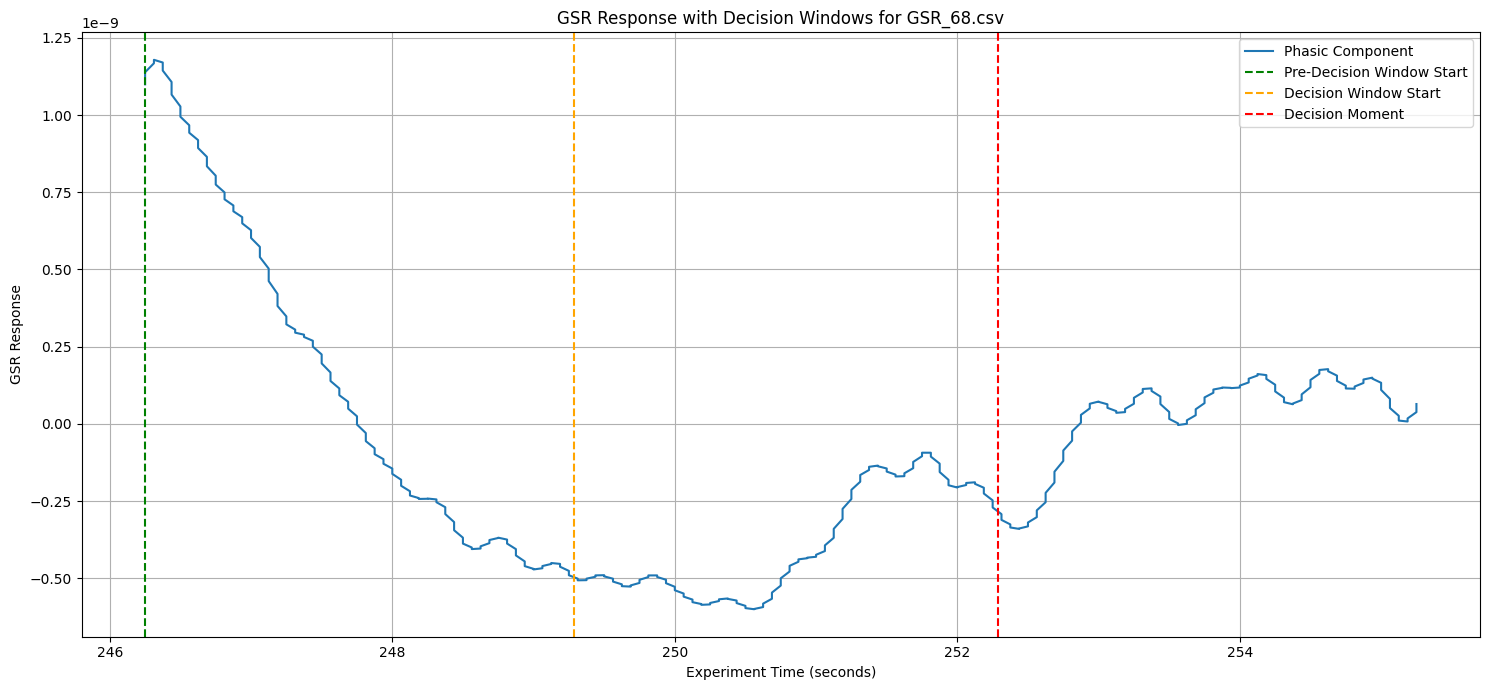


Processing file 67/78: /content/gsr_data/GSR_69.csv
Difference between expected and raw duration: 6.44 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.003213  0.002759      0.002273
max_phasic     0.001901  0.002197      0.001903


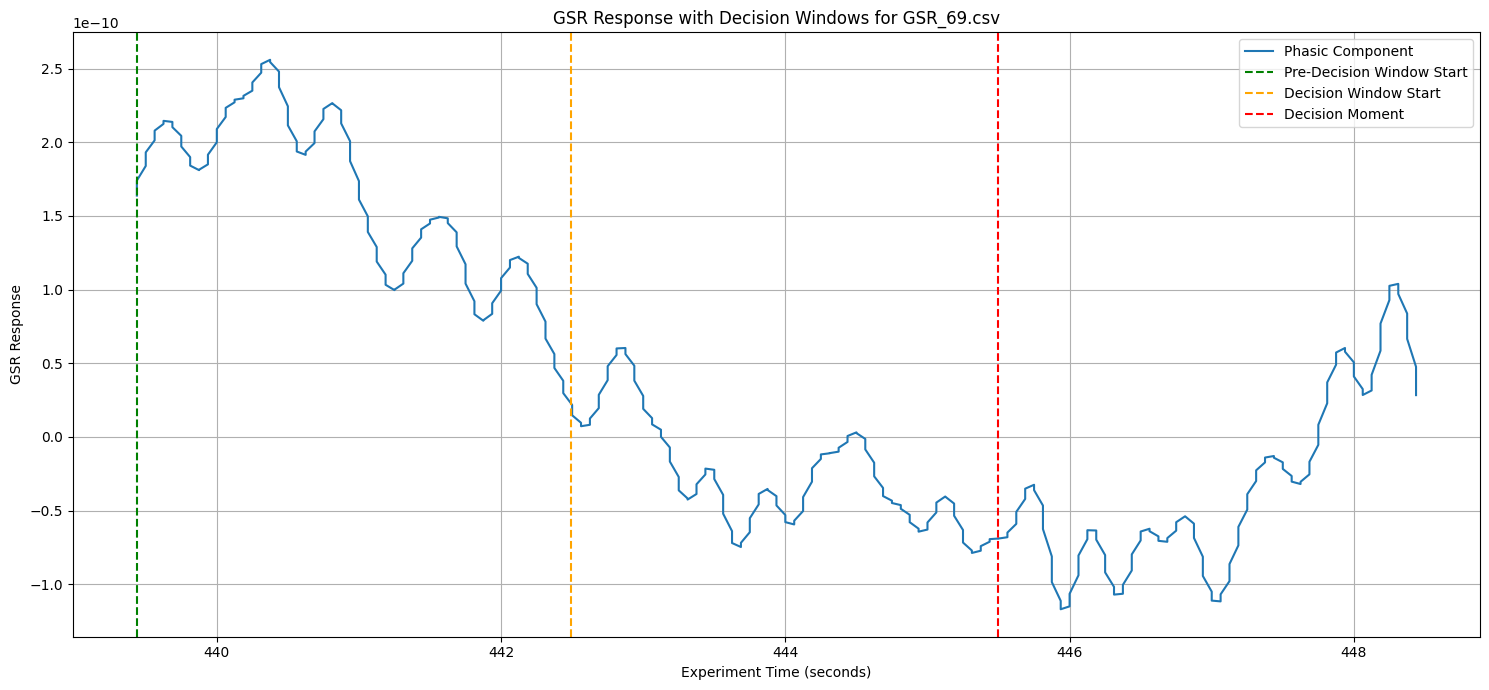


Processing file 68/78: /content/gsr_data/GSR_70.csv
Difference between expected and raw duration: 6.56 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.027893  0.008205      0.006858
max_phasic     0.016286  0.005443      0.004210


/usr/local/lib/python3.12/dist-packages/neurokit2/eda/eda_peaks.py:127: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])


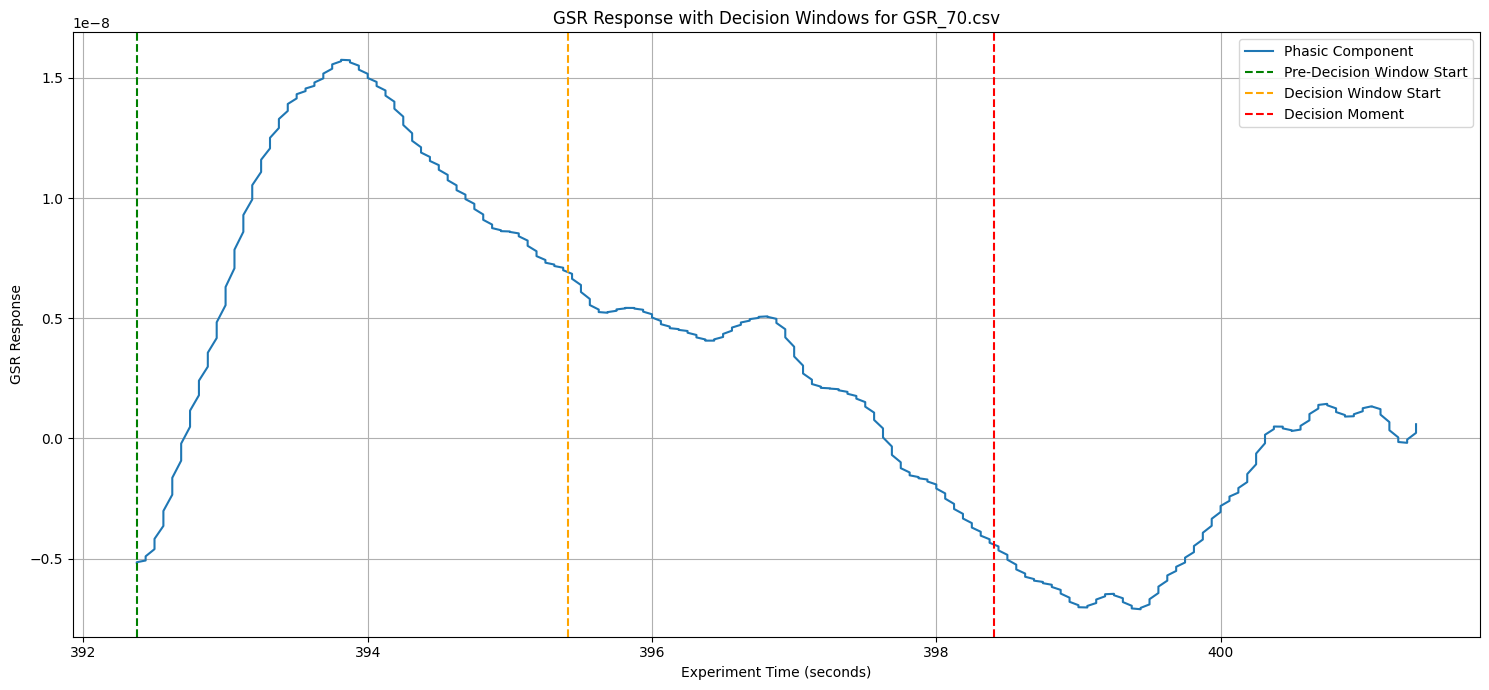


Processing file 69/78: /content/gsr_data/GSR_71.csv
Difference between expected and raw duration: 4.12 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.001181  0.001168      0.001457
max_phasic     0.001347  0.001206      0.001447


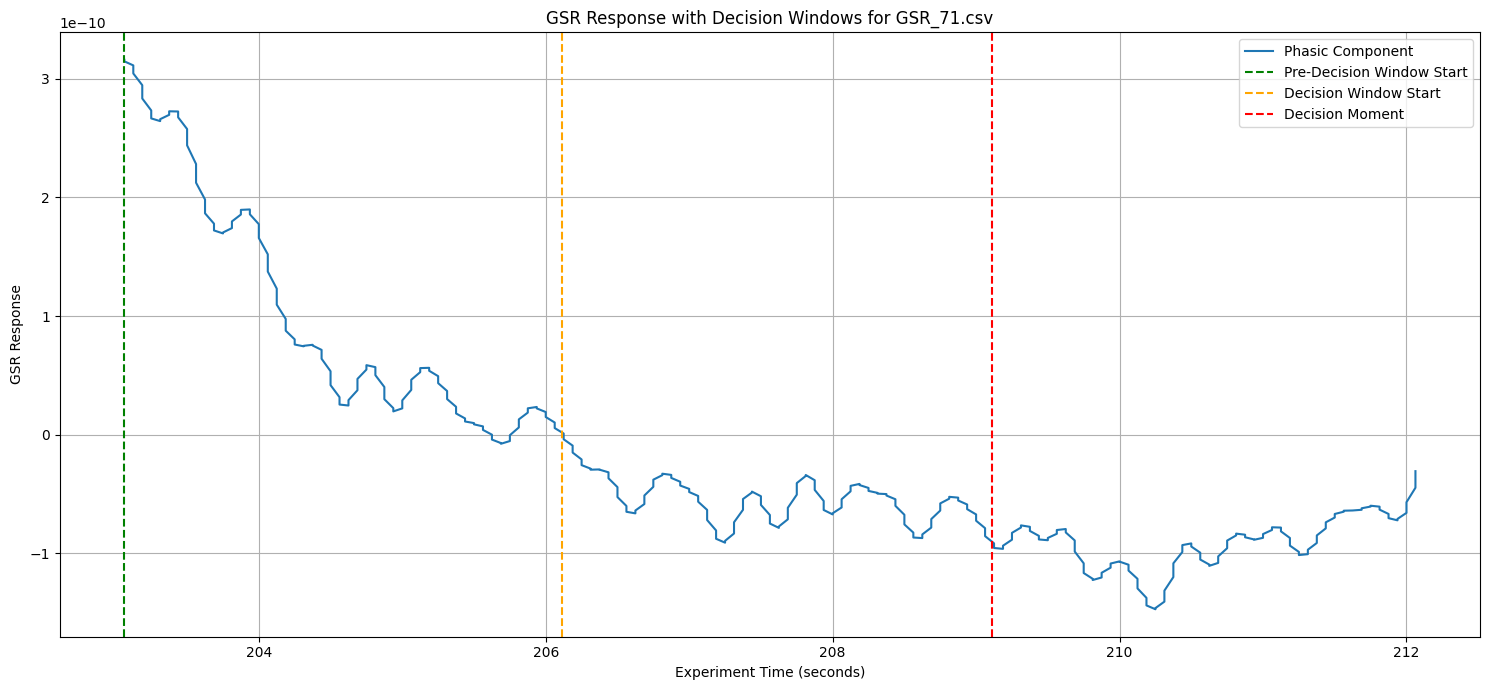


Processing file 70/78: /content/gsr_data/GSR_72.csv
Difference between expected and raw duration: 7.12 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.006708  0.005588      0.010586
max_phasic     0.004398  0.004653      0.005636


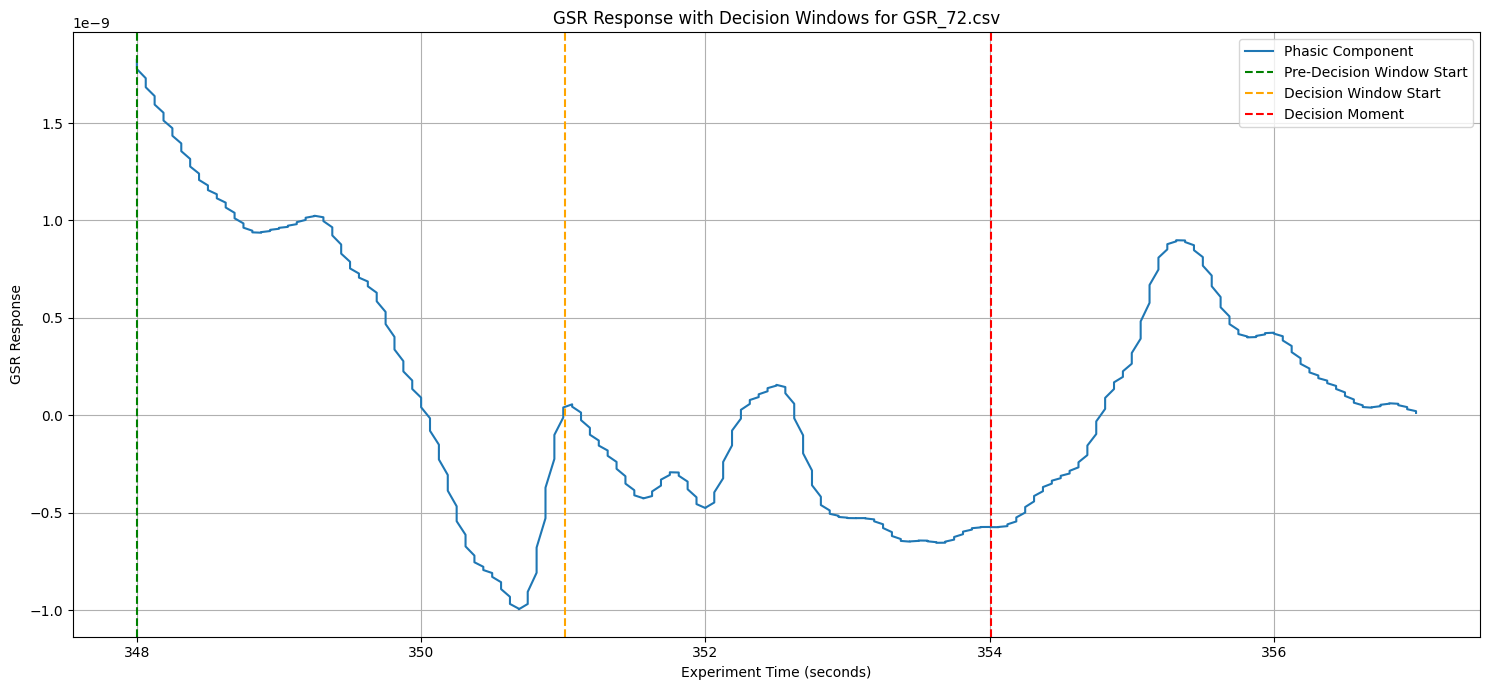


Processing file 71/78: /content/gsr_data/GSR_73.csv
Difference between expected and raw duration: 4.25 seconds
Error processing EDA signal: zero-size array to reduction operation maximum which has no identity
AUC:
 None
                                                                   Data segment too short for processing. Skipping file.

Processing file 72/78: /content/gsr_data/GSR_74.csv
Difference between expected and raw duration: 5.38 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.009524  0.091591      0.070119
max_phasic     0.005162  0.048778      0.036350


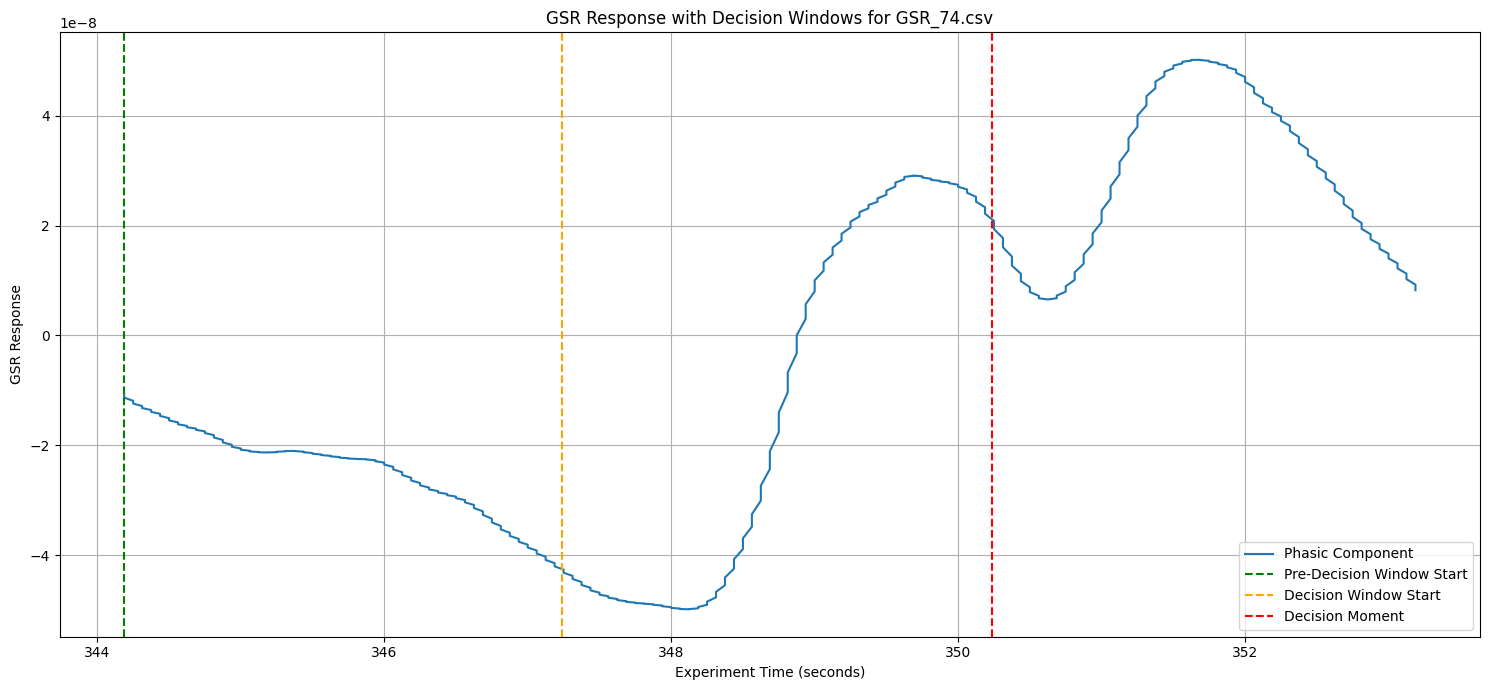


Processing file 73/78: /content/gsr_data/GSR_75.csv
Difference between expected and raw duration: 2.44 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.000837  0.000575      0.000894
max_phasic     0.000610  0.000532      0.000690


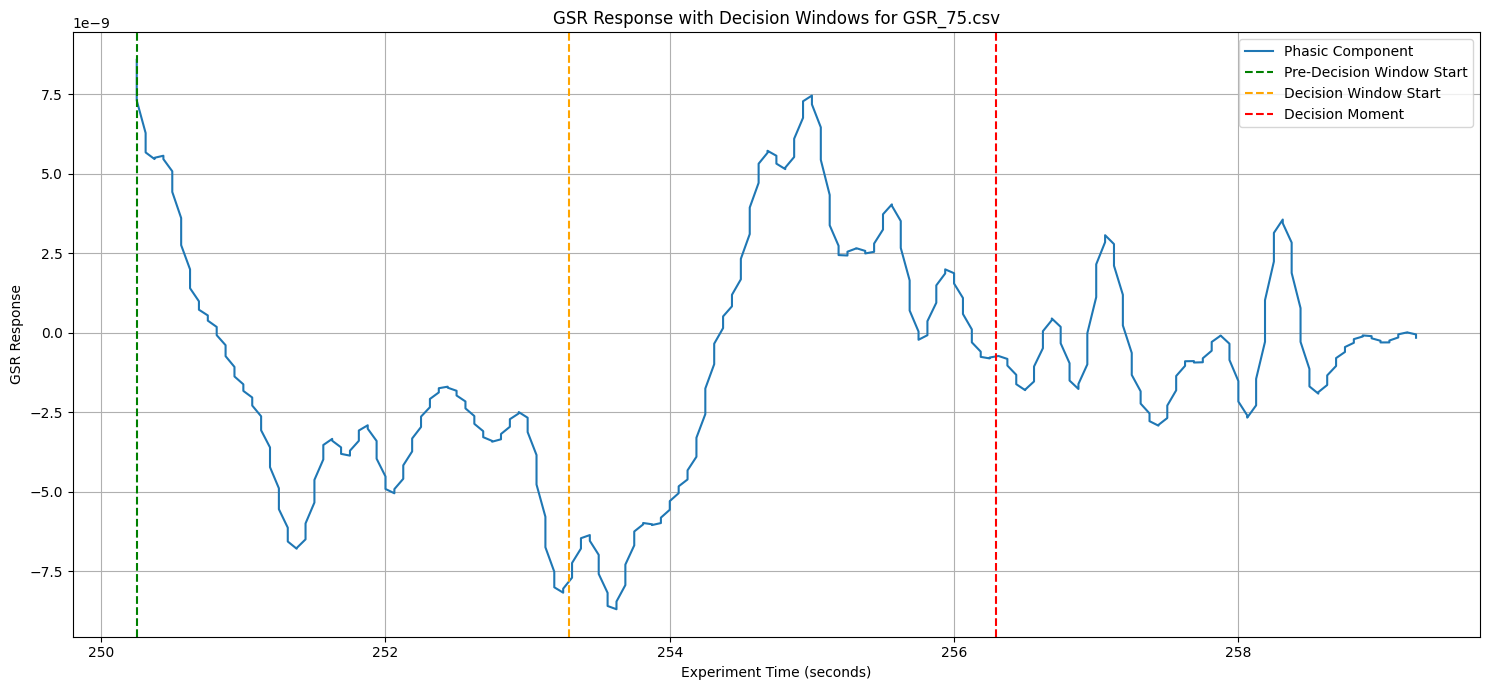


Processing file 74/78: /content/gsr_data/GSR_76.csv
Difference between expected and raw duration: 4.25 seconds
Error processing EDA signal: zero-size array to reduction operation maximum which has no identity
AUC:
 None
                                                                   Data segment too short for processing. Skipping file.

Processing file 75/78: /content/gsr_data/GSR_77.csv
Difference between expected and raw duration: 2.69 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.004211  0.004410      0.011778
max_phasic     0.002319  0.002488      0.007770


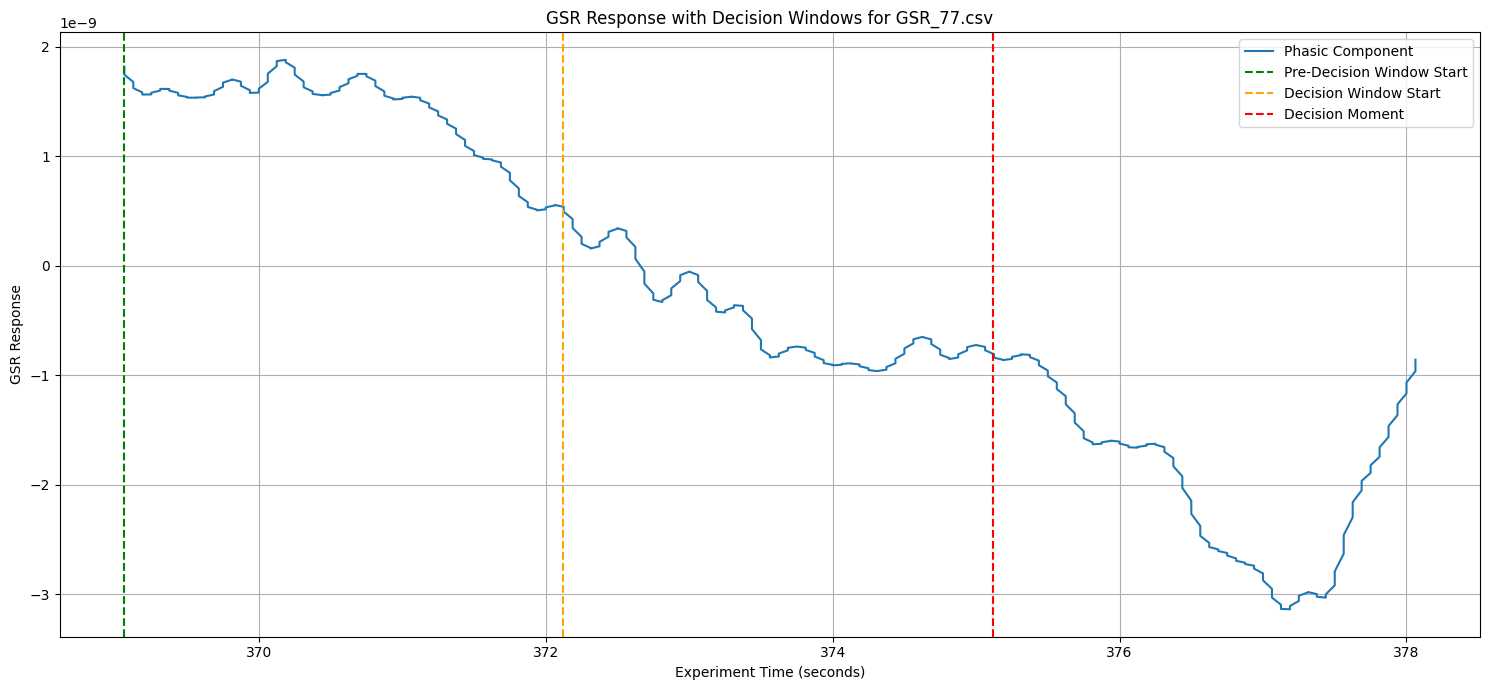


Processing file 76/78: /content/gsr_data/GSR_78.csv
Difference between expected and raw duration: 3.69 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.001939  0.025525      0.004678
max_phasic     0.000983  0.014892      0.003717


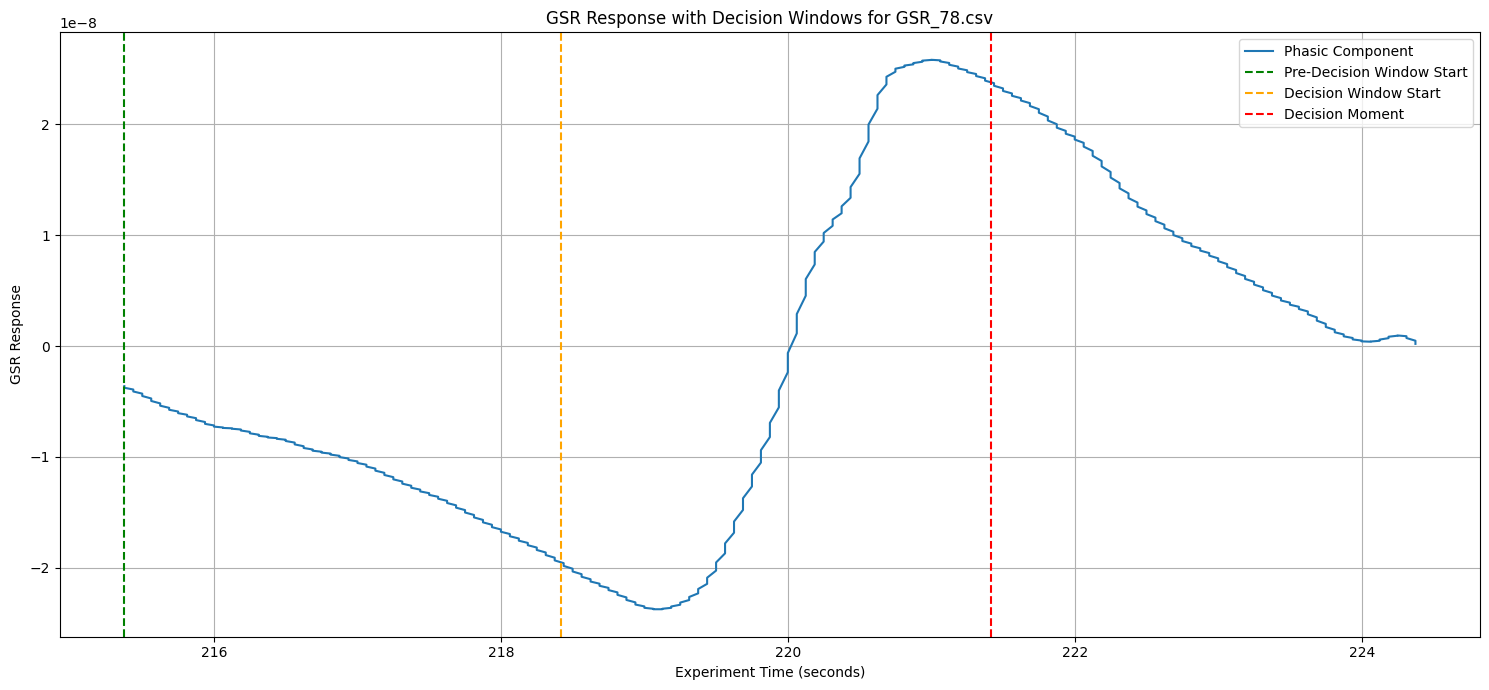


Processing file 77/78: /content/gsr_data/GSR_79.csv
Difference between expected and raw duration: 3.00 seconds
Error processing EDA signal: zero-size array to reduction operation maximum which has no identity
AUC:
 None
                                                                   Data segment too short for processing. Skipping file.

Processing file 78/78: /content/gsr_data/GSR_80.csv
Difference between expected and raw duration: 4.75 seconds
AUC:
             predecision  decision  postdecision
net_phasic     0.005353  0.004096      0.025712
max_phasic     0.004193  0.004318      0.015993


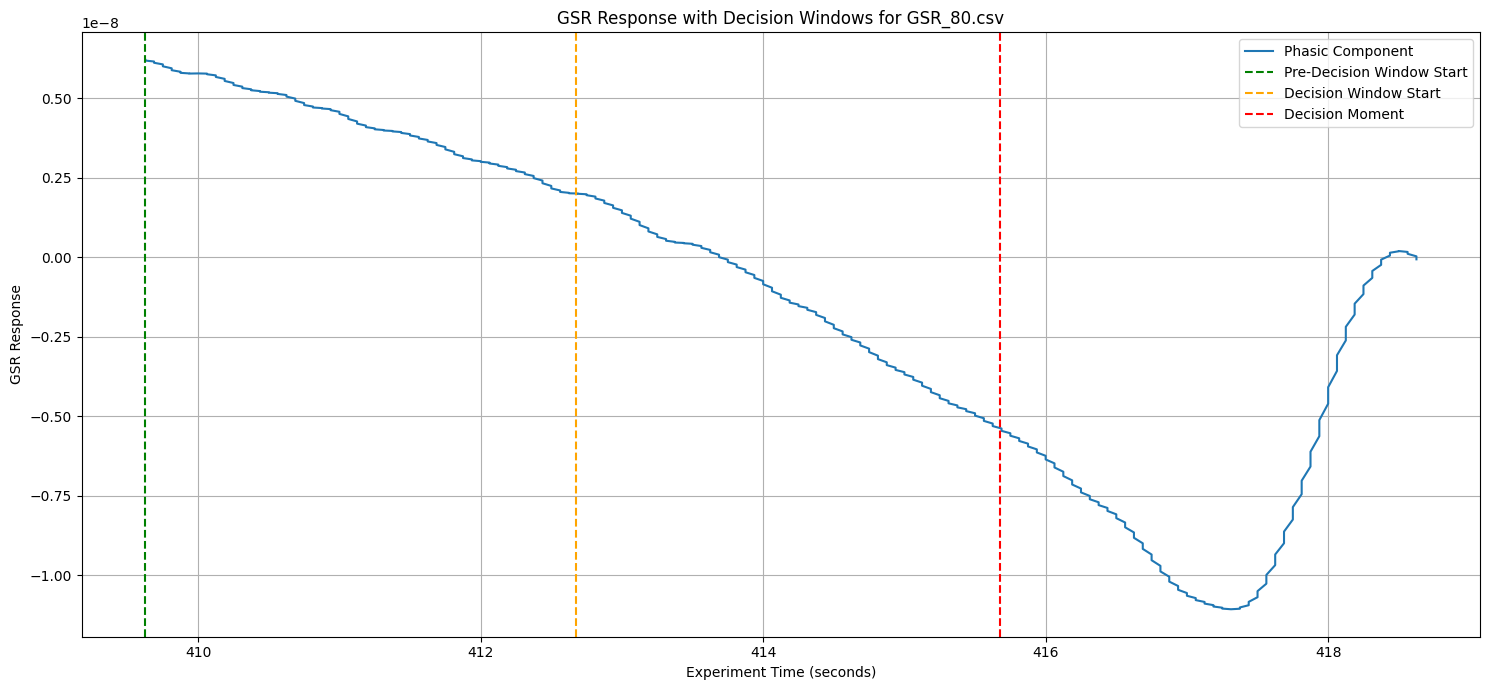


Total Results DataFrame:


GSR_File Decision  net_phasic_predecision  net_phasic_decision  \
0          1       AI                0.006726             0.007292   
1          2       AI                0.048954             0.015795   
2          9    Human                0.022348             0.010062   
3         10    Human                0.004189             0.006355   
4         11    Human                0.009876             0.004927   
..       ...      ...                     ...                  ...   
56        74    Human                0.009524             0.091591   
57        75    Human                0.000837             0.000575   
58        77    Human                0.004211             0.004410   
59        78       AI                0.001939             0.025525   
60        80    Human                0.005353             0.004096   

    net_phasic_postdecision  max_phasic_predecision  max_phasic_decision  \
0                  0.020106                0.006142             0.004946   
1                  0.014703                0.030991             0.010563   
2                  0.003514                0.016307             0.008778   
3                  0.010424                0.005711             0.004212   
4                  0.003168                0.005720             0.002490   
..                      ...                     ...                  ...   
56                 0.070119                0.005162             0.048778   
57                 0.000894                0.000610             0.000532   
58                 0.011778                0.002319             0.002488   
59                 0.004678                0.000983             0.014892   
60                 0.025712                0.004193             0.004318   

    max_phasic_postdecision  
0                  0.010461  
1                  0.008143  
2                  0.003013  
3                  0.005266  
4                  0.002790  
..                      ...  
56                 0.036350  
57                 0.000690  
58                 0.007770  
59                 0.003717  
60                 0.015993  

[61 rows x 8 columns]

In [15]:
# import zipfile
# import os
# import re
# import pandas as pd
# from google.colab import files
# import matplotlib.pyplot as plt
# import shutil
# import neurokit2 as nk


# Upload the CSV zip and experiment data file
# Get file paths from uploaded dictionary
zip_path = [name for name in uploaded if 'csv_zip' in name][0]
exprmnt_data_path = [name for name in uploaded if 'exprmnt_data' in name][0]

# Unzip the uploaded zip file
extracted_folder = '/content/gsr_data'

# Clear the extracted_folder if it exists
if os.path.exists(extracted_folder):
    shutil.rmtree(extracted_folder)
os.makedirs(extracted_folder)


with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)

# Load experiment metadata (video durations and decision moments)
exprmnt_data = pd.read_csv(exprmnt_data_path)  # has 'video_durations' and 'decision_time' columns
exprmnt_data = exprmnt_data.dropna()

exprmnt_data['video_durations'] = exprmnt_data['video_durations'].apply(lambda x: sum(int(a) * 60**i for i, a in enumerate(reversed(x.split(':')))))
# Get a sorted list of GSR files
gsr_files = sorted(
    [os.path.join(extracted_folder, f) for f in os.listdir(extracted_folder) if f.endswith('.csv')],
    key=lambda x: int(re.search(r'\d+', os.path.basename(x)).group())
)
print(f"GSR file order to be analysised:\n                          {gsr_files}")

# Initialize an empty DataFrame to store results
total_results_df = pd.DataFrame()

# Loop over each file and duration
for i, gsr_file in enumerate(gsr_files):
    print(f"\nProcessing file {i+1}/{len(gsr_files)}: {gsr_file}")

    # Extract corresponding duration and decision time
    duration = exprmnt_data.loc[i, 'video_durations']            # in seconds
    decision_time = exprmnt_data.loc[i, 'decision_time']         # in format 'MM:SS'
    decision = exprmnt_data.loc[i, 'Decisions']                  # Decision (AI or Human)
    gsr_file_name = os.path.basename(gsr_file)                   # GSR file name
    gsr_file_name = int(gsr_file_name.split("_")[1].split(".")[0])                   # GSR file number
    # Call the function
    initial_sequence, win_end, decision_time_seconds_in_GSR, segmented_df, combined_df, net_phasic_df, data_status = compute_elapsed_time(
        gsr_csv_path=gsr_file,
        total_duration_seconds=duration,
        decision_time_str=decision_time
        # Optional: can override defaults like initial_lag_share=0.6, lead_time=2, win_lngth=4
    )
    print(f"AUC:\n {net_phasic_df}")

    # Example: preview segmented data
    if data_status == "not applicable":
        print(f"                                                                   Not applicable data found for the specified time window.")
    elif data_status == "skipped":
        print(f"                                                                   Data segment too short for processing. Skipping file.")
    else:
        # Create a single row DataFrame with the desired structure
        result_row = pd.DataFrame({
            'GSR_File': [gsr_file_name],
            'Decision': [decision],
            'net_phasic_predecision': [net_phasic_df.loc['net_phasic', 'predecision']],
            'net_phasic_decision': [net_phasic_df.loc['net_phasic', 'decision']],
            'net_phasic_postdecision': [net_phasic_df.loc['net_phasic', 'postdecision']],
            'max_phasic_predecision': [net_phasic_df.loc['max_phasic', 'predecision']],
            'max_phasic_decision': [net_phasic_df.loc['max_phasic', 'decision']],
            'max_phasic_postdecision': [net_phasic_df.loc['max_phasic', 'postdecision']]
        })

        # Append the result row to the total results DataFrame
        total_results_df = pd.concat([total_results_df, result_row], ignore_index=True)



        # Create an elapsed time column
        #initial_sequence = combined_df['sequence'].min()
        combined_df['elapsed_time'] = (combined_df['sequence'] - initial_sequence) / 16.0

        # Calculate phasic component for the combined data
        sampling_rate = 32
        signal_combined = combined_df['Galvanic Skin Response-ch1'].values
        if len(signal_combined) >= 16: # Check if the signal is too short for filtering
            try:
                processed_combined = nk.eda_process(signal_combined, sampling_rate=sampling_rate)
                if processed_combined is not None and len(processed_combined) > 0:
                    processed_combined_df = processed_combined[0]
                    if 'EDA_Phasic' in processed_combined_df.columns and not processed_combined_df['EDA_Phasic'].empty:
                        combined_df['EDA_Phasic'] = processed_combined_df['EDA_Phasic'].values




            except Exception as e:
                print(f"Error processing combined EDA signal for plotting: {e}")


        # Plotting the combined data with window identifiers
        plt.figure(figsize=(15, 7))
        if 'EDA_Phasic' in combined_df.columns:
            plt.plot(combined_df['elapsed_time'], combined_df['EDA_Phasic'], label='Phasic Component')


        # Add vertical lines to distinguish windows
        pre_decision_window_start_time = (segmented_df['sequence'].min() - initial_sequence) / 16.0
        decision_window_start_time = win_end
        decision_moment_time = decision_time_seconds_in_GSR

        plt.axvline(x=pre_decision_window_start_time, color='green', linestyle='--', label='Pre-Decision Window Start')
        plt.axvline(x=decision_window_start_time, color='orange', linestyle='--', label='Decision Window Start')
        plt.axvline(x=decision_moment_time, color='red', linestyle='--', label='Decision Moment')

        plt.xlabel('Experiment Time (seconds)')
        plt.ylabel('GSR Response')
        plt.title(f'GSR Response with Decision Windows for {os.path.basename(gsr_file)}')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()    ###xxx

# Display the total results DataFrame
print("\nTotal Results DataFrame:")
display(total_results_df)

# PART 3: *MACHINE* *LEARNING*



## 3.1: Initializing Libraries for ML

In [16]:
from typing import Dict, Any, Tuple, List, Optional
from google.colab import drive
from __future__ import annotations

from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier

from sklearn.base import clone
from sklearn.metrics import (
    accuracy_score, roc_auc_score, brier_score_loss,
    precision_score, recall_score, f1_score,
    roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
)

from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek


import matplotlib.pyplot as plt

## 3.2: Function Development for Modularization of ML Process

In [17]:
# @title 1. Function(s) for: Building Pipeline
"""
train_select_best_with_logs (stacking-ready)

[UNCHANGED docstring...]
"""

def _extract_prob(estimator, X: np.ndarray, positive_index: int = 1) -> np.ndarray:
    if hasattr(estimator, "predict_proba"):
        P = estimator.predict_proba(X)
        if P.ndim == 2 and P.shape[1] > positive_index:
            return P[:, positive_index]
        return P.ravel()
    if hasattr(estimator, "decision_function"):
        s = estimator.decision_function(X)
        return 1 / (1 + np.exp(-s))
    return estimator.predict(X).astype(float)


def train_select_best_with_logs(
    X_train: np.ndarray,
    X_test: np.ndarray,
    y_train: np.ndarray,
    y_test: np.ndarray,
    *,
    random_state: int = 42,
    use_selector: bool = True,
    cv_splits: int = 5,
    scoring: str = "accuracy",
    n_jobs: int = -1,
    return_oof: bool = True,
) -> Dict[str, Any]:


    def make_pipeline(base_estimator, selector=use_selector):
        steps = [("scaler", MinMaxScaler())]
        if selector:
            steps.append((
                "selector",
                SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=random_state))
            ))
        steps += [
            ("sampler", SMOTETomek(random_state=random_state)),
            ("model", base_estimator)
        ]
        return ImbPipeline(steps)

    classifier_params = {
        "Dummy": {"model": DummyClassifier(strategy="most_frequent"), "params": {}},
        "Random Forest": {
            "model": RandomForestClassifier(random_state=random_state, class_weight="balanced"),
            "params": {
                "model__n_estimators": [ 100, 200],
                "model__max_depth": [None, 10, 20],
                "model__min_samples_split": [5, 10],
                "model__min_samples_leaf": [1, 2, 4],
            }
        },
        "Gradient Boosting": {
            "model": GradientBoostingClassifier(random_state=random_state),
            "params": {
                "model__n_estimators": [100, 200],
                "model__learning_rate": [0.01, 0.1],
                "model__max_depth": [3, 5, 7],
            }
        },
        "AdaBoost": {
            "model": AdaBoostClassifier(random_state=random_state),
            "params": {
                "model__n_estimators": [50, 100, 200],
                "model__learning_rate": [0.01, 0.1, 0.2],
            }
        },
        "SVC": {
            "model": SVC(probability=True, random_state=random_state, class_weight="balanced"),
            "params": {
                "model__kernel": ['linear', 'rbf'],
                "model__C": [0.1, 1, 10],
                "model__gamma": [0.01, 0.1],
            }
        },
        "Decision Tree": {
            "model": DecisionTreeClassifier(random_state=random_state, class_weight="balanced"),
            "params": {
                "model__max_depth": [None, 10, 20],
                "model__min_samples_split": [5, 10],
                "model__min_samples_leaf": [1, 2, 4],
            }
        },
        "Logistic Regression": {
            "model": LogisticRegression(random_state=random_state, class_weight="balanced", max_iter=3000, solver="lbfgs"),
            "params": {
                "model__C": [0.01, 0.1, 1],
                "model__penalty": ["l2"],
            }
        },
        "Naive Bayes": {"model": GaussianNB(), "params": {}},
        "XGBoost": {
            "model": XGBClassifier(random_state=random_state, eval_metric="logloss", use_label_encoder=False, tree_method="hist"),
            "params": {
                "model__n_estimators": [100, 200],
                "model__learning_rate": [0.01, 0.1],
                "model__max_depth": [3, 5, 7],
                "model__gamma": [0, 0.1, 0.3],
            }
        },
    }

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)

    rows = []
    best = {
        "best_name": None,
        "best_cv_accuracy": -np.inf,
        "best_test_accuracy": None,
        "best_params": None,
        "best_estimator": None,
        "best_cv_fold_scores": None,  # NEW: store per-fold CV scores for significance tests
    }

    for name, spec in classifier_params.items():
        print(f"Training {name}...")
        pipe = make_pipeline(spec["model"], selector=use_selector)
        grid = GridSearchCV(
            estimator=pipe,
            param_grid=spec["params"],
            cv=cv,
            n_jobs=n_jobs,
            scoring=scoring,
            refit=True,
            verbose=0
        )
        grid.fit(X_train, y_train)

        cv_acc = float(grid.best_score_)
        y_pred = grid.best_estimator_.predict(X_test)
        test_acc = float(accuracy_score(y_test, y_pred))

        # Extra metrics
        try:
            test_auc = roc_auc_score(y_test, _extract_prob(grid.best_estimator_, X_test))
        except:
            test_auc = float('nan')
        try:
            test_f1 = f1_score(y_test, y_pred)
        except:
            test_f1 = float('nan')
        try:
            test_precision = precision_score(y_test, y_pred)
        except:
            test_precision = float('nan')
        try:
            test_recall = recall_score(y_test, y_pred)
        except:
            test_recall = float('nan')

        # Log
        print(f"  → Best CV mean accuracy: {cv_acc:.4f}")
        print(f"  → Test accuracy:         {test_acc:.4f}")
        print(f"  → Test AUC:              {test_auc:.4f}")
        print(f"  → Test F1:               {test_f1:.4f}")
        print(f"  → Test Precision:        {test_precision:.4f}")
        print(f"  → Test Recall:           {test_recall:.4f}")
        print(f"  → Best params:           {grid.best_params_}")
        print("-" * 60)

        rows.append({
            "Model": name,
            "Best Params": grid.best_params_,
            "CV Mean Accuracy": cv_acc,
            "Test Accuracy": test_acc,
            "Test AUC": test_auc,
            "Test F1": test_f1,
            "Test Precision": test_precision,
            "Test Recall": test_recall,
        })

        # Track best and save its per-fold CV scores
        if cv_acc > best["best_cv_accuracy"]:
            # Pull fold-wise test scores for the best set of params
            best_index = grid.best_index_
            cv_folds = []
            for k in range(cv_splits):
                key = f"split{k}_test_score"
                if key in grid.cv_results_:
                    cv_folds.append(float(grid.cv_results_[key][best_index]))
            cv_folds = np.array(cv_folds, dtype=float) if len(cv_folds) == cv_splits else None

            best.update({
                "best_name": name,
                "best_cv_accuracy": cv_acc,
                "best_test_accuracy": test_acc,
                "best_params": grid.best_params_,
                "best_estimator": grid.best_estimator_,
                "best_cv_fold_scores": cv_folds,  # NEW
            })

    results_df = pd.DataFrame(rows).sort_values("CV Mean Accuracy", ascending=False).reset_index(drop=True)

    # ===== Stacking-ready outputs for the selected best model =====
    best_est = best["best_estimator"]
    class_order = getattr(best_est, "classes_", None)
    pos_index = 1
    if class_order is not None:
        try:
            pos_index = int(np.where(class_order == 1)[0][0])
        except Exception:
            pos_index = min(1, len(class_order)-1)

    proba_train = _extract_prob(best_est, X_train, positive_index=pos_index)
    proba_test  = _extract_prob(best_est, X_test,  positive_index=pos_index)
    pred_train  = best_est.predict(X_train)
    pred_test   = best_est.predict(X_test)

    proba_train_oof = None
    if return_oof:
        proba_train_oof = np.zeros_like(y_train, dtype=float)
        skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
        for tr_idx, va_idx in skf.split(X_train, y_train):
            X_tr, X_va = X_train[tr_idx], X_train[va_idx]
            y_tr = y_train[tr_idx]
            fold_est = clone(best_est)
            fold_est.fit(X_tr, y_tr)
            proba_train_oof[va_idx] = _extract_prob(fold_est, X_va, positive_index=pos_index)

    try:
        test_auc_best = roc_auc_score(y_test, proba_test)
    except Exception:
        test_auc_best = np.nan
    try:
        test_f1_best = f1_score(y_test, pred_test)
    except Exception:
        test_f1_best = np.nan
    try:
        test_precision_best = precision_score(y_test, pred_test)
    except Exception:
        test_precision_best = np.nan
    try:
        test_recall_best = recall_score(y_test, pred_test)
    except Exception:
        test_recall_best = np.nan

    return {
        **best,
        "results_df": results_df,
        "X_train": X_train, "X_test": X_test, "y_train": y_train, "y_test": y_test,
        "class_order": class_order,
        "proba_train": proba_train,
        "proba_test": proba_test,
        "pred_train": pred_train,
        "pred_test": pred_test,
        "proba_train_oof": proba_train_oof,
        "cv_fold_scores": best["best_cv_fold_scores"],  # NEW (alias)
        "test_auc": float(test_auc_best) if not np.isnan(test_auc_best) else np.nan,
        "test_f1": float(test_f1_best) if not np.isnan(test_f1_best) else np.nan,
        "test_precision": float(test_precision_best) if not np.isnan(test_precision_best) else np.nan,
        "test_recall": float(test_recall_best) if not np.isnan(test_recall_best) else np.nan,
    }


In [18]:
# @title 2. Function(s) for: Feeding the GSR and Image features to ML bi-modal Models
"""
train_bimodal_from_combined

Given a combined dataframe where:
- the **first column** is the label (values: "Human" and "AI"),
- the **last two columns** are GSR features,
- and **all middle columns** are Face features,

this function performs a single, shared stratified train/test split and then
calls `train_select_best_with_logs` **once for GSR** and **once for Face** using
the same split. It returns the full output dict from that function for each
modality (stacking-ready: includes best_estimator, probs, OOF, etc.).

Requirements
- The stacking-ready version of `train_select_best_with_logs` (arrays-only API)
  must be available in scope (from the other canvas cell).

Notes
- Label values are directly mapped: {"Human":0, "AI":1}.
- You can adjust test_size, CV folds, etc. via parameters.
"""
# from typing import Dict, Any
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split


def train_bimodal_from_combined(
    combined_df: pd.DataFrame,
    *,
    test_size: float = 0.2,
    random_state: int = 42,
    use_selector: bool = True,
    cv_splits: int = 5,
    scoring: str = "accuracy",
    n_jobs: int = -1,
    return_oof: bool = True,
) -> Dict[str, Any]:
    """Split once and train best models for Face and GSR using shared indices.

    Returns a dict with keys: 'face', 'gsr', and 'indices'. Each modality entry
    is the full output of `train_select_best_with_logs` (stacking-ready).
    """
    if combined_df.shape[1] < 3:
        raise ValueError("combined_df must have at least 3 columns: label + (>=1 face) + 2 GSR")

    # Columns per spec
    label_col = combined_df.columns[0]
    gsr_cols = combined_df.columns[-2:]
    face_cols = combined_df.columns[1:-2]

    # Split X, y
    y_all = combined_df.iloc[:, 0].map({"Human": 0, "AI": 1, "human": 0, "ai": 1}).astype(int).values
    X_face_all = combined_df.loc[:, face_cols].to_numpy()
    X_gsr_all  = combined_df.loc[:, gsr_cols].to_numpy()

    # Shared stratified split by label
    idx = np.arange(len(y_all))
    tr_idx, te_idx = train_test_split(
        idx, test_size=test_size, random_state=random_state, stratify=y_all
    )

    Xf_tr, Xf_te = X_face_all[tr_idx], X_face_all[te_idx]
    Xg_tr, Xg_te = X_gsr_all[tr_idx],  X_gsr_all[te_idx]
    y_tr,  y_te  = y_all[tr_idx],       y_all[te_idx]

    print("\n=== Training FACE on shared split ===")
    out_face = train_select_best_with_logs(
        X_train=Xf_tr, X_test=Xf_te, y_train=y_tr, y_test=y_te,
        random_state=random_state,
        use_selector=use_selector,
        cv_splits=cv_splits,
        scoring=scoring,
        n_jobs=n_jobs,
        return_oof=return_oof,
    )

    print("\n=== Training GSR on shared split ===")
    out_gsr = train_select_best_with_logs(
        X_train=Xg_tr, X_test=Xg_te, y_train=y_tr, y_test=y_te,
        random_state=random_state,
        use_selector=use_selector,
        cv_splits=cv_splits,
        scoring=scoring,
        n_jobs=n_jobs,
        return_oof=return_oof,
    )

    # Summary
    print("\n===== SUMMARY (shared split) =====")
    print(f"FACE  → best: {out_face['best_name']}, CV={out_face['best_cv_accuracy']:.4f}, TEST={out_face['best_test_accuracy']:.4f}")
    print(f"GSR   → best: {out_gsr['best_name']}, CV={out_gsr['best_cv_accuracy']:.4f}, TEST={out_gsr['best_test_accuracy']:.4f}")

    return {
        "face": out_face,
        "gsr": out_gsr,
        "indices": {"train_idx": tr_idx, "test_idx": te_idx},
        "columns": {"label": label_col, "face": list(face_cols), "gsr": list(gsr_cols)},
    }


In [19]:
# @title 3. Function(s) for: Extracting Confution Matrix and Performance Summary for The Best Bi-models

# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# import matplotlib.pyplot as plt
# import pandas as pd

def analyze_and_plot_results(results):
    # =========================
    # Combine the results into summary DataFrames
    # =========================
    face_results_df = results['face']['results_df'].copy()
    gsr_results_df = results['gsr']['results_df'].copy()

    # Add overall test metrics for the best model of each modality
    face_results_df['Overall Test AUC'] = results['face']['test_auc']
    face_results_df['Overall Test F1'] = results['face']['test_f1']
    gsr_results_df['Overall Test AUC'] = results['gsr']['test_auc']
    gsr_results_df['Overall Test F1'] = results['gsr']['test_f1']

    # Display the summary dataframes
    print("\n=== FACE MODALITY SUMMARY ===")
    display(face_results_df)

    print("\n=== GSR MODALITY SUMMARY ===")
    display(gsr_results_df)

    # Create a combined summary of the best models from each modality
    best_face_summary = face_results_df[face_results_df['Model'] == results['face']['best_name']].copy()
    best_gsr_summary = gsr_results_df[gsr_results_df['Model'] == results['gsr']['best_name']].copy()

    combined_best_summary = pd.concat([best_face_summary, best_gsr_summary])
    combined_best_summary['Modality'] = ['Face', 'GSR']
    combined_best_summary.set_index('Modality', inplace=True)

    # Add extra metrics if available
    combined_best_summary['Overall Test Precision'] = [
        results['face'].get('test_precision', float('nan')),
        results['gsr'].get('test_precision', float('nan'))
    ]
    combined_best_summary['Overall Test Recall'] = [
        results['face'].get('test_recall', float('nan')),
        results['gsr'].get('test_recall', float('nan'))
    ]
    combined_best_summary['Overall Test F1 (Sensitivity)'] = [
        results['face'].get('test_f1', float('nan')),
        results['gsr'].get('test_f1', float('nan'))
    ]


    print("\n=== COMBINED BEST MODELS SUMMARY ===")
    display(combined_best_summary)

    # =========================
    # Confusion Matrices for Best Models
    # =========================
    # Get the true labels
    y_test = results['face']['y_test']  # same for both modalities

    # Get best models
    best_face_model = results['face']['best_estimator']
    best_gsr_model = results['gsr']['best_estimator']

    # Test data
    X_test_face = results['face']['X_test']
    X_test_gsr = results['gsr']['X_test']

    # Predictions
    y_pred_face = best_face_model.predict(X_test_face)
    y_pred_gsr = best_gsr_model.predict(X_test_gsr)

    # Names
    best_face_name = results['face']['best_name']
    best_gsr_name = results['gsr']['best_name']

    # Confusion matrix for Face
    cm_face = confusion_matrix(y_test, y_pred_face)
    disp_face = ConfusionMatrixDisplay(confusion_matrix=cm_face, display_labels=['Human', 'AI'])
    disp_face.plot()
    plt.title(f'Confusion Matrix for Best Face Model ({best_face_name})')
    plt.show()

    # Confusion matrix for GSR
    cm_gsr = confusion_matrix(y_test, y_pred_gsr)
    disp_gsr = ConfusionMatrixDisplay(confusion_matrix=cm_gsr, display_labels=['Human', 'AI'])
    disp_gsr.plot()
    plt.title(f'Confusion Matrix for Best GSR Model ({best_gsr_name})')
    plt.show()

In [20]:
# @title 4. Function(s) for: Meta-stacking Models Training and Results Presentation
# from __future__ import annotations
# from typing import Dict, Any, Tuple, List, Optional

# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.svm import SVC
# from sklearn.neural_network import MLPClassifier
# from xgboost import XGBClassifier

# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import StratifiedKFold, GridSearchCV
# from sklearn.calibration import CalibratedClassifierCV
# from sklearn.metrics import (
#     accuracy_score, roc_auc_score, brier_score_loss,
#     precision_score, recall_score, f1_score,
#     roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
# )

# ------------------------------
# Build meta features (Face + GSR)
# ------------------------------
def build_meta_from_bimodal(results: Dict[str, Any], use_oof: bool = True
                            ) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, List[str]]:
    face = results["face"]
    gsr  = results["gsr"]

    face_train = face.get("proba_train_oof") if use_oof and (face.get("proba_train_oof") is not None) else face["proba_train"]
    gsr_train  = gsr.get("proba_train_oof")  if use_oof and (gsr.get("proba_train_oof")  is not None) else gsr["proba_train"]

    face_test = face["proba_test"]
    gsr_test  = gsr["proba_test"]

    X_train_meta = np.column_stack([face_train, gsr_train])
    X_test_meta  = np.column_stack([face_test,  gsr_test])

    y_train, y_test = face["y_train"], face["y_test"]
    return X_train_meta, X_test_meta, y_train, y_test, ["p_face", "p_gsr"]

# ------------------------------
# Meta-learner search
# ------------------------------
def try_meta_learners(
    X_train_meta: np.ndarray,
    y_train: np.ndarray,
    X_test_meta: np.ndarray,
    y_test: np.ndarray,
    *,
    metric: str = "accuracy",       # or "accuracy" or "roc_auc"
    calibrate: Optional[str] = None,  # None, "sigmoid", or "isotonic"
    random_state: int = 42,
) -> Tuple[Any, pd.DataFrame, Optional[np.ndarray]]:
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    candidates = {
    "LogReg": Pipeline([("scaler", StandardScaler()), ("clf", LogisticRegression(max_iter=2000, random_state=random_state))]),
    "XGB": XGBClassifier(random_state=random_state, eval_metric="logloss", use_label_encoder=False, tree_method="hist"),
    "RF": RandomForestClassifier(random_state=random_state, class_weight=None),
    "SVC": Pipeline([("scaler", StandardScaler()), ("clf", SVC(probability=True, random_state=random_state))]),
    "MLP": Pipeline([("scaler", StandardScaler()), ("clf", MLPClassifier(max_iter=1000, random_state=random_state))]),
    }

    grids = {
        "LogReg": {"clf__C": [0.01, 0.1, 1, 3, 10], "clf__penalty": ["l2"], "clf__solver": ["lbfgs", "liblinear"]},
        # "LogReg": { "clf__C": [0.01, 0.1, 1, 3, 10, 30, 100], "clf__penalty": ["l2", "l1", "elasticnet"],"clf__solver": ["lbfgs", "liblinear", "saga"] }
        "XGB": {"n_estimators": [200, 400, 600], "max_depth": [3, 5, 7], "learning_rate": [0.01, 0.03, 0.1], "subsample": [0.8, 1.0], "colsample_bytree": [0.8, 1.0]},
        "RF": {"n_estimators": [ 200, 400], "max_depth": [None, 5, 10, 20], "min_samples_split": [2, 5, 10], "min_samples_leaf": [1, 2, 4], "max_features": ["sqrt", "log2"]},
        "SVC": {"clf__C": [0.1, 0.5, 1, 2, 5], "clf__kernel": ["rbf", "linear", "poly"], "clf__gamma": ["scale", "auto"]},
        "MLP": {"clf__hidden_layer_sizes": [(32,), (64,), (128,), (32, 32), (64, 64)], "clf__activation": ["relu", "tanh"], "clf__alpha": [1e-5, 1e-4, 1e-3], "clf__learning_rate_init": [1e-4, 1e-3]},
    }


    rows = []
    best_model = None
    best_score = -np.inf
    best_name = None
    best_cv_fold_scores = None

    for name, model in candidates.items():
        gs = GridSearchCV(
            model,
            param_grid=grids.get(name, {}),
            cv=skf,
            scoring=("roc_auc" if metric == "roc_auc" else "accuracy"),
            n_jobs=-1, refit=True, verbose=0
        )
        gs.fit(X_train_meta, y_train)

        # Probabilities for test set
        if hasattr(gs.best_estimator_, "predict_proba"):
            prob_test = gs.best_estimator_.predict_proba(X_test_meta)[:, 1]
        elif hasattr(gs.best_estimator_, "decision_function"):
            scores = gs.best_estimator_.decision_function(X_test_meta)
            prob_test = 1.0 / (1.0 + np.exp(-scores))
        else:
            prob_test = gs.best_estimator_.predict(X_test_meta).astype(float)

        y_pred = (prob_test >= 0.5).astype(int)
        acc = accuracy_score(y_test, y_pred)

        try:
            roc_auc_val = roc_auc_score(y_test, prob_test)
        except Exception:
            roc_auc_val = float("nan")
        try:
            brier = brier_score_loss(y_test, prob_test)
        except Exception:
            brier = float("nan")
        try:
            precision = precision_score(y_test, y_pred)
        except Exception:
            precision = float("nan")
        try:
            recall = recall_score(y_test, y_pred)
        except Exception:
            recall = float("nan")
        try:
            f1 = f1_score(y_test, y_pred)
        except Exception:
            f1 = float("nan")

        rows.append({
            "Model": name,
            "Best Params": gs.best_params_,
            "CV Best": float(gs.best_score_),
            "Test Accuracy": float(acc),
            "Test ROC-AUC": float(roc_auc_val),
            "Test Brier": float(brier),
            "Test Precision": float(precision),
            "Test Recall": float(recall),
            "Test F1": float(f1)
        })

        score_to_compare = roc_auc_val if metric == "roc_auc" else acc
        if np.isfinite(score_to_compare) and score_to_compare > best_score:
            best_score = score_to_compare
            best_model = gs.best_estimator_
            best_name = name
            best_y_pred = y_pred
            try:
                idx = gs.best_index_
                folds = []
                for k in range(skf.get_n_splits()):
                    key = f"split{k}_test_score"
                    if key in gs.cv_results_:
                        folds.append(float(gs.cv_results_[key][idx]))
                best_cv_fold_scores = np.array(folds, dtype=float) if len(folds) == skf.get_n_splits() else None
            except Exception:
                best_cv_fold_scores = None
        # Confusion matrix for GSR
        cm_meta = confusion_matrix(y_test, best_y_pred)


    summary = pd.DataFrame(rows).sort_values(
        "Test ROC-AUC" if metric == "roc_auc" else "Test Accuracy",
        ascending=False
    ).reset_index(drop=True)

    if calibrate in {"sigmoid", "isotonic"} and (
        hasattr(best_model, "predict_proba") or hasattr(best_model, "decision_function")
    ):
        calibrated = CalibratedClassifierCV(best_model, method=calibrate, cv=skf)
        calibrated.fit(X_train_meta, y_train)
        best_model = calibrated





    print(f"\n[Meta] Selected model: {best_name} (metric={metric}, score={best_score:.4f})")
    return best_model, summary, best_cv_fold_scores, cm_meta, best_name

# ------------------------------
# Plotting helpers
# ------------------------------
def _proba_from_any(clf, X) -> np.ndarray:
    if hasattr(clf, "predict_proba"):
        return clf.predict_proba(X)[:, 1]
    if hasattr(clf, "decision_function"):
        s = clf.decision_function(X)
        return 1.0 / (1.0 + np.exp(-s))
    return clf.predict(X).astype(float)

def plot_all_roc(best_model, X_test_meta, y_test, results: Dict[str, Any], meta_label: str = "META (best)"):
    fig, ax = plt.subplots(figsize=(5, 4), dpi=120)

    # META
    meta_p = _proba_from_any(best_model, X_test_meta)
    fpr_m, tpr_m, _ = roc_curve(y_test, meta_p)
    auc_m = auc(fpr_m, tpr_m)
    ax.plot(fpr_m, tpr_m, lw=2, label=f"{meta_label} (AUC={auc_m:.3f})")

    # FACE & GSR
    for key in ["face", "gsr"]:
        y = results[key]["y_test"]
        p = results[key]["proba_test"]
        fpr, tpr, _ = roc_curve(y, p)
        val = auc(fpr, tpr)
        ax.plot(fpr, tpr, lw=2, label=f"{key.upper()} (AUC={val:.3f})")

    # Chance line and cosmetics
    ax.plot([0, 1], [0, 1], "--", color="gray", lw=1)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Curves: META vs FACE & GSR")
    ax.legend(loc="lower right")
    ax.grid(alpha=0.2)
    plt.tight_layout()
    return {"META": auc_m}

def analyze_and_plot_meta_results(results):
    # ------------------------------
    # Run: build meta, train, and plot
    # ------------------------------
    X_train_meta, X_test_meta, y_train, y_test, meta_cols = build_meta_from_bimodal(results, use_oof=True)

    best_meta, meta_summary, meta_cv_scores,cm_meta, best_name  = try_meta_learners(
        X_train_meta, y_train, X_test_meta, y_test,
        metric="accuracy", calibrate=None, random_state=42
    )

    print("\nMeta summary (top rows):")
    print(meta_summary.head())

    auc_dict = plot_all_roc(best_meta, X_test_meta, y_test, results, meta_label=f"META: {meta_summary.loc[0,'Model']}")
    plt.show()
    print(f"META AUC from plotted curve: {auc_dict['META']:.3f}")

    # confusion matrix
    disp_cm_meta = ConfusionMatrixDisplay(confusion_matrix=cm_meta, display_labels=['Human', 'AI'])
    disp_cm_meta.plot()
    plt.title(f'Confusion Matrix for Best Meta Model ({best_name})')
    plt.show()

    return best_meta, meta_summary, meta_cv_scores, cm_meta, best_name

## 3.3: GSR and Image (face) Data combination and Function Calling for Pre-decisoin Window (6 to 3 Seconds to Decision-making)  

In [21]:
# @title Extracting GSR and Image Data
GSR_labaled_df  =  total_results_df.copy()
GSR_labaled_df=GSR_labaled_df.drop(columns=["max_phasic_postdecision","net_phasic_postdecision", "max_phasic_decision","net_phasic_decision" ])   # removing post and pre decision windows from GSR

Face_labeled_df = stacked_df_labeled_4_to_7.copy()
Face_labeled_df = Face_labeled_df.drop(columns=["Iteration"])

# Taking the common participant in both modalities
behavioral_face_4to7 = Face_labeled_df[Face_labeled_df["video_File"].isin(GSR_labaled_df["GSR_File"])].reset_index(drop=True)
behavioral_gsr_4to7 = GSR_labaled_df[GSR_labaled_df["GSR_File"].isin(behavioral_face_4to7["video_File"])].reset_index(drop=True)
# removing video_File column
behavioral_face_4to7=behavioral_face_4to7.drop(columns=["video_File" ])   # removing post and pre decision windows from GSR

# combine face and GSR features for 60 common
behavioral_combined_4to7=behavioral_face_4to7.copy()
behavioral_combined_4to7 = behavioral_combined_4to7.reset_index(drop=True)
behavioral_combined_4to7["net_phasic_predecision"]=behavioral_gsr_4to7["net_phasic_predecision"]
behavioral_combined_4to7["max_phasic_predecision"]=behavioral_gsr_4to7["max_phasic_predecision"]

In [22]:
# @title Calling Funcrion(s):2
results = train_bimodal_from_combined(
    behavioral_combined_4to7,     # for the predecision window
    # behavioral_combined_7to10,  # for the decision    window
    random_state=42,     # reproducible splits
    use_selector=True,   # whether to include feature selection
    cv_splits=5,         # inner CV folds
    scoring="accuracy",  # scoring metric
    n_jobs=-1,           # use all cores
    return_oof=True      # return out-of-fold probs for stacking
)


=== Training FACE on shared split ===
Training Dummy...


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  → Best CV mean accuracy: 0.3133
  → Test accuracy:         0.3333
  → Test AUC:              0.5000
  → Test F1:               0.0000
  → Test Precision:        0.0000
  → Test Recall:           0.0000
  → Best params:           {}
------------------------------------------------------------
Training Random Forest...
  → Best CV mean accuracy: 0.6867
  → Test accuracy:         0.6667
  → Test AUC:              0.7812
  → Test F1:               0.7143
  → Test Precision:        0.8333
  → Test Recall:           0.6250
  → Best params:           {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 100}
------------------------------------------------------------
Training Gradient Boosting...
  → Best CV mean accuracy: 0.7644
  → Test accuracy:         0.6667
  → Test AUC:              0.7500
  → Test F1:               0.7143
  → Test Precision:        0.8333
  → Test Recall:           0.6250
  → Best params:           {'model__l

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:54:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  → Best CV mean accuracy: 0.7067
  → Test accuracy:         0.9167
  → Test AUC:              0.9062
  → Test F1:               0.9333
  → Test Precision:        1.0000
  → Test Recall:           0.8750
  → Best params:           {'model__gamma': 0.1, 'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 100}
------------------------------------------------------------

=== Training GSR on shared split ===
Training Dummy...


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  → Best CV mean accuracy: 0.3133
  → Test accuracy:         0.3333
  → Test AUC:              0.5000
  → Test F1:               0.0000
  → Test Precision:        0.0000
  → Test Recall:           0.0000
  → Best params:           {}
------------------------------------------------------------
Training Random Forest...
  → Best CV mean accuracy: 0.5889
  → Test accuracy:         0.7500
  → Test AUC:              0.6875
  → Test F1:               0.8000
  → Test Precision:        0.8571
  → Test Recall:           0.7500
  → Best params:           {'model__max_depth': None, 'model__min_samples_leaf': 4, 'model__min_samples_split': 10, 'model__n_estimators': 200}
------------------------------------------------------------
Training Gradient Boosting...
  → Best CV mean accuracy: 0.6444
  → Test accuracy:         0.7500
  → Test AUC:              0.7812
  → Test F1:               0.8235
  → Test Precision:        0.7778
  → Test Recall:           0.8750
  → Best params:           {'model__

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:57:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  → Best CV mean accuracy: 0.5267
  → Test accuracy:         0.6667
  → Test AUC:              0.6875
  → Test F1:               0.7500
  → Test Precision:        0.7500
  → Test Recall:           0.7500
  → Best params:           {'model__gamma': 0.3, 'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 200}
------------------------------------------------------------

===== SUMMARY (shared split) =====
FACE  → best: AdaBoost, CV=0.7667, TEST=0.8333
GSR   → best: Gradient Boosting, CV=0.6444, TEST=0.7500



=== FACE MODALITY SUMMARY ===


Model                                        Best Params  \
0             AdaBoost  {'model__learning_rate': 0.1, 'model__n_estima...   
1    Gradient Boosting  {'model__learning_rate': 0.1, 'model__max_dept...   
2              XGBoost  {'model__gamma': 0.1, 'model__learning_rate': ...   
3        Random Forest  {'model__max_depth': None, 'model__min_samples...   
4                  SVC  {'model__C': 1, 'model__gamma': 0.1, 'model__k...   
5        Decision Tree  {'model__max_depth': None, 'model__min_samples...   
6  Logistic Regression            {'model__C': 1, 'model__penalty': 'l2'}   
7          Naive Bayes                                                 {}   
8                Dummy                                                 {}   

   CV Mean Accuracy  Test Accuracy  Test AUC   Test F1  Test Precision  \
0          0.766667       0.833333   0.78125  0.875000        0.875000   
1          0.764444       0.666667   0.75000  0.714286        0.833333   
2          0.706667       0.916667   0.90625  0.933333        1.000000   
3          0.686667       0.666667   0.78125  0.714286        0.833333   
4          0.684444       0.916667   0.87500  0.933333        1.000000   
5          0.660000       0.416667   0.50000  0.363636        0.666667   
6          0.644444       0.916667   0.87500  0.933333        1.000000   
7          0.524444       0.666667   0.81250  0.666667        1.000000   
8          0.313333       0.333333   0.50000  0.000000        0.000000   

   Test Recall  Overall Test AUC  Overall Test F1  
0        0.875           0.78125            0.875  
1        0.625           0.78125            0.875  
2        0.875           0.78125            0.875  
3        0.625           0.78125            0.875  
4        0.875           0.78125            0.875  
5        0.250           0.78125            0.875  
6        0.875           0.78125            0.875  
7        0.500           0.78125            0.875  
8        0.000           0.78125            0.875


=== GSR MODALITY SUMMARY ===


Model                                        Best Params  \
0    Gradient Boosting  {'model__learning_rate': 0.01, 'model__max_dep...   
1        Random Forest  {'model__max_depth': None, 'model__min_samples...   
2        Decision Tree  {'model__max_depth': None, 'model__min_samples...   
3             AdaBoost  {'model__learning_rate': 0.2, 'model__n_estima...   
4              XGBoost  {'model__gamma': 0.3, 'model__learning_rate': ...   
5  Logistic Regression         {'model__C': 0.01, 'model__penalty': 'l2'}   
6          Naive Bayes                                                 {}   
7                  SVC  {'model__C': 10, 'model__gamma': 0.01, 'model_...   
8                Dummy                                                 {}   

   CV Mean Accuracy  Test Accuracy  Test AUC   Test F1  Test Precision  \
0          0.644444       0.750000  0.781250  0.823529        0.777778   
1          0.588889       0.750000  0.687500  0.800000        0.857143   
2          0.582222       0.750000  0.765625  0.800000        0.857143   
3          0.566667       0.750000  0.843750  0.800000        0.857143   
4          0.526667       0.666667  0.687500  0.750000        0.750000   
5          0.433333       0.500000  0.531250  0.400000        1.000000   
6          0.431111       0.500000  0.718750  0.500000        0.750000   
7          0.353333       0.500000  0.468750  0.400000        1.000000   
8          0.313333       0.333333  0.500000  0.000000        0.000000   

   Test Recall  Overall Test AUC  Overall Test F1  
0        0.875           0.78125         0.823529  
1        0.750           0.78125         0.823529  
2        0.750           0.78125         0.823529  
3        0.750           0.78125         0.823529  
4        0.750           0.78125         0.823529  
5        0.250           0.78125         0.823529  
6        0.375           0.78125         0.823529  
7        0.250           0.78125         0.823529  
8        0.000           0.78125         0.823529


=== COMBINED BEST MODELS SUMMARY ===


Model  \
Modality                      
Face               AdaBoost   
GSR       Gradient Boosting   

                                                Best Params  CV Mean Accuracy  \
Modality                                                                        
Face      {'model__learning_rate': 0.1, 'model__n_estima...          0.766667   
GSR       {'model__learning_rate': 0.01, 'model__max_dep...          0.644444   

          Test Accuracy  Test AUC   Test F1  Test Precision  Test Recall  \
Modality                                                                   
Face           0.833333   0.78125  0.875000        0.875000        0.875   
GSR            0.750000   0.78125  0.823529        0.777778        0.875   

          Overall Test AUC  Overall Test F1  Overall Test Precision  \
Modality                                                              
Face               0.78125         0.875000                0.875000   
GSR                0.78125         0.823529                0.777778   

          Overall Test Recall  Overall Test F1 (Sensitivity)  
Modality                                                      
Face                    0.875                       0.875000  
GSR                     0.875                       0.823529

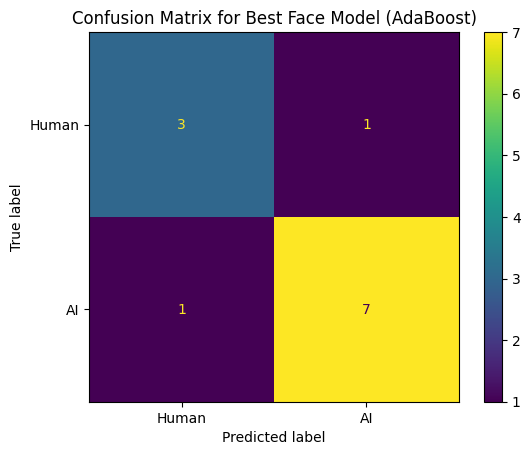

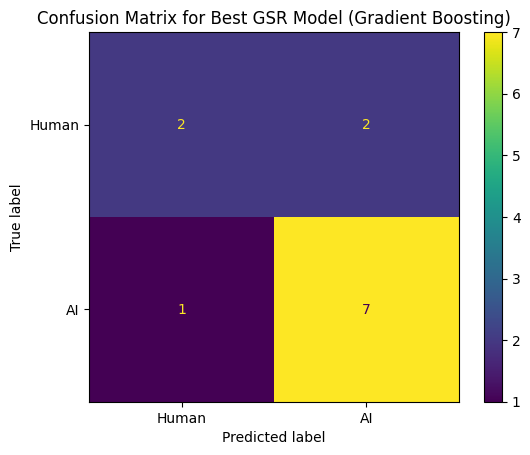

In [23]:
# @title Calling Funcrion(s):3
analyze_and_plot_results(results)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:58:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(



[Meta] Selected model: XGB (metric=accuracy, score=0.8333)

Meta summary (top rows):
    Model                                        Best Params   CV Best  \
0     XGB  {'colsample_bytree': 0.8, 'learning_rate': 0.0...  0.806667   
1      RF  {'max_depth': None, 'max_features': 'sqrt', 'm...  0.786667   
2     MLP  {'clf__activation': 'relu', 'clf__alpha': 1e-0...  0.726667   
3  LogReg  {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__so...  0.726667   
4     SVC  {'clf__C': 0.1, 'clf__gamma': 'scale', 'clf__k...  0.726667   

   Test Accuracy  Test ROC-AUC  Test Brier  Test Precision  Test Recall  \
0       0.833333       0.87500    0.125862        0.875000        0.875   
1       0.833333       0.81250    0.165895        0.875000        0.875   
2       0.750000       0.78125    0.189377        0.857143        0.750   
3       0.666667       0.78125    0.192560        0.700000        0.875   
4       0.583333       0.68750    0.240845        0.636364        0.875   

    Test F1  
0  0

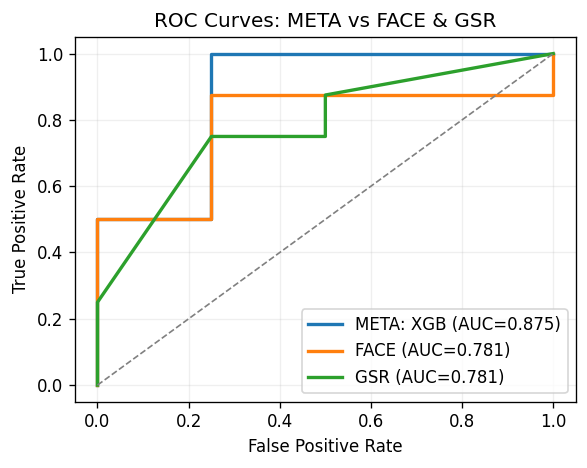

META AUC from plotted curve: 0.875


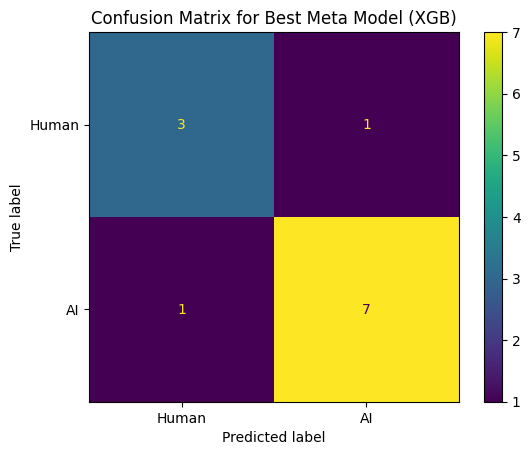

(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.8, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, feature_weights=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.03, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=3, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=600, n_jobs=None,
               num_parallel_tree=None, ...),
     Model                                        Best Params   CV Best  \
 0     XGB  {'colsample_bytree': 0.8, 'learning_rate': 0.0...  0.806667   
 1      RF  {'max_depth': None, 'max_features': 'sqrt', 'm... 

In [24]:
# @title Calling Funcrion(s):4
analyze_and_plot_meta_results(results)

## 3.4: GSR and Image (face) Data combination and Function Calling for Decisoin Window (3 to 0 Seconds to Decision-making)

In [25]:
# @title Extracting GSR and Image Data


GSR_labaled_df  =  total_results_df.copy()
GSR_labaled_df  =  GSR_labaled_df.drop(columns=["max_phasic_postdecision","net_phasic_postdecision", "max_phasic_predecision","net_phasic_predecision" ])   # removing post and pre predecision windows from GSR

Face_labeled_df =  stacked_df_labeled_7_to_10.copy()
Face_labeled_df = Face_labeled_df.drop(columns=["Iteration"])

# Taking the common participant in both modalities
behavioral_face_7to10 = Face_labeled_df[Face_labeled_df["video_File"].isin(GSR_labaled_df["GSR_File"])].reset_index(drop=True)
behavioral_gsr_7to10 = GSR_labaled_df[GSR_labaled_df["GSR_File"].isin(behavioral_face_7to10["video_File"])].reset_index(drop=True)
# removing video_File column
behavioral_face_7to10=behavioral_face_7to10.drop(columns=["video_File" ])   # removing post and pre decision windows from GSR

# combine face and GSR features for 60 common
behavioral_combined_7to10=behavioral_face_7to10.copy()
behavioral_combined_7to10 = behavioral_combined_7to10.reset_index(drop=True)
behavioral_combined_7to10["net_phasic_decision"]=behavioral_gsr_7to10["net_phasic_decision"]
behavioral_combined_7to10["max_phasic_decision"]=behavioral_gsr_7to10["max_phasic_decision"]

In [26]:
# @title Calling Funcrion(s):2
results = train_bimodal_from_combined(
    behavioral_combined_7to10,     # for the predecision window
    # behavioral_combined_7to10,  # for the decision    window
    test_size=0.2,       # fraction of data for test set
    random_state=42,     # reproducible splits
    use_selector=True,   # whether to include feature selection
    cv_splits=5,         # inner CV folds
    scoring="accuracy",  # scoring metric
    n_jobs=-1,           # use all cores
    return_oof=True      # return out-of-fold probs for stacking
)


=== Training FACE on shared split ===
Training Dummy...


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  → Best CV mean accuracy: 0.3133
  → Test accuracy:         0.3333
  → Test AUC:              0.5000
  → Test F1:               0.0000
  → Test Precision:        0.0000
  → Test Recall:           0.0000
  → Best params:           {}
------------------------------------------------------------
Training Random Forest...
  → Best CV mean accuracy: 0.7289
  → Test accuracy:         0.5833
  → Test AUC:              0.8125
  → Test F1:               0.6154
  → Test Precision:        0.8000
  → Test Recall:           0.5000
  → Best params:           {'model__max_depth': None, 'model__min_samples_leaf': 4, 'model__min_samples_split': 5, 'model__n_estimators': 100}
------------------------------------------------------------
Training Gradient Boosting...
  → Best CV mean accuracy: 0.6644
  → Test accuracy:         0.7500
  → Test AUC:              0.9062
  → Test F1:               0.7692
  → Test Precision:        1.0000
  → Test Recall:           0.6250
  → Best params:           {'model__l

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:08:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  → Best CV mean accuracy: 0.6422
  → Test accuracy:         0.8333
  → Test AUC:              0.9219
  → Test F1:               0.8571
  → Test Precision:        1.0000
  → Test Recall:           0.7500
  → Best params:           {'model__gamma': 0, 'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 100}
------------------------------------------------------------

=== Training GSR on shared split ===
Training Dummy...


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  → Best CV mean accuracy: 0.3133
  → Test accuracy:         0.3333
  → Test AUC:              0.5000
  → Test F1:               0.0000
  → Test Precision:        0.0000
  → Test Recall:           0.0000
  → Best params:           {}
------------------------------------------------------------
Training Random Forest...
  → Best CV mean accuracy: 0.5800
  → Test accuracy:         0.5833
  → Test AUC:              0.6406
  → Test F1:               0.6667
  → Test Precision:        0.7143
  → Test Recall:           0.6250
  → Best params:           {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 100}
------------------------------------------------------------
Training Gradient Boosting...
  → Best CV mean accuracy: 0.5600
  → Test accuracy:         0.6667
  → Test AUC:              0.6094
  → Test F1:               0.7143
  → Test Precision:        0.8333
  → Test Recall:           0.6250
  → Best params:           {'model__l

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  → Best CV mean accuracy: 0.5200
  → Test accuracy:         0.3333
  → Test AUC:              0.5000
  → Test F1:               0.0000
  → Test Precision:        0.0000
  → Test Recall:           0.0000
  → Best params:           {'model__C': 1, 'model__penalty': 'l2'}
------------------------------------------------------------
Training Naive Bayes...
  → Best CV mean accuracy: 0.5467
  → Test accuracy:         0.5833
  → Test AUC:              0.2812
  → Test F1:               0.7368
  → Test Precision:        0.6364
  → Test Recall:           0.8750
  → Best params:           {}
------------------------------------------------------------
Training XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:11:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  → Best CV mean accuracy: 0.6667
  → Test accuracy:         0.6667
  → Test AUC:              0.6250
  → Test F1:               0.7143
  → Test Precision:        0.8333
  → Test Recall:           0.6250
  → Best params:           {'model__gamma': 0, 'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100}
------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:11:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:11:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:11:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:11:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:11:09] WARNING: /w


===== SUMMARY (shared split) =====
FACE  → best: Random Forest, CV=0.7289, TEST=0.5833
GSR   → best: XGBoost, CV=0.6667, TEST=0.6667



=== FACE MODALITY SUMMARY ===


Model                                        Best Params  \
0        Random Forest  {'model__max_depth': None, 'model__min_samples...   
1                  SVC  {'model__C': 10, 'model__gamma': 0.1, 'model__...   
2        Decision Tree  {'model__max_depth': None, 'model__min_samples...   
3    Gradient Boosting  {'model__learning_rate': 0.01, 'model__max_dep...   
4  Logistic Regression          {'model__C': 0.1, 'model__penalty': 'l2'}   
5          Naive Bayes                                                 {}   
6              XGBoost  {'model__gamma': 0, 'model__learning_rate': 0....   
7             AdaBoost  {'model__learning_rate': 0.2, 'model__n_estima...   
8                Dummy                                                 {}   

   CV Mean Accuracy  Test Accuracy  Test AUC   Test F1  Test Precision  \
0          0.728889       0.583333  0.812500  0.615385        0.800000   
1          0.704444       0.666667  0.875000  0.714286        0.833333   
2          0.668889       0.750000  0.765625  0.769231        1.000000   
3          0.664444       0.750000  0.906250  0.769231        1.000000   
4          0.662222       0.833333  0.843750  0.857143        1.000000   
5          0.662222       0.500000  0.718750  0.500000        0.750000   
6          0.642222       0.833333  0.921875  0.857143        1.000000   
7          0.600000       0.583333  0.843750  0.615385        0.800000   
8          0.313333       0.333333  0.500000  0.000000        0.000000   

   Test Recall  Overall Test AUC  Overall Test F1  
0        0.500            0.8125         0.615385  
1        0.625            0.8125         0.615385  
2        0.625            0.8125         0.615385  
3        0.625            0.8125         0.615385  
4        0.750            0.8125         0.615385  
5        0.375            0.8125         0.615385  
6        0.750            0.8125         0.615385  
7        0.500            0.8125         0.615385  
8        0.000            0.8125         0.615385


=== GSR MODALITY SUMMARY ===


Model                                        Best Params  \
0              XGBoost  {'model__gamma': 0, 'model__learning_rate': 0....   
1        Decision Tree  {'model__max_depth': None, 'model__min_samples...   
2        Random Forest  {'model__max_depth': None, 'model__min_samples...   
3    Gradient Boosting  {'model__learning_rate': 0.01, 'model__max_dep...   
4          Naive Bayes                                                 {}   
5                  SVC  {'model__C': 10, 'model__gamma': 0.01, 'model_...   
6  Logistic Regression            {'model__C': 1, 'model__penalty': 'l2'}   
7             AdaBoost  {'model__learning_rate': 0.2, 'model__n_estima...   
8                Dummy                                                 {}   

   CV Mean Accuracy  Test Accuracy  Test AUC   Test F1  Test Precision  \
0          0.666667       0.666667  0.625000  0.714286        0.833333   
1          0.582222       0.583333  0.593750  0.615385        0.800000   
2          0.580000       0.583333  0.640625  0.666667        0.714286   
3          0.560000       0.666667  0.609375  0.714286        0.833333   
4          0.546667       0.583333  0.281250  0.736842        0.636364   
5          0.520000       0.416667  0.468750  0.222222        1.000000   
6          0.520000       0.333333  0.500000  0.000000        0.000000   
7          0.477778       0.666667  0.578125  0.714286        0.833333   
8          0.313333       0.333333  0.500000  0.000000        0.000000   

   Test Recall  Overall Test AUC  Overall Test F1  
0        0.625             0.625         0.714286  
1        0.500             0.625         0.714286  
2        0.625             0.625         0.714286  
3        0.625             0.625         0.714286  
4        0.875             0.625         0.714286  
5        0.125             0.625         0.714286  
6        0.000             0.625         0.714286  
7        0.625             0.625         0.714286  
8        0.000             0.625         0.714286


=== COMBINED BEST MODELS SUMMARY ===


Model                                        Best Params  \
Modality                                                                     
Face      Random Forest  {'model__max_depth': None, 'model__min_samples...   
GSR             XGBoost  {'model__gamma': 0, 'model__learning_rate': 0....   

          CV Mean Accuracy  Test Accuracy  Test AUC   Test F1  Test Precision  \
Modality                                                                        
Face              0.728889       0.583333    0.8125  0.615385        0.800000   
GSR               0.666667       0.666667    0.6250  0.714286        0.833333   

          Test Recall  Overall Test AUC  Overall Test F1  \
Modality                                                   
Face            0.500            0.8125         0.615385   
GSR             0.625            0.6250         0.714286   

          Overall Test Precision  Overall Test Recall  \
Modality                                                
Face                    0.800000                0.500   
GSR                     0.833333                0.625   

          Overall Test F1 (Sensitivity)  
Modality                                 
Face                           0.615385  
GSR                            0.714286

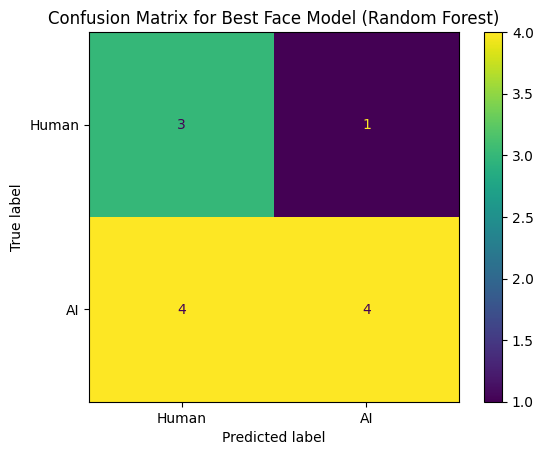

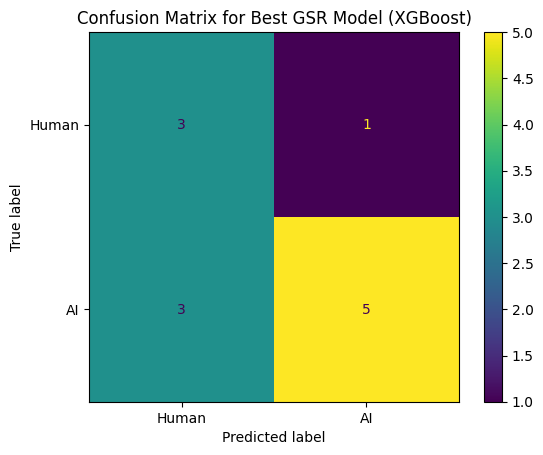

In [27]:
# @title Calling Funcrion(s):3
analyze_and_plot_results(results)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:11:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(



[Meta] Selected model: RF (metric=accuracy, score=0.7500)

Meta summary (top rows):
    Model                                        Best Params   CV Best  \
0      RF  {'max_depth': None, 'max_features': 'sqrt', 'm...  0.706667   
1     SVC  {'clf__C': 5, 'clf__gamma': 'scale', 'clf__ker...  0.746667   
2  LogReg  {'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__s...  0.686667   
3     MLP  {'clf__activation': 'relu', 'clf__alpha': 1e-0...  0.726667   
4     XGB  {'colsample_bytree': 0.8, 'learning_rate': 0.0...  0.711111   

   Test Accuracy  Test ROC-AUC  Test Brier  Test Precision  Test Recall  \
0       0.750000       0.65625    0.195148        0.777778        0.875   
1       0.750000       0.50000    0.203030        0.727273        1.000   
2       0.666667       0.96875    0.216468        0.666667        1.000   
3       0.666667       0.78125    0.170926        0.750000        0.750   
4       0.500000       0.43750    0.285294        0.625000        0.625   

    Test F1  
0  0.

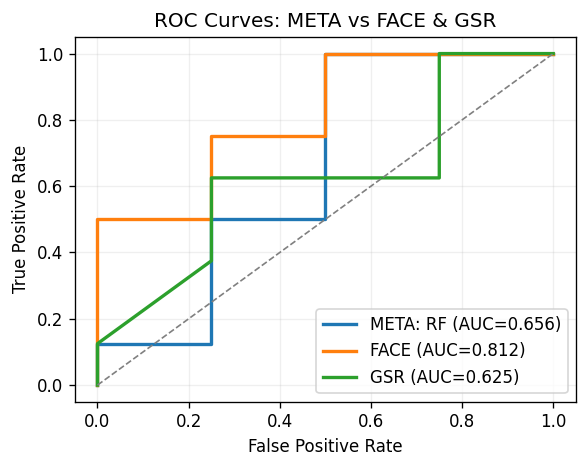

META AUC from plotted curve: 0.656


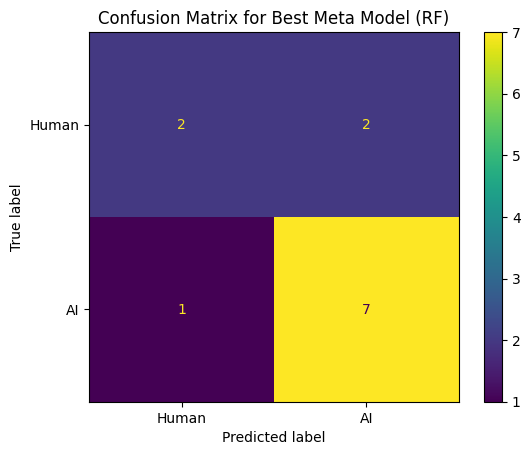

(RandomForestClassifier(n_estimators=200, random_state=42),
     Model                                        Best Params   CV Best  \
 0      RF  {'max_depth': None, 'max_features': 'sqrt', 'm...  0.706667   
 1     SVC  {'clf__C': 5, 'clf__gamma': 'scale', 'clf__ker...  0.746667   
 2  LogReg  {'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__s...  0.686667   
 3     MLP  {'clf__activation': 'relu', 'clf__alpha': 1e-0...  0.726667   
 4     XGB  {'colsample_bytree': 0.8, 'learning_rate': 0.0...  0.711111   
 
    Test Accuracy  Test ROC-AUC  Test Brier  Test Precision  Test Recall  \
 0       0.750000       0.65625    0.195148        0.777778        0.875   
 1       0.750000       0.50000    0.203030        0.727273        1.000   
 2       0.666667       0.96875    0.216468        0.666667        1.000   
 3       0.666667       0.78125    0.170926        0.750000        0.750   
 4       0.500000       0.43750    0.285294        0.625000        0.625   
 
     Test F1  
 0  0.823529  


In [28]:
# @title Calling Funcrion(s):4
analyze_and_plot_meta_results(results)